In [98]:
import os
import sys
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from darts import TimeSeries
from darts.metrics import mae, mse, rmse

# # For local notebook
# src_folder = os.path.abspath(os.path.join(os.pardir, "src"))
# sys.path.append(src_folder)

# from metrics import compare_series_metrics

# from custom_plots import (
#     aggregate_median_metrics,
#     plot_bar_for_medians_by_target,
#     plot_boxplots_for_metrics_by_target,
#     process_results_parquet,
# )

In [99]:
# Funções auxiliares para adicionar no modulo de plot
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.metrics import mae, rmse


def compute_mae_rmse_darts(row):
    ts_actual = TimeSeries.from_values(row['Actuals_values'])
    ts_pred = TimeSeries.from_values(row['Preds_values'])
    return pd.Series({
        'MAE': mae(ts_actual, ts_pred),
        'RMSE': rmse(ts_actual, ts_pred)
    })

def summarize_mae_rmse_from_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adiciona colunas de MAE e RMSE por linha no DataFrame, e retorna um resumo com as médias dessas métricas,
    além de informações constantes como o nome do modelo e tempos de execução.
    """
    # Calcula MAE e RMSE por linha
    df[['MAE', 'RMSE']] = df.apply(compute_mae_rmse_darts, axis=1)

    # Calcula a média de MAE e RMSE
    summary = df[['MAE', 'RMSE']].mean().to_frame().T
    summary.rename(columns={'MAE': 'Average_MAE', 'RMSE': 'Average_RMSE'}, inplace=True)

    # Copia colunas constantes
    const_cols = ['Model', 'Fit_elapsed_time', 'Historical_Forecast_elapsed_time']
    for col in const_cols:
        if col in df.columns:
            summary[col] = df[col].iloc[0]

    # Reorganiza colunas
    summary = summary[['Model', 'Fit_elapsed_time', 'Historical_Forecast_elapsed_time', 'Average_MAE', 'Average_RMSE']]

    return summary

def process_all_parquet_folders(folder_paths):
    all_summaries = []

    for path in folder_paths:
        folder_name = os.path.basename(path)
        all_files = [f for f in os.listdir(path) if f.endswith('.parquet')]

        for file in all_files:
            file_path = os.path.join(path, file)
            df = pd.read_parquet(file_path)
            summary = summarize_mae_rmse_from_df(df)
            summary['File'] = file
            summary['Folder'] = folder_name
            all_summaries.append(summary)

    final_df = pd.concat(all_summaries, ignore_index=True)
    return final_df

def collect_metrics_df_from_folder(folder_path):
    folder_name = os.path.basename(folder_path)
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.parquet')]
    all_metrics = []

    for file in all_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_parquet(file_path)
        df[['MAE', 'RMSE']] = df.apply(compute_mae_rmse_darts, axis=1)
        df['Model'] = df['Model'].astype(str)
        df['Folder'] = folder_name
        all_metrics.append(df[['Model', 'Folder', 'MAE', 'RMSE']])
    
    return pd.concat(all_metrics, ignore_index=True)


## Estilo dos gráficos

In [100]:
plt.rcParams["figure.figsize"] = [20, 8]

In [101]:
sns.set_palette("Paired")

## Lendo os resultados salvos em parquet

In [102]:
# data_path = os.path.join(os.pardir, "data")
# os.path.join(os.pardir, "data", "90_split", "no_window")

Analisando apenas um resultado:

In [103]:
local_univariate_path = os.path.join(os.pardir, "data", "results", "local_univariate")
global_no_covariates_path = os.path.join(os.pardir, "data", "results", "global_no_covariates")
global_covariates_path = os.path.join(os.pardir, "data", "results", "global_covariates")

In [104]:
test_df = pd.read_parquet(os.path.join(local_univariate_path, "local_univariate_ExponentialSmoothing_historical_forecast.parquet"))
test_df = test_df.reset_index(drop=True)
test_df.head(5)

Model  Series_id  Fit_elapsed_time  \
0  ExponentialSmoothing          0          0.003098   
1  ExponentialSmoothing          1          0.003098   
2  ExponentialSmoothing          2          0.003098   
3  ExponentialSmoothing          3          0.003098   
4  ExponentialSmoothing          4          0.003098   

   Historical_Forecast_elapsed_time  \
0                          3.556544   
1                          3.556544   
2                          3.556544   
3                          3.556544   
4                          3.556544   

                                       Actuals_index  \
0  [2020-02-27 20:08:18, 2020-02-27 20:08:19, 202...   
1  [2020-02-13 14:44:15, 2020-02-13 14:44:16, 202...   
2  [2019-12-16 14:10:37, 2019-12-16 14:10:38, 201...   
3  [2020-01-16 11:32:46, 2020-01-16 11:32:47, 202...   
4  [2020-02-14 13:36:16, 2020-02-14 13:36:17, 202...   

                                      Actuals_values  \
0  [1.781, 0.002, 2.641, 2.739, 2.0045, 1.27, 3.2...   
1  [7.794, 2.586, 1.8544999999999998, 1.123, 0.68...   
2  [31.183, 59.41, 61.783, 64.156, 70.585, 58.742...   
3  [21.045, 12.966, 0.002, 0.002, 24.433, 27.28, ...   
4  [0.163, 2.945, 18.635, 24.348, 139.961, 169.34...   

                                         Preds_index  \
0  [2020-02-27 20:08:18, 2020-02-27 20:08:19, 202...   
1  [2020-02-13 14:44:15, 2020-02-13 14:44:16, 202...   
2  [2019-12-16 14:10:37, 2019-12-16 14:10:38, 201...   
3  [2020-01-16 11:32:46, 2020-01-16 11:32:47, 202...   
4  [2020-02-14 13:36:16, 2020-02-14 13:36:17, 202...   

                                        Preds_values  
0  [6.750999990999698, 7.710999985694562, 10.7979...  
1  [5.821999988019471, 8.281999963342964, 11.5329...  
2  [58.268000204741966, 52.73300008247792, 55.114...  
3  [10.094000099361352, 21.947999823361574, 21.04...  
4  [199.4530003565252, 198.2570000178218, 197.061...

In [105]:
summarize_mae_rmse_from_df(test_df)

Model  Fit_elapsed_time  Historical_Forecast_elapsed_time  \
0  ExponentialSmoothing          0.003098                          3.556544   

   Average_MAE  Average_RMSE  
0    10.098361     16.341078

<Axes: xlabel='time'>

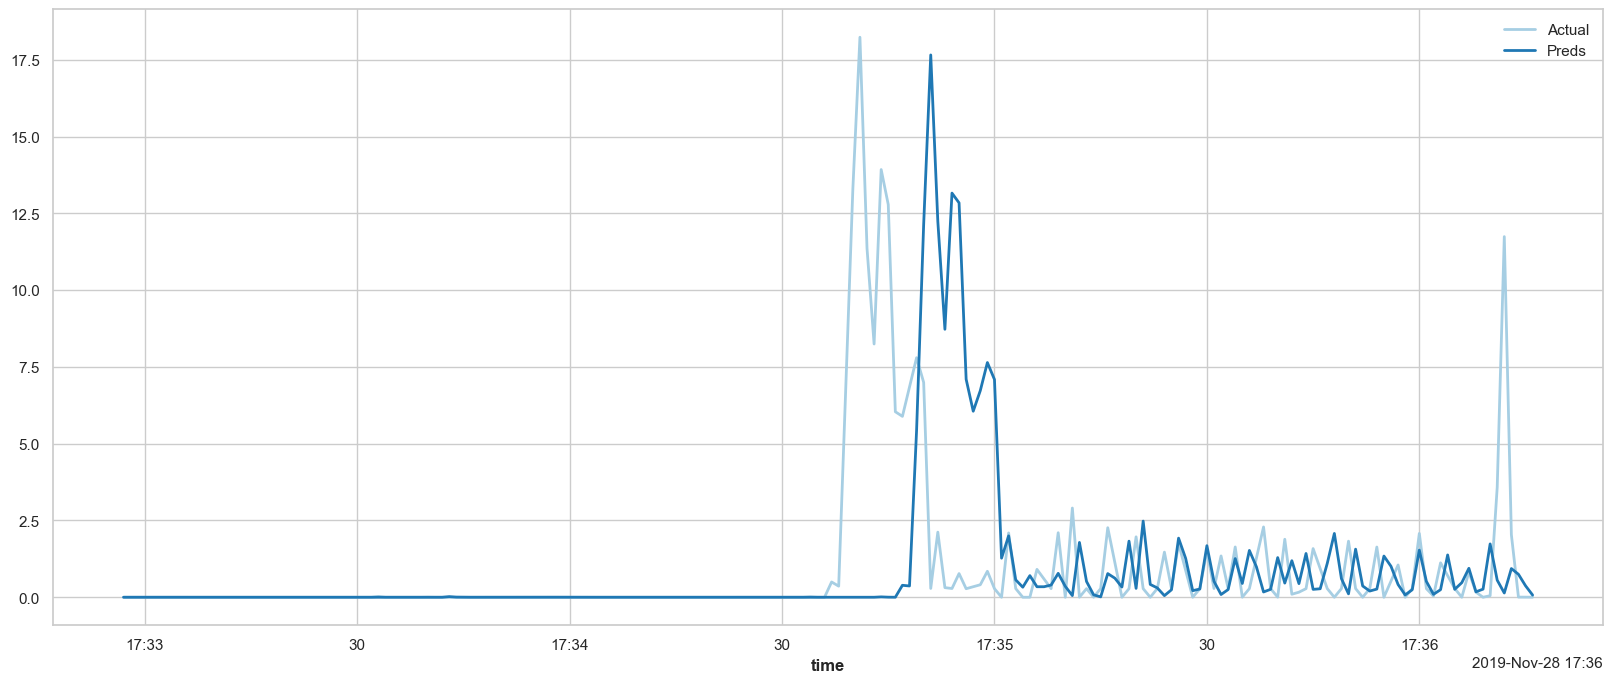

In [106]:
sample_idx = 50
dates_1 = pd.DatetimeIndex(test_df["Actuals_index"][sample_idx])
values_1 = test_df["Actuals_values"][sample_idx]
actual_ts = TimeSeries.from_times_and_values(dates_1, values_1)


dates_2 = pd.DatetimeIndex(test_df["Preds_index"][sample_idx])
values_2 = test_df["Preds_values"][sample_idx]
preds_ts = TimeSeries.from_times_and_values(dates_2, values_2)

actual_ts.plot(label="Actual")
preds_ts.plot(label="Preds")

In [107]:
test_df = pd.read_parquet(os.path.join(global_no_covariates_path, "global_no_covariate_LinearRegressionModel_historical_forecast.parquet"))
test_df = test_df.reset_index(drop=True)
test_df.head(5)

Model  Series_id  Fit_elapsed_time  \
0  LinearRegressionModel          0          0.057943   
1  LinearRegressionModel          1          0.057943   
2  LinearRegressionModel          2          0.057943   
3  LinearRegressionModel          3          0.057943   
4  LinearRegressionModel          4          0.057943   

   Historical_Forecast_elapsed_time  \
0                          0.148681   
1                          0.148681   
2                          0.148681   
3                          0.148681   
4                          0.148681   

                                       Actuals_index  \
0  [2020-02-27 20:08:18, 2020-02-27 20:08:19, 202...   
1  [2020-02-13 14:44:15, 2020-02-13 14:44:16, 202...   
2  [2019-12-16 14:10:37, 2019-12-16 14:10:38, 201...   
3  [2020-01-16 11:32:46, 2020-01-16 11:32:47, 202...   
4  [2020-02-14 13:36:16, 2020-02-14 13:36:17, 202...   

                                      Actuals_values  \
0  [1.781, 0.002, 2.641, 2.739, 2.0045, 1.27, 3.2...   
1  [7.794, 2.586, 1.8544999999999998, 1.123, 0.68...   
2  [31.183, 59.41, 61.783, 64.156, 70.585, 58.742...   
3  [21.045, 12.966, 0.002, 0.002, 24.433, 27.28, ...   
4  [0.163, 2.945, 18.635, 24.348, 139.961, 169.34...   

                                         Preds_index  \
0  [2020-02-27 20:08:18, 2020-02-27 20:08:19, 202...   
1  [2020-02-13 14:44:15, 2020-02-13 14:44:16, 202...   
2  [2019-12-16 14:10:37, 2019-12-16 14:10:38, 201...   
3  [2020-01-16 11:32:46, 2020-01-16 11:32:47, 202...   
4  [2020-02-14 13:36:16, 2020-02-14 13:36:17, 202...   

                                        Preds_values  
0  [9.557667418492242, 9.228599418650234, 9.63435...  
1  [16.483988143425425, 16.518444646721687, 15.67...  
2  [36.119207757251566, 45.299600713077886, 52.72...  
3  [105.83577120976312, 90.75014884020344, 49.997...  
4  [120.84062789035042, 122.803429192438, 141.493...

In [108]:
summarize_mae_rmse_from_df(test_df)

Model  Fit_elapsed_time  Historical_Forecast_elapsed_time  \
0  LinearRegressionModel          0.057943                          0.148681   

   Average_MAE  Average_RMSE  
0     8.348262     12.869573

<Axes: xlabel='time'>

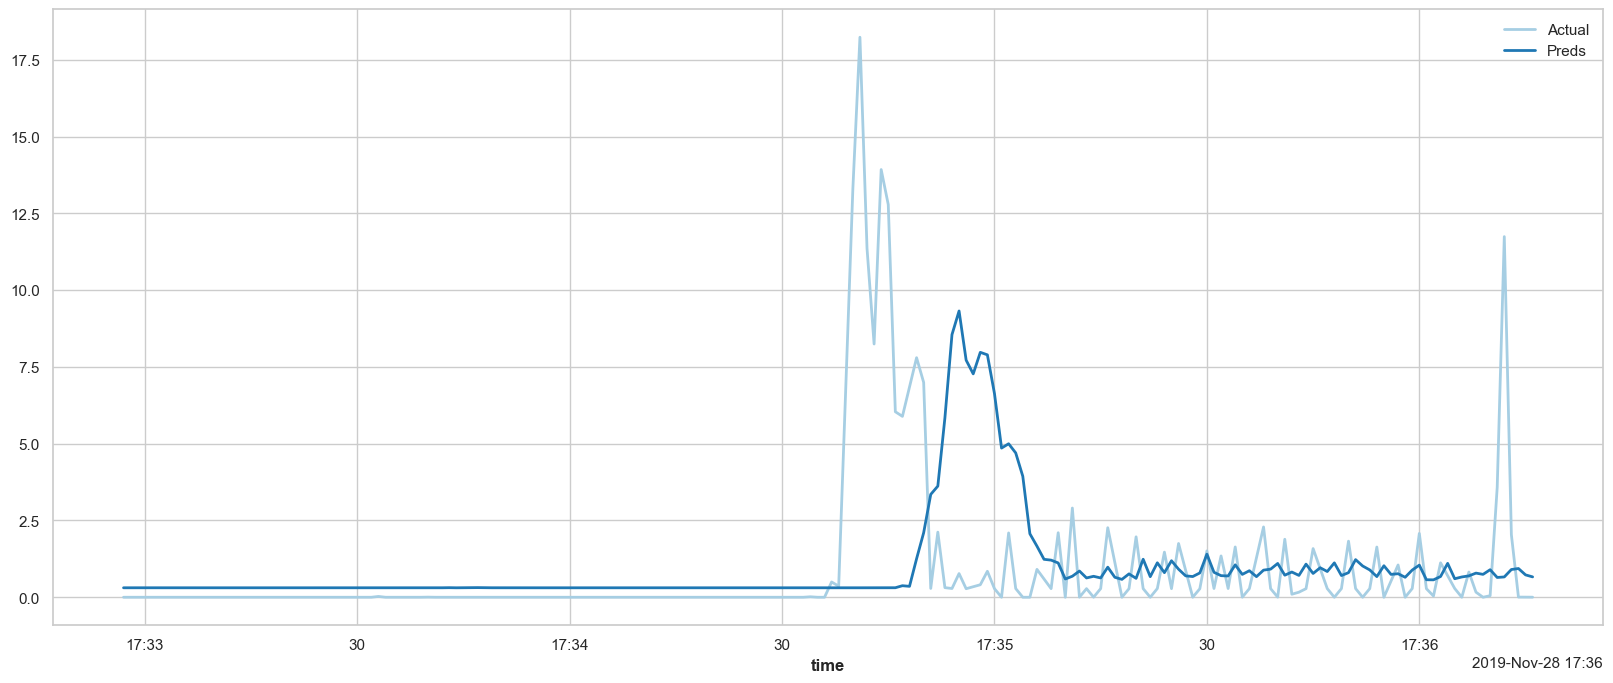

In [109]:
sample_idx = 50
dates_1 = pd.DatetimeIndex(test_df["Actuals_index"][sample_idx])
values_1 = test_df["Actuals_values"][sample_idx]
actual_ts = TimeSeries.from_times_and_values(dates_1, values_1)


dates_2 = pd.DatetimeIndex(test_df["Preds_index"][sample_idx])
values_2 = test_df["Preds_values"][sample_idx]
preds_ts = TimeSeries.from_times_and_values(dates_2, values_2)

actual_ts.plot(label="Actual")
preds_ts.plot(label="Preds")

In [110]:
test_df = pd.read_parquet(os.path.join(global_covariates_path, "covariate_LinearRegressionModel_historical_forecast.parquet"))
test_df = test_df.reset_index(drop=True)
test_df.head(5)

Model  Series_id  Fit_elapsed_time  \
0  LinearRegressionModel          0          0.365621   
1  LinearRegressionModel          1          0.365621   
2  LinearRegressionModel          2          0.365621   
3  LinearRegressionModel          3          0.365621   
4  LinearRegressionModel          4          0.365621   

   Historical_Forecast_elapsed_time  \
0                         104.42786   
1                         104.42786   
2                         104.42786   
3                         104.42786   
4                         104.42786   

                                       Actuals_index  \
0  [2020-02-27T20:08:18.000000000, 2020-02-27T20:...   
1  [2020-02-13T14:44:15.000000000, 2020-02-13T14:...   
2  [2019-12-16T14:10:37.000000000, 2019-12-16T14:...   
3  [2020-01-16T11:32:46.000000000, 2020-01-16T11:...   
4  [2020-02-14T13:36:16.000000000, 2020-02-14T13:...   

                                      Actuals_values  \
0  [1.781, 0.002, 2.641, 2.739, 2.0045, 1.27, 3.2...   
1  [7.794, 2.586, 1.8544999999999998, 1.123, 0.68...   
2  [31.183, 59.41, 61.783, 64.156, 70.585, 58.742...   
3  [21.045, 12.966, 0.002, 0.002, 24.433, 27.28, ...   
4  [0.163, 2.945, 18.635, 24.348, 139.961, 169.34...   

                                         Preds_index  \
0  [2020-02-27T20:08:18.000000000, 2020-02-27T20:...   
1  [2020-02-13T14:44:15.000000000, 2020-02-13T14:...   
2  [2019-12-16T14:10:37.000000000, 2019-12-16T14:...   
3  [2020-01-16T11:32:46.000000000, 2020-01-16T11:...   
4  [2020-02-14T13:36:16.000000000, 2020-02-14T13:...   

                                        Preds_values  
0  [10.736733755899406, 11.327747680707972, 12.99...  
1  [17.868539029755876, 17.76410198775188, 17.070...  
2  [44.841951065941835, 42.686319883062616, 42.49...  
3  [52.37695899958607, 47.65938967876973, 41.8182...  
4  [121.17038411184039, 121.77942826051581, 123.1...

In [111]:
summarize_mae_rmse_from_df(test_df)

Model  Fit_elapsed_time  Historical_Forecast_elapsed_time  \
0  LinearRegressionModel          0.365621                         104.42786   

   Average_MAE  Average_RMSE  
0     9.086812     13.553593

<Axes: xlabel='time'>

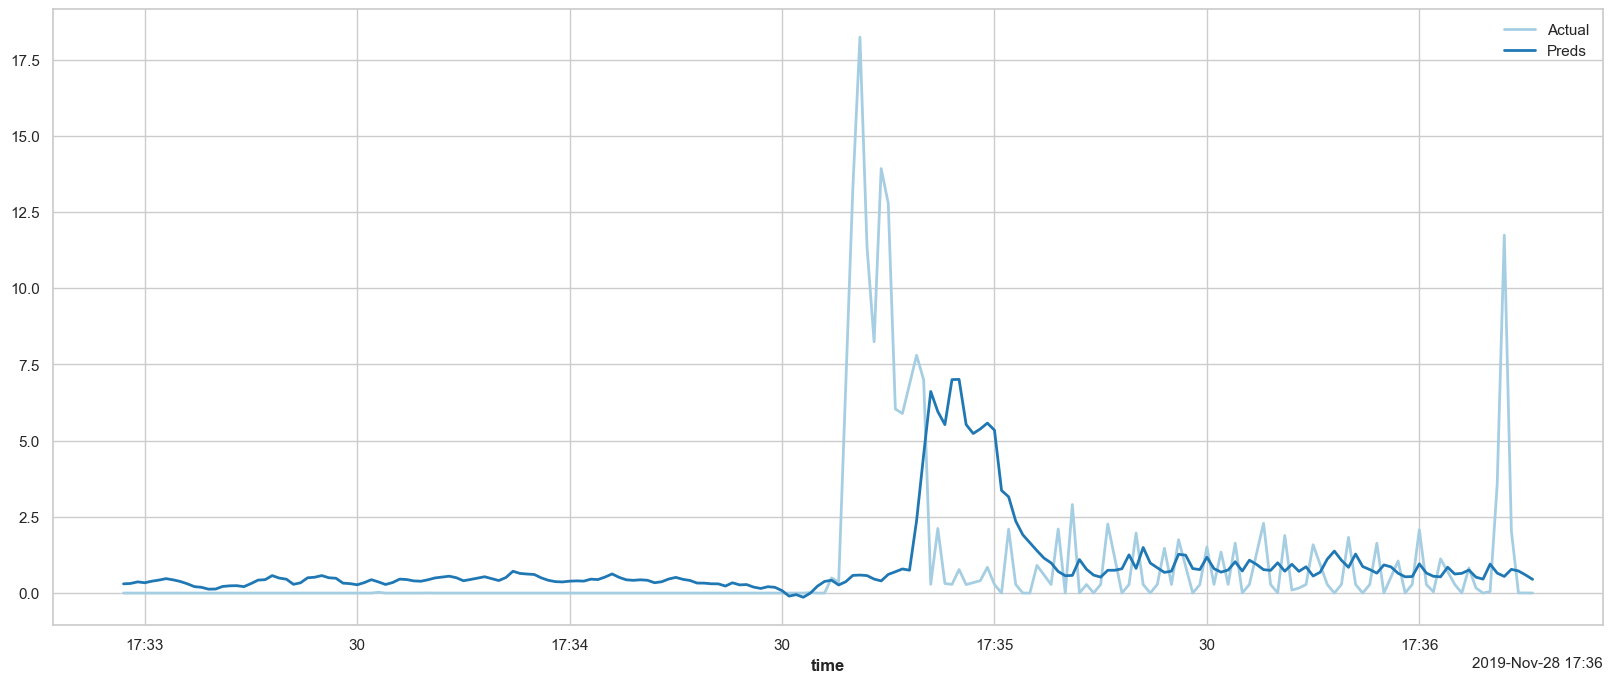

In [112]:
sample_idx = 50
dates_1 = pd.DatetimeIndex(test_df["Actuals_index"][sample_idx])
values_1 = test_df["Actuals_values"][sample_idx]
actual_ts = TimeSeries.from_times_and_values(dates_1, values_1)


dates_2 = pd.DatetimeIndex(test_df["Preds_index"][sample_idx])
values_2 = test_df["Preds_values"][sample_idx]
preds_ts = TimeSeries.from_times_and_values(dates_2, values_2)

actual_ts.plot(label="Actual")
preds_ts.plot(label="Preds")

In [113]:
test_df = pd.read_parquet(os.path.join(global_no_covariates_path, "global_no_covariate_BlockRNNModel_historical_forecast.parquet"))
test_df = test_df.reset_index(drop=True)
test_df.head(5)

Model  Series_id  Fit_elapsed_time  \
0  BlockRNNModel          0       7473.547832   
1  BlockRNNModel          1       7473.547832   
2  BlockRNNModel          2       7473.547832   
3  BlockRNNModel          3       7473.547832   
4  BlockRNNModel          4       7473.547832   

   Historical_Forecast_elapsed_time  \
0                         35.759356   
1                         35.759356   
2                         35.759356   
3                         35.759356   
4                         35.759356   

                                       Actuals_index  \
0  [2020-02-27 20:08:18, 2020-02-27 20:08:19, 202...   
1  [2020-02-13 14:44:15, 2020-02-13 14:44:16, 202...   
2  [2019-12-16 14:10:37, 2019-12-16 14:10:38, 201...   
3  [2020-01-16 11:32:46, 2020-01-16 11:32:47, 202...   
4  [2020-02-14 13:36:16, 2020-02-14 13:36:17, 202...   

                                      Actuals_values  \
0  [1.781, 0.002, 2.641, 2.739, 2.0045, 1.27, 3.2...   
1  [7.794, 2.586, 1.8544999999999998, 1.123, 0.68...   
2  [31.183, 59.41, 61.783, 64.156, 70.585, 58.742...   
3  [21.045, 12.966, 0.002, 0.002, 24.433, 27.28, ...   
4  [0.163, 2.945, 18.635, 24.348, 139.961, 169.34...   

                                         Preds_index  \
0  [2020-02-27 20:08:18, 2020-02-27 20:08:19, 202...   
1  [2020-02-13 14:44:15, 2020-02-13 14:44:16, 202...   
2  [2019-12-16 14:10:37, 2019-12-16 14:10:38, 201...   
3  [2020-01-16 11:32:46, 2020-01-16 11:32:47, 202...   
4  [2020-02-14 13:36:16, 2020-02-14 13:36:17, 202...   

                                        Preds_values  
0  [9.016189444034504, 9.431192986448874, 11.6859...  
1  [16.13481089225728, 10.646915540204553, 27.115...  
2  [7.8898829776763275, 24.8813811255634, 31.5569...  
3  [99.10132504035948, 110.0345909195792, 53.5808...  
4  [38.65545957443129, 27.106603413924187, 101.76...

In [114]:
summarize_mae_rmse_from_df(test_df)

Model  Fit_elapsed_time  Historical_Forecast_elapsed_time  \
0  BlockRNNModel       7473.547832                         35.759356   

   Average_MAE  Average_RMSE  
0     8.354949     13.237655

<Axes: xlabel='time'>

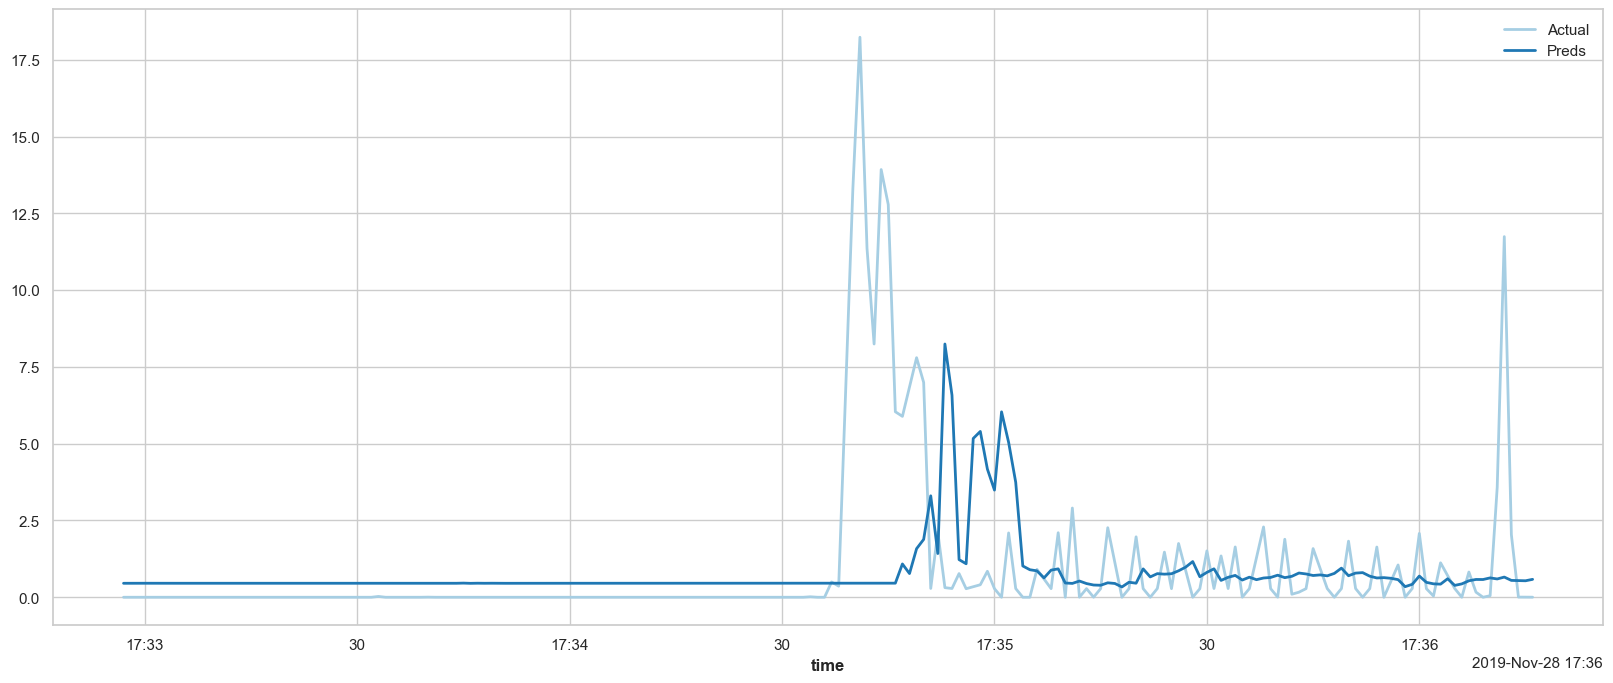

In [115]:
sample_idx = 50
dates_1 = pd.DatetimeIndex(test_df["Actuals_index"][sample_idx])
values_1 = test_df["Actuals_values"][sample_idx]
actual_ts = TimeSeries.from_times_and_values(dates_1, values_1)


dates_2 = pd.DatetimeIndex(test_df["Preds_index"][sample_idx])
values_2 = test_df["Preds_values"][sample_idx]
preds_ts = TimeSeries.from_times_and_values(dates_2, values_2)

actual_ts.plot(label="Actual")
preds_ts.plot(label="Preds")

In [116]:
test_df = pd.read_parquet(os.path.join(global_covariates_path, "covariate_BlockRNNModel_historical_forecast.parquet"))
test_df = test_df.reset_index(drop=True)
test_df.head(5)

Model  Series_id  Fit_elapsed_time  \
0  BlockRNNModel          0        5820.93655   
1  BlockRNNModel          1        5820.93655   
2  BlockRNNModel          2        5820.93655   
3  BlockRNNModel          3        5820.93655   
4  BlockRNNModel          4        5820.93655   

   Historical_Forecast_elapsed_time  \
0                         37.581842   
1                         37.581842   
2                         37.581842   
3                         37.581842   
4                         37.581842   

                                       Actuals_index  \
0  [2020-02-27T20:08:18.000000000, 2020-02-27T20:...   
1  [2020-02-13T14:44:15.000000000, 2020-02-13T14:...   
2  [2019-12-16T14:10:37.000000000, 2019-12-16T14:...   
3  [2020-01-16T11:32:46.000000000, 2020-01-16T11:...   
4  [2020-02-14T13:36:16.000000000, 2020-02-14T13:...   

                                      Actuals_values  \
0  [1.781, 0.002, 2.641, 2.739, 2.0045, 1.27, 3.2...   
1  [7.794, 2.586, 1.8544999999999998, 1.123, 0.68...   
2  [31.183, 59.41, 61.783, 64.156, 70.585, 58.742...   
3  [21.045, 12.966, 0.002, 0.002, 24.433, 27.28, ...   
4  [0.163, 2.945, 18.635, 24.348, 139.961, 169.34...   

                                         Preds_index  \
0  [2020-02-27T20:08:18.000000000, 2020-02-27T20:...   
1  [2020-02-13T14:44:15.000000000, 2020-02-13T14:...   
2  [2019-12-16T14:10:37.000000000, 2019-12-16T14:...   
3  [2020-01-16T11:32:46.000000000, 2020-01-16T11:...   
4  [2020-02-14T13:36:16.000000000, 2020-02-14T13:...   

                                        Preds_values  
0  [9.028630666443622, 8.649802151457799, 9.98774...  
1  [20.644206780857505, 47.46777821724879, 35.271...  
2  [-11.519759976886593, 51.11144729291027, 96.10...  
3  [172.06608032872754, 103.80932201221422, -4.77...  
4  [76.132610263883, 80.64397933034033, 165.50375...

In [117]:
summarize_mae_rmse_from_df(test_df)

Model  Fit_elapsed_time  Historical_Forecast_elapsed_time  \
0  BlockRNNModel        5820.93655                         37.581842   

   Average_MAE  Average_RMSE  
0     8.746808     14.050583

<Axes: xlabel='time'>

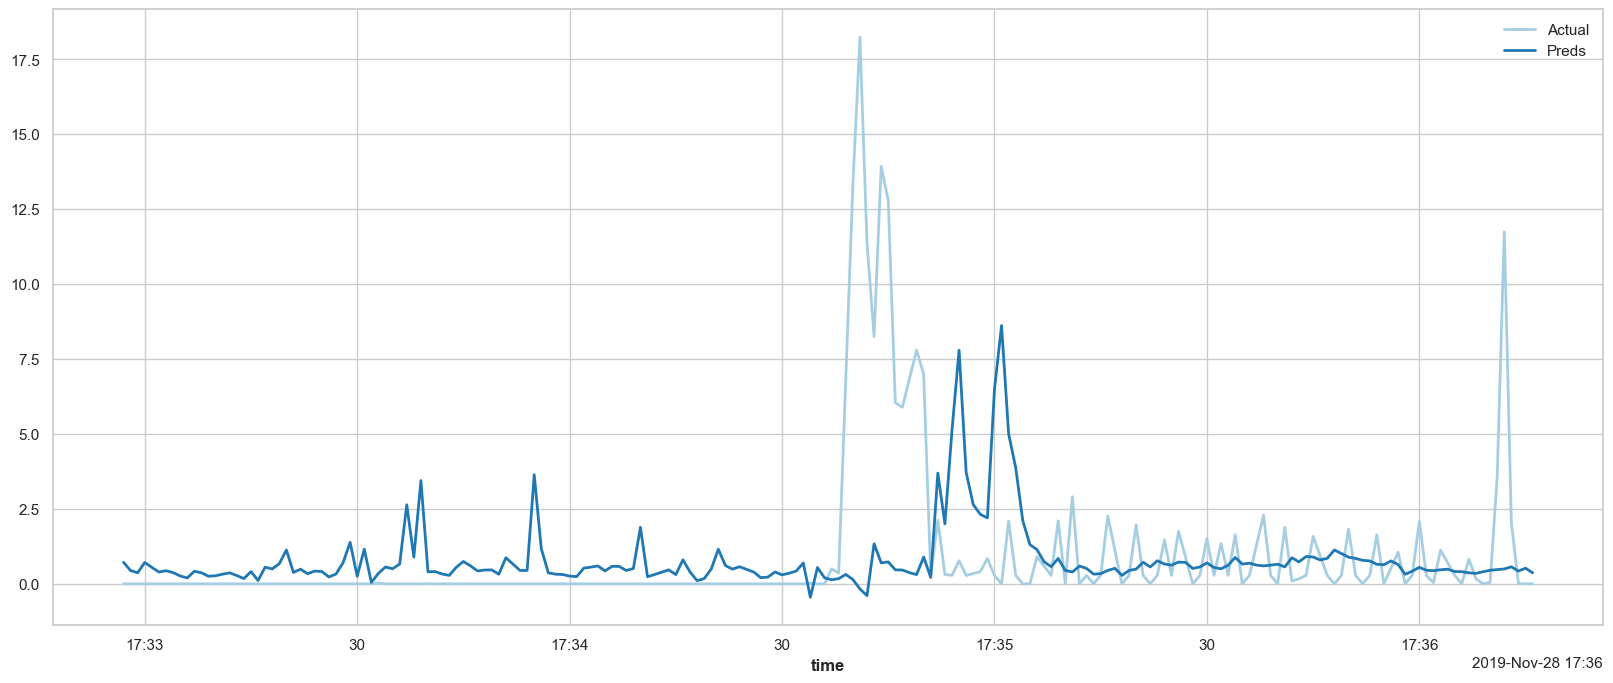

In [118]:
sample_idx = 50
dates_1 = pd.DatetimeIndex(test_df["Actuals_index"][sample_idx])
values_1 = test_df["Actuals_values"][sample_idx]
actual_ts = TimeSeries.from_times_and_values(dates_1, values_1)


dates_2 = pd.DatetimeIndex(test_df["Preds_index"][sample_idx])
values_2 = test_df["Preds_values"][sample_idx]
preds_ts = TimeSeries.from_times_and_values(dates_2, values_2)

actual_ts.plot(label="Actual")
preds_ts.plot(label="Preds")

<Axes: xlabel='time'>

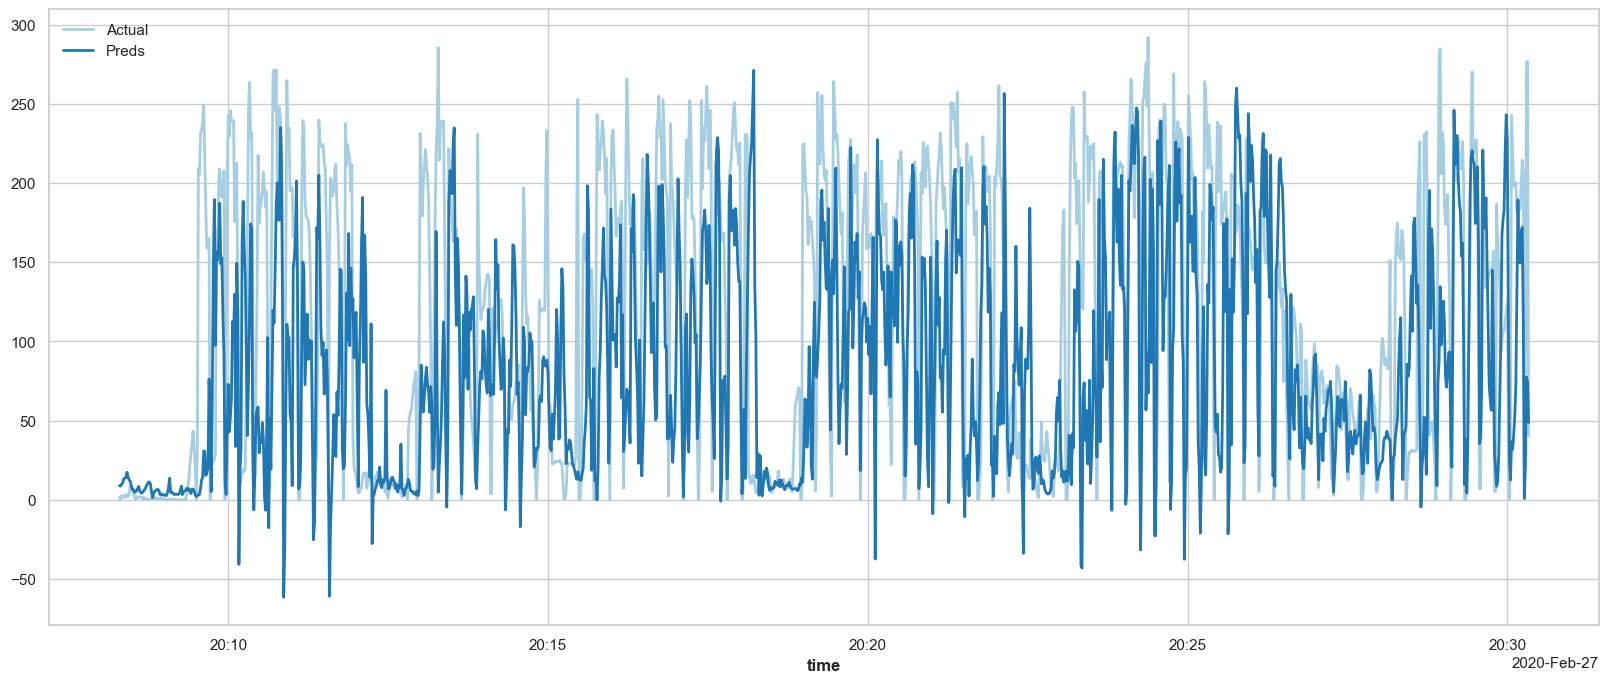

In [119]:
sample_idx = 0
dates_1 = pd.DatetimeIndex(test_df["Actuals_index"][sample_idx])
values_1 = test_df["Actuals_values"][sample_idx]
actual_ts = TimeSeries.from_times_and_values(dates_1, values_1)


dates_2 = pd.DatetimeIndex(test_df["Preds_index"][sample_idx])
values_2 = test_df["Preds_values"][sample_idx]
preds_ts = TimeSeries.from_times_and_values(dates_2, values_2)

actual_ts.plot(label="Actual")
preds_ts.plot(label="Preds")

In [120]:
test_df = pd.read_parquet(os.path.join(global_no_covariates_path, "global_no_covariate_LightGBMModel_historical_forecast.parquet"))
test_df = test_df.reset_index(drop=True)
test_df.head(5)

Model  Series_id  Fit_elapsed_time  \
0  LightGBMModel          0          1.647542   
1  LightGBMModel          1          1.647542   
2  LightGBMModel          2          1.647542   
3  LightGBMModel          3          1.647542   
4  LightGBMModel          4          1.647542   

   Historical_Forecast_elapsed_time  \
0                          0.750456   
1                          0.750456   
2                          0.750456   
3                          0.750456   
4                          0.750456   

                                       Actuals_index  \
0  [2020-02-27 20:08:18, 2020-02-27 20:08:19, 202...   
1  [2020-02-13 14:44:15, 2020-02-13 14:44:16, 202...   
2  [2019-12-16 14:10:37, 2019-12-16 14:10:38, 201...   
3  [2020-01-16 11:32:46, 2020-01-16 11:32:47, 202...   
4  [2020-02-14 13:36:16, 2020-02-14 13:36:17, 202...   

                                      Actuals_values  \
0  [1.781, 0.002, 2.641, 2.739, 2.0045, 1.27, 3.2...   
1  [7.794, 2.586, 1.8544999999999998, 1.123, 0.68...   
2  [31.183, 59.41, 61.783, 64.156, 70.585, 58.742...   
3  [21.045, 12.966, 0.002, 0.002, 24.433, 27.28, ...   
4  [0.163, 2.945, 18.635, 24.348, 139.961, 169.34...   

                                         Preds_index  \
0  [2020-02-27 20:08:18, 2020-02-27 20:08:19, 202...   
1  [2020-02-13 14:44:15, 2020-02-13 14:44:16, 202...   
2  [2019-12-16 14:10:37, 2019-12-16 14:10:38, 201...   
3  [2020-01-16 11:32:46, 2020-01-16 11:32:47, 202...   
4  [2020-02-14 13:36:16, 2020-02-14 13:36:17, 202...   

                                        Preds_values  
0  [9.34565835991247, 7.477433877814, 7.579173146...  
1  [16.427355397602444, 14.226562791540898, 16.44...  
2  [22.364790715560957, 50.48371163139187, 56.194...  
3  [127.74004530281344, 88.54534763892588, 33.350...  
4  [50.229883644789666, 46.47333557679614, 83.707...

In [121]:
summarize_mae_rmse_from_df(test_df)

Model  Fit_elapsed_time  Historical_Forecast_elapsed_time  \
0  LightGBMModel          1.647542                          0.750456   

   Average_MAE  Average_RMSE  
0     7.834904     12.212385

<Axes: xlabel='time'>

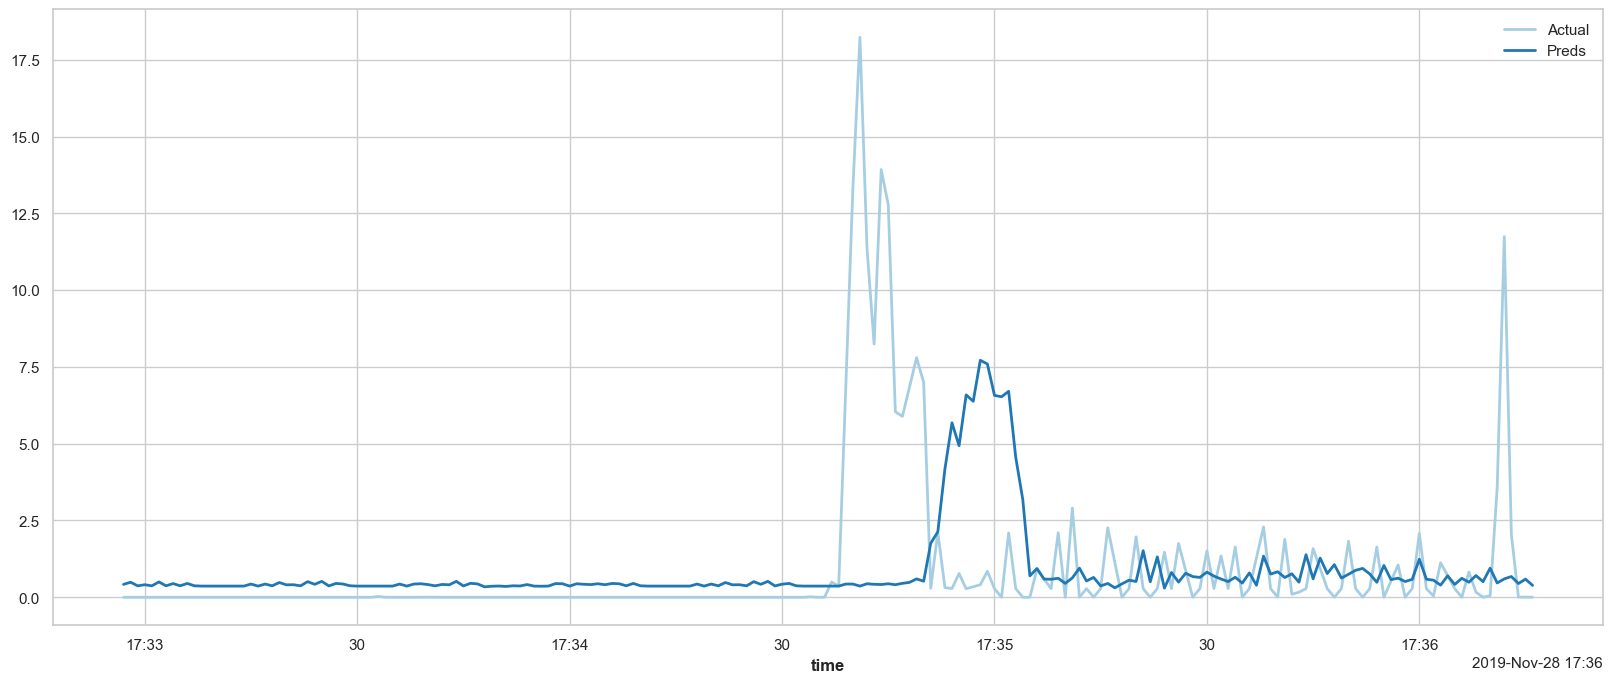

In [122]:
sample_idx = 50
dates_1 = pd.DatetimeIndex(test_df["Actuals_index"][sample_idx])
values_1 = test_df["Actuals_values"][sample_idx]
actual_ts = TimeSeries.from_times_and_values(dates_1, values_1)


dates_2 = pd.DatetimeIndex(test_df["Preds_index"][sample_idx])
values_2 = test_df["Preds_values"][sample_idx]
preds_ts = TimeSeries.from_times_and_values(dates_2, values_2)

actual_ts.plot(label="Actual")
preds_ts.plot(label="Preds")

In [123]:
# Define os caminhos das pastas
local_univariate_path = os.path.join(os.pardir, "data", "results", "local_univariate")
global_no_covariates_path = os.path.join(os.pardir, "data", "results", "global_no_covariates")
global_covariates_path = os.path.join(os.pardir, "data", "results", "global_covariates")

# Lista com todos os caminhos
all_paths = [local_univariate_path, global_no_covariates_path, global_covariates_path]

# Processa todos os arquivos e junta os resultados
final_df = process_all_parquet_folders(all_paths)

In [124]:
# Sort and clean original DataFrame
latex_df = final_df.sort_values(by='Average_RMSE', ascending=True).reset_index(drop=True).drop(columns=['File'])

# Mapping folder names to human-readable model type suffixes
folder_map = {
    'global_no_covariates': ' [Global - no covariates]',
    'global_covariates': ' [Global - with covariates]',
    'local_univariate': ' [Local - univariate]',
}

# Adiciona a informação do tipo ao nome original
latex_df['FullModel'] = latex_df.apply(lambda row: row['Model'] + folder_map.get(row['Folder'], ''), axis=1)

# Separar em duas colunas: nome base e tipo
latex_df['Model_Base'] = latex_df['FullModel'].str.extract(r'(^[^\[]+)')[0].str.strip()
latex_df['Model_Type'] = latex_df['FullModel'].str.extract(r'\[(.*)\]')[0]

# Mapeamento de nomes legíveis
model_name_map = {
    'LightGBMModel': 'LightGBM',
    'RandomForest': 'Random Forest',
    'LinearRegressionModel': 'Linear Regression',
    'BlockRNNModel': 'Block RNN',
    'NBEATSModel': 'N-BEATS',
    'GlobalNaiveAggregate': 'Naive Aggregate',
    'GlobalNaiveSeasonal': 'Naive Seasonal',
    'GlobalNaiveDrift': 'Naive Drift',
    'TransformerModel': 'Transformer',
    'NaiveMean': 'Naive Mean',
    'ExponentialSmoothing': 'Exponential Smoothing',
}

# Aplica o mapeamento apenas ao nome base
latex_df['Display Name'] = latex_df['Model_Base'].map(model_name_map).fillna(latex_df['Model_Base'])

# Reconstrói o nome completo legível com o tipo
latex_df['Model'] = latex_df['Display Name'] + ' [' + latex_df['Model_Type'] + ']'

# Renomeia colunas para padronizar com a tabela LaTeX
latex_df = latex_df.rename(columns={
    'Fit_elapsed_time': 'Training Time (s)',
    'Historical_Forecast_elapsed_time': 'Historical Forecast Time (s)',
    'Average_MAE': 'Average MAE',
    'Average_RMSE': 'Average RMSE'
})

# Se ainda não tem, extraia a coluna 'Group' com o tipo do modelo (ex: Global - no covariates)
latex_df['Group'] = latex_df['Model_Type']

# Remove colunas auxiliares se não forem mais necessárias
latex_df = latex_df.drop(columns=['Folder', 'FullModel', 'Model_Base', 'Model_Type'])

In [125]:
latex_df

Model  Training Time (s)  \
0              LightGBM [Global - no covariates]           1.647542   
1         Random Forest [Global - no covariates]          58.788578   
2     Linear Regression [Global - no covariates]           0.057943   
3             Block RNN [Global - no covariates]        7473.547832   
4               N-BEATS [Global - no covariates]       28122.076157   
5       Naive Aggregate [Global - no covariates]           0.007150   
6   Linear Regression [Global - with covariates]           0.365621   
7           Block RNN [Global - with covariates]        5820.936550   
8         Transformer [Global - with covariates]       21877.557532   
9                Naive Mean [Local - univariate]           0.000027   
10    Exponential Smoothing [Local - univariate]           0.003098   
11       Naive Seasonal [Global - no covariates]           0.007450   
12          Naive Drift [Global - no covariates]           0.007202   

    Historical Forecast Time (s)  Average MAE  Average RMSE  \
0                       0.750456     7.834904     12.212385   
1                       5.885244     7.898712     12.316019   
2                       0.148681     8.348262     12.869573   
3                      35.759356     8.354949     13.237655   
4                      39.048148     8.942831     13.270875   
5                      36.649127     8.535920     13.520741   
6                     104.427860     9.086812     13.553593   
7                      37.581842     8.746808     14.050583   
8                      42.383130     8.918861     14.311940   
9                       0.642217    10.897878     14.998355   
10                      3.556544    10.098361     16.341078   
11                     36.577174    10.569288     17.148086   
12                     37.374409    19.000040     29.654078   

             Display Name                     Group  
0                LightGBM    Global - no covariates  
1           Random Forest    Global - no covariates  
2       Linear Regression    Global - no covariates  
3               Block RNN    Global - no covariates  
4                 N-BEATS    Global - no covariates  
5         Naive Aggregate    Global - no covariates  
6       Linear Regression  Global - with covariates  
7               Block RNN  Global - with covariates  
8             Transformer  Global - with covariates  
9              Naive Mean        Local - univariate  
10  Exponential Smoothing        Local - univariate  
11         Naive Seasonal    Global - no covariates  
12            Naive Drift    Global - no covariates

In [126]:
print(latex_df.to_latex(index=False,

                  formatters={"name": str.upper},

                  float_format="{:.3f}".format,

)) 

\begin{tabular}{lrrrrll}
\toprule
Model & Training Time (s) & Historical Forecast Time (s) & Average MAE & Average RMSE & Display Name & Group \\
\midrule
LightGBM [Global - no covariates] & 1.648 & 0.750 & 7.835 & 12.212 & LightGBM & Global - no covariates \\
Random Forest [Global - no covariates] & 58.789 & 5.885 & 7.899 & 12.316 & Random Forest & Global - no covariates \\
Linear Regression [Global - no covariates] & 0.058 & 0.149 & 8.348 & 12.870 & Linear Regression & Global - no covariates \\
Block RNN [Global - no covariates] & 7473.548 & 35.759 & 8.355 & 13.238 & Block RNN & Global - no covariates \\
N-BEATS [Global - no covariates] & 28122.076 & 39.048 & 8.943 & 13.271 & N-BEATS & Global - no covariates \\
Naive Aggregate [Global - no covariates] & 0.007 & 36.649 & 8.536 & 13.521 & Naive Aggregate & Global - no covariates \\
Linear Regression [Global - with covariates] & 0.366 & 104.428 & 9.087 & 13.554 & Linear Regression & Global - with covariates \\
Block RNN [Global - with c

In [137]:
# import matplotlib as mpl
# mpl.rcParams['font.family'] = 'Times New Roman'

sns.set_theme(
    context='paper',     # tamanho de fonte apropriado para artigos
    style='whitegrid',   # fundo branco com grid leve no eixo y
    # palette='colorblind',# paleta acessível e elegante
    palette='gray',# paleta acessível e elegante
    # font='serif',        # fonte serifada (mais comum em artigos)
    rc={
        'font.size': 10,
        'axes.labelsize': 10,
        'axes.titlesize': 11,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        'legend.title_fontsize': 9,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1,
        'xtick.major.size': 3,
        'ytick.major.size': 3,
        'figure.dpi': 300    # alta resolução para impressão
    }
)

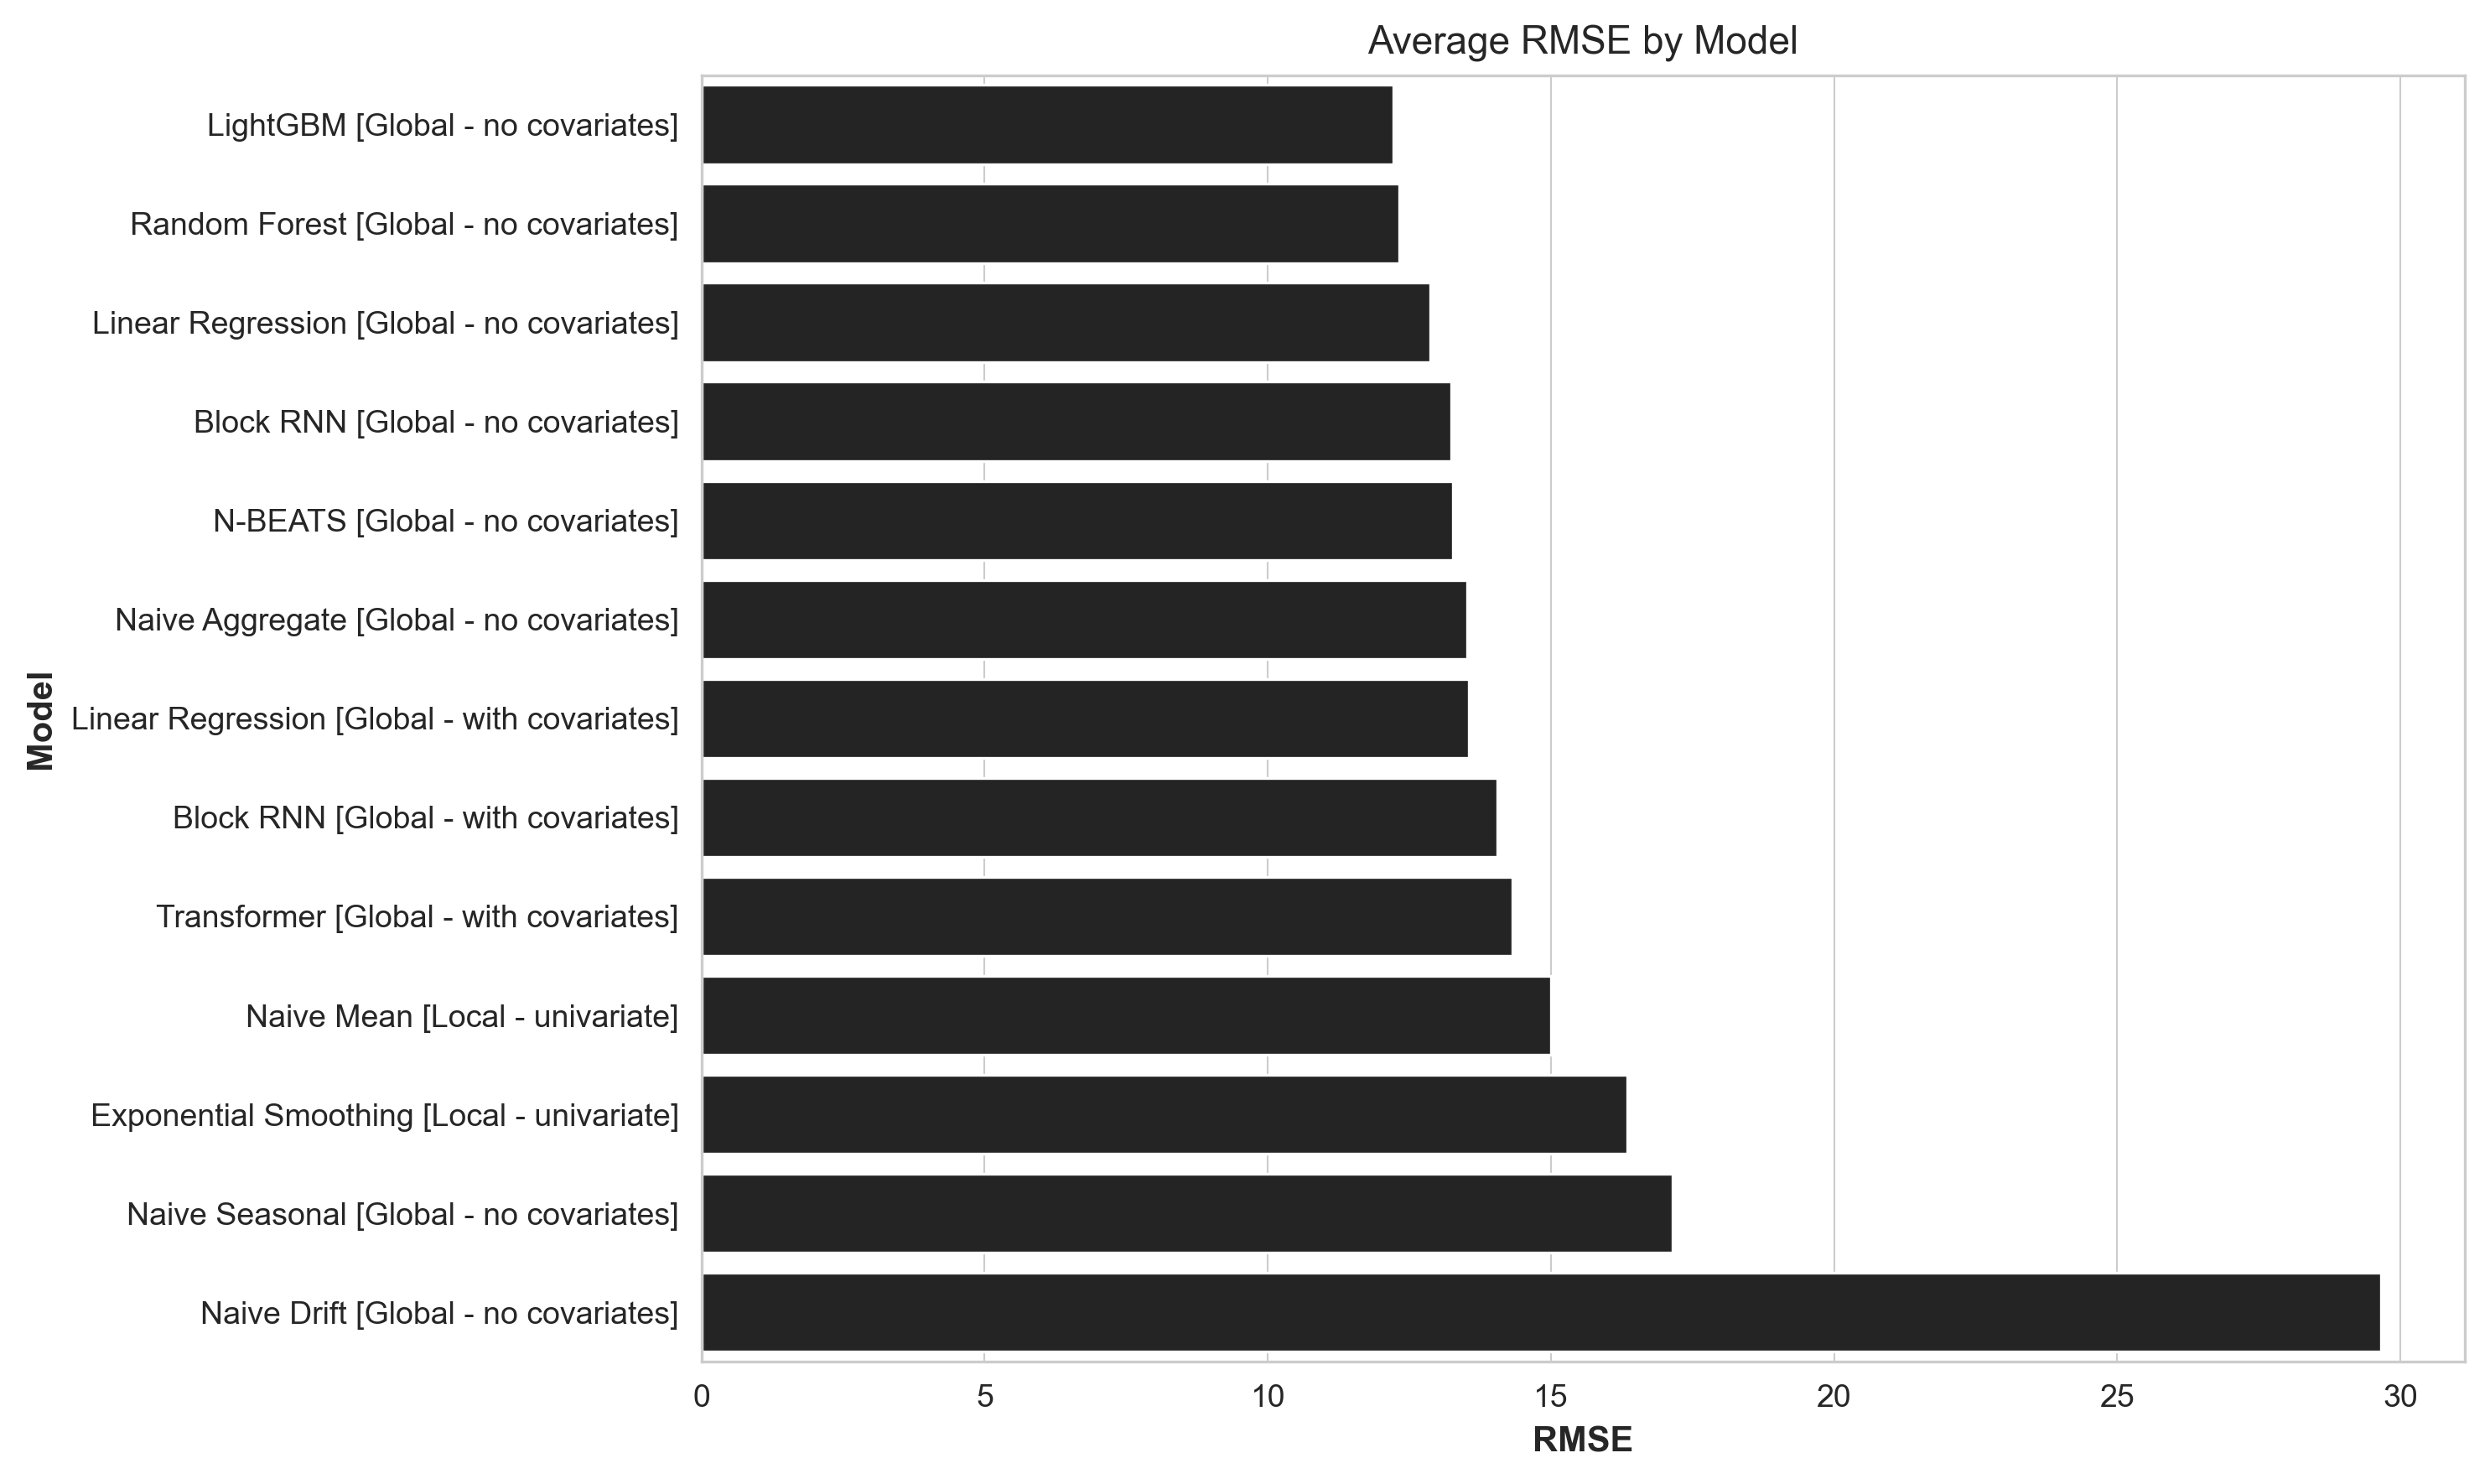

In [171]:
# Gráfico 1: RMSE por modelo completo (já contém distinção entre com e sem covariáveis)
plt.figure(figsize=(10, 6))
df_sorted = latex_df.sort_values('Average RMSE')
sns.barplot(
    x='Average RMSE',
    y='Model',
    data=df_sorted,
)
plt.title('Average RMSE by Model')
plt.xlabel('RMSE')
plt.ylabel('Model')
plt.tight_layout()
# plt.show()
plt.savefig("avg_rmse_barplot.png")

# # Gráfico 2A: Tempo de treinamento por modelo
# plt.figure(figsize=(10, 6))
# df_sorted_train = latex_df.sort_values('Training Time (s)', ascending=False)
# sns.barplot(
#     x='Training Time (s)',
#     y='Model',
#     data=df_sorted_train,
#     palette='Blues_d'
# )
# plt.title('Training Time by Model')
# plt.xlabel('Training Time (s)')
# plt.ylabel('Model')
# plt.tight_layout()
# plt.show()

# # Gráfico 2B: Tempo de previsão histórica por modelo
# plt.figure(figsize=(10, 6))
# df_sorted_forecast = latex_df.sort_values('Historical Forecast Time (s)', ascending=False)
# sns.barplot(
#     x='Historical Forecast Time (s)',
#     y='Model',
#     data=df_sorted_forecast,
#     palette='Greens_d'
# )
# plt.title('Historical Forecast Time by Model')
# plt.xlabel('Forecast Time (s)')
# plt.ylabel('Model')
# plt.tight_layout()
# plt.show()


In [166]:
print(latex_df)

                                           Model  Training Time (s)  \
0              LightGBM [Global - no covariates]           1.647542   
1         Random Forest [Global - no covariates]          58.788578   
2     Linear Regression [Global - no covariates]           0.057943   
3             Block RNN [Global - no covariates]        7473.547832   
4               N-BEATS [Global - no covariates]       28122.076157   
5       Naive Aggregate [Global - no covariates]           0.007150   
6   Linear Regression [Global - with covariates]           0.365621   
7           Block RNN [Global - with covariates]        5820.936550   
8         Transformer [Global - with covariates]       21877.557532   
9                Naive Mean [Local - univariate]           0.000027   
10    Exponential Smoothing [Local - univariate]           0.003098   
11       Naive Seasonal [Global - no covariates]           0.007450   
12          Naive Drift [Global - no covariates]           0.007202   

    H

In [167]:
from matplotlib.colors import LogNorm # Importar para a escala de cor logarítmica

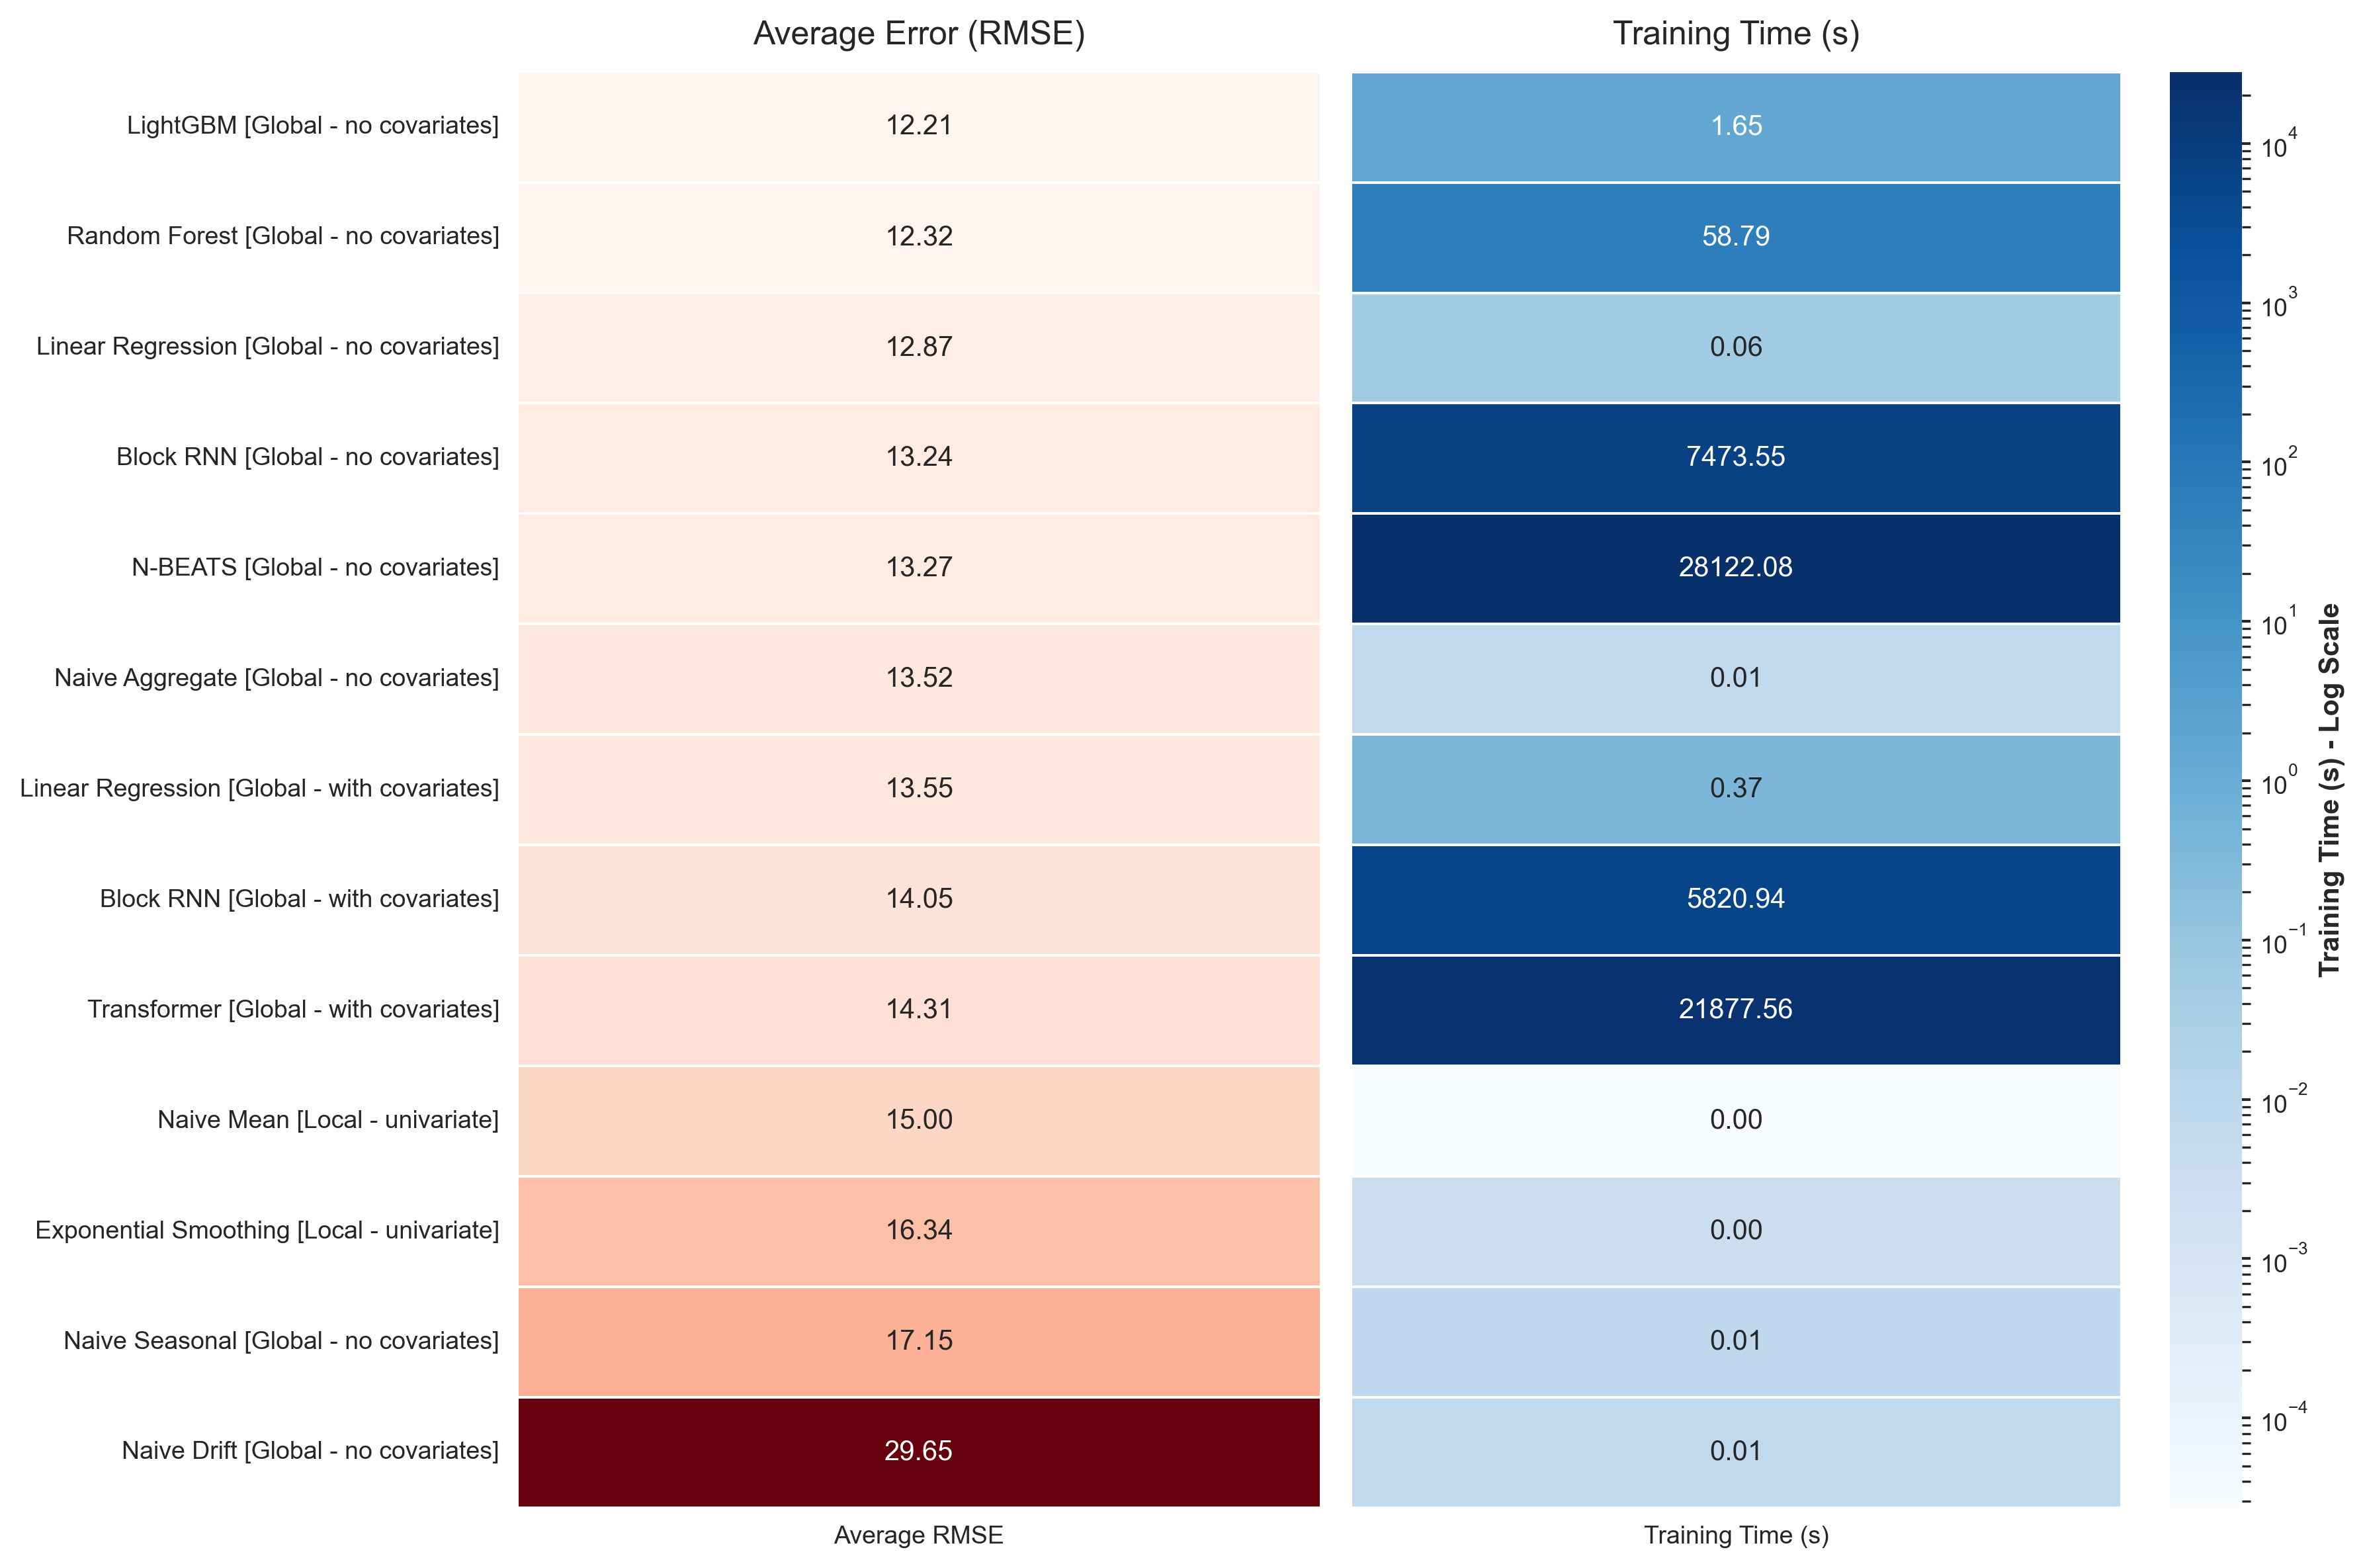

In [176]:
df_plot = latex_df.set_index('Model')[['Average RMSE', 'Training Time (s)']]

# Sort models by RMSE for a clearer visualization (best models at the top)
df_plot = df_plot.sort_values(by='Average RMSE', ascending=True)


# --- 3. Create the Visualization ---
# Create a figure with 2 subplots side-by-side
fig, (ax1, ax2) = plt.subplots(
    nrows=1, 
    ncols=2, 
    figsize=(12, 8), # Increased figure width to accommodate long labels
    gridspec_kw={'width_ratios': [1, 1.2]}
)

# General title for the figure
# fig.suptitle('Performance Analysis: Error vs. Computational Cost', fontsize=16, y=1.02)

# --- Plot 1: Average RMSE ---
sns.heatmap(
    df_plot[['Average RMSE']],
    ax=ax1,
    annot=True, # Show the numbers inside the cells
    fmt=".2f",  # Format with 2 decimal places
    cmap="Reds", # Color palette (red for larger errors)
    linewidths=.5,
    linecolor='white',
    cbar=False # Hide the color bar for this plot
)
ax1.set_title('Average Error (RMSE)', fontsize=12, pad=10)
ax1.set_ylabel('') # The y-axis labels are now the full model names from the index
ax1.set_xlabel('') # Remove X-axis label

# --- Plot 2: Training Time (s) ---
sns.heatmap(
    df_plot[['Training Time (s)']],
    ax=ax2,
    annot=True,
    fmt=".2f",
    cmap="Blues", # Different color palette for time
    linewidths=.5,
    linecolor='white',
    # HERE IS THE MAGIC: Use a logarithmic scale for the color
    norm=LogNorm(),
    yticklabels=False, # Hide model names to avoid repetition
    cbar_kws={'label': 'Training Time (s) - Log Scale'}
)
ax2.set_title('Training Time (s)', fontsize=12, pad=10)
ax2.set_ylabel('') # Remove Y-axis label
ax2.set_xlabel('') # Remove X-axis label


# Adjust layout to prevent long labels from being cut off
plt.tight_layout(rect=[0, 0, 1, 1])


plt.savefig(
    "perf_analys.png",  # Nome do arquivo
    dpi=300,  # Alta resolução para qualidade de publicação
    bbox_inches='tight' # O parâmetro mais importante: garante que nada seja cortado
)

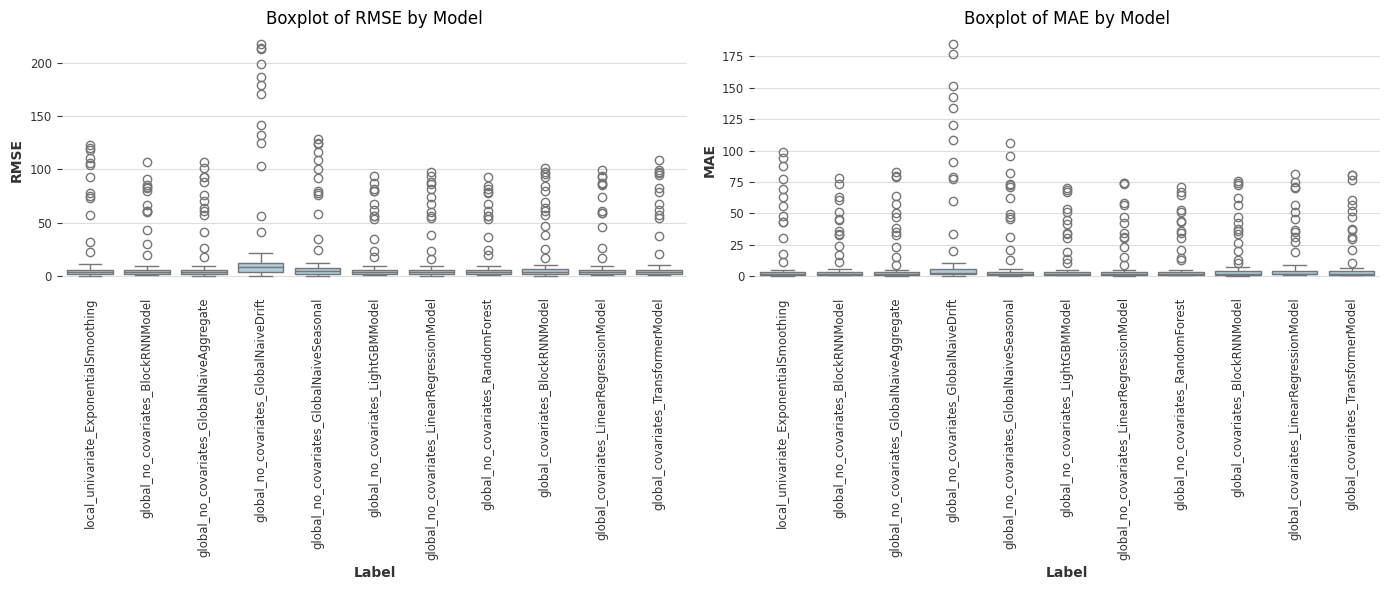

In [137]:
# Caminhos das pastas
local_univariate_path = os.path.join(os.pardir, "data", "results", "local_univariate")
global_no_covariates_path = os.path.join(os.pardir, "data", "results", "global_no_covariates")
global_covariates_path = os.path.join(os.pardir, "data", "results", "global_covariates")

# Lista com todos os caminhos
all_paths = [local_univariate_path, global_no_covariates_path, global_covariates_path]

# Junta todas as métricas em um único DataFrame
all_metrics_df = pd.concat(
    [collect_metrics_df_from_folder(p) for p in all_paths],
    ignore_index=True
)

# Junta Model + Folder para uma label única no gráfico
all_metrics_df['Label'] = all_metrics_df['Folder'] + "_" + all_metrics_df['Model']

# Plot dos boxplots
plt.figure(figsize=(14, 6))

# RMSE
plt.subplot(1, 2, 1)
sns.boxplot(x='Label', y='RMSE', data=all_metrics_df)
plt.xticks(rotation=90)
plt.title("Boxplot of RMSE by Model")
plt.tight_layout()

# MAE
plt.subplot(1, 2, 2)
sns.boxplot(x='Label', y='MAE', data=all_metrics_df)
plt.xticks(rotation=90)
plt.title("Boxplot of MAE by Model")
plt.tight_layout()

plt.show()

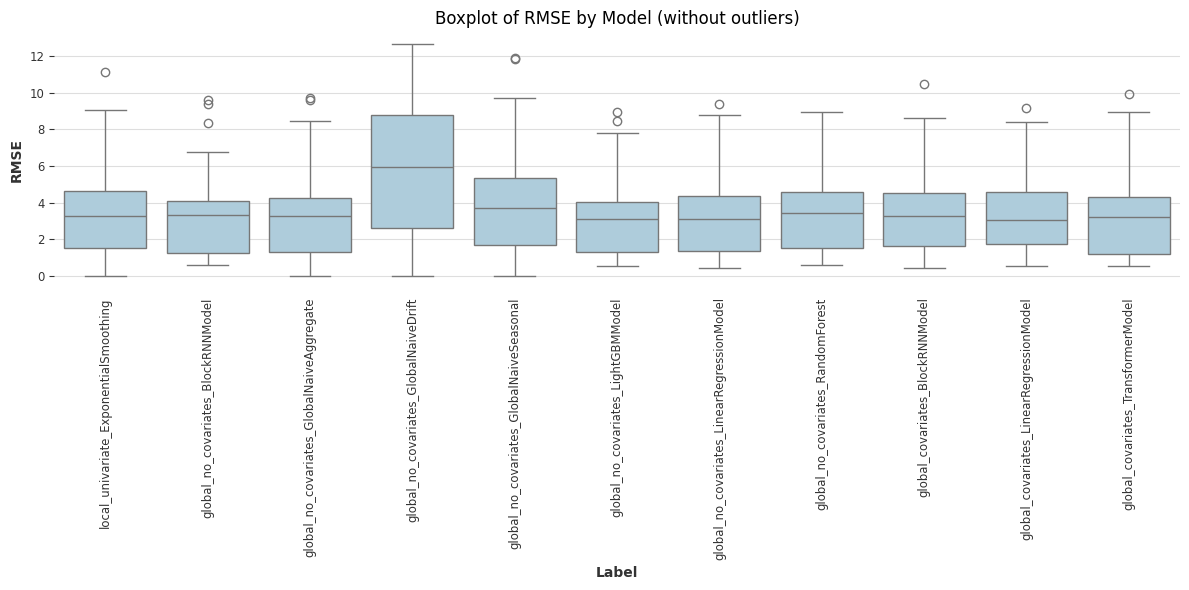

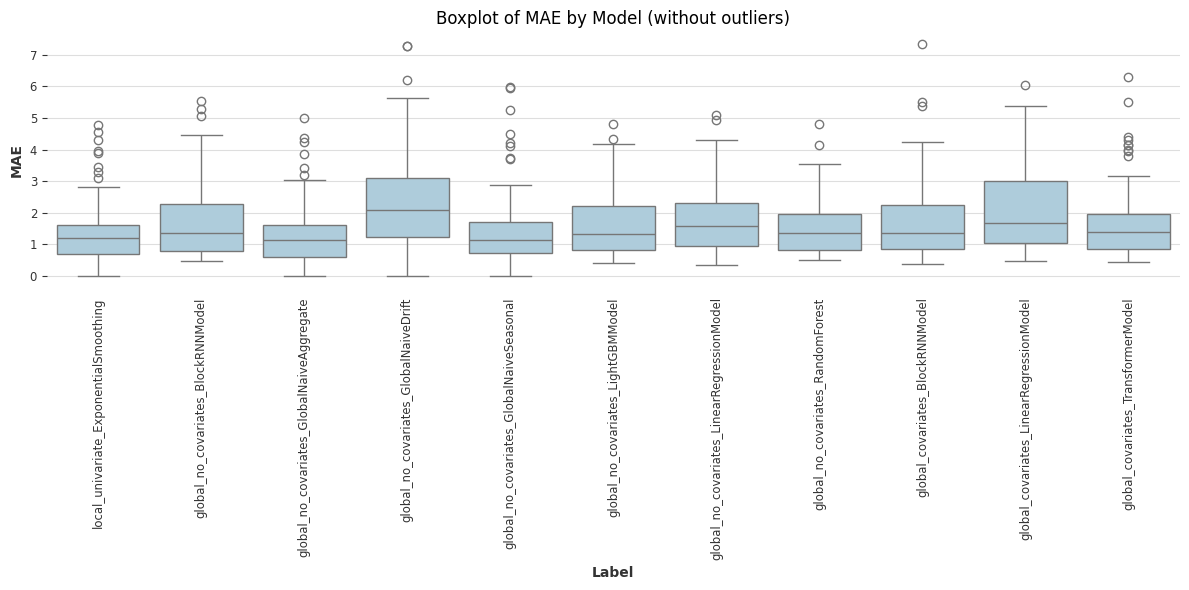

In [138]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers de RMSE e MAE separadamente
df_rmse_filtered = remove_outliers_iqr(all_metrics_df, 'RMSE')
df_mae_filtered = remove_outliers_iqr(all_metrics_df, 'MAE')

# Boxplot de RMSE sem outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_rmse_filtered, x='Label', y='RMSE')
plt.xticks(rotation=90)
plt.title('Boxplot of RMSE by Model (without outliers)')
plt.tight_layout()
plt.show()

# Boxplot de MAE sem outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_mae_filtered, x='Label', y='MAE')
plt.xticks(rotation=90)
plt.title('Boxplot of MAE by Model (without outliers)')
plt.tight_layout()
plt.show()

In [139]:
# Calcular a média já removendo outliers
df_filtered = all_metrics_df[
    (all_metrics_df['RMSE'].between(df_rmse_filtered['RMSE'].min(), df_rmse_filtered['RMSE'].max())) &
    (all_metrics_df['MAE'].between(df_mae_filtered['MAE'].min(), df_mae_filtered['MAE'].max()))
]

ranking_table = (
    df_filtered
    .groupby('Label')[['MAE', 'RMSE']]
    .mean()
    .sort_values(by='RMSE')
    .reset_index()
)

ranking_table

Label       MAE      RMSE
0           global_no_covariates_LightGBMModel  1.614793  3.139462
1    global_no_covariates_GlobalNaiveAggregate  1.359916  3.242534
2           global_no_covariates_BlockRNNModel  1.750546  3.276404
3           global_covariates_TransformerModel  1.739252  3.284241
4   global_no_covariates_LinearRegressionModel  1.796770  3.300636
5            global_no_covariates_RandomForest  1.617033  3.340439
6      global_covariates_LinearRegressionModel  2.088384  3.413882
7              global_covariates_BlockRNNModel  1.737049  3.422913
8        local_univariate_ExponentialSmoothing  1.416914  3.505309
9     global_no_covariates_GlobalNaiveSeasonal  1.546234  4.003316
10       global_no_covariates_GlobalNaiveDrift  2.124012  5.658857

In [140]:
# file_path = os.path.join(split_90_path, "LSTM_driving_down_RSRP.parquet")
# # Read the Parquet file and add it to the DataFrame
# test_df = pd.read_parquet(file_path)
# test_df = test_df.reset_index(drop=True)
# test_df

In [141]:
# sample_idx = 0

# dates_0 = pd.DatetimeIndex(test_df["Train_index"][sample_idx])
# values_0 = test_df["Train_values"][sample_idx]
# train_ts = TimeSeries.from_times_and_values(dates_0, values_0)

# dates_1 = pd.DatetimeIndex(test_df["Actuals_index"][sample_idx])
# values_1 = test_df["Actuals_values"][sample_idx]
# actual_ts = TimeSeries.from_times_and_values(dates_1, values_1)

# dates_2 = pd.DatetimeIndex(test_df["Preds_index"][sample_idx])
# values_2 = test_df["Preds_values"][sample_idx]
# preds_ts = TimeSeries.from_times_and_values(dates_2, values_2)

# train_ts.plot(label="Train")
# actual_ts.plot(label="Actual")
# preds_ts.plot(label="Preds")

In [142]:
# print(f"treino: {len(train_ts)}")
# print(f"test: {len(actual_ts)}")
# print(f"representação: {(len(actual_ts) / len(train_ts)) * 100}")

# Resultados Antigos:

Calculando todas as métricas do estudo para um resultado salvo:

In [143]:
compare_series_metrics(test_df)

NameError: name 'compare_series_metrics' is not defined

Lendo todos os resultados baselines:

In [ ]:
dfs = []
folder = os.path.join(folder_path, "no_window")
for file in os.listdir(folder):
    if file.endswith(".parquet"):
        # Create the full path of the file
        file_path = os.path.join(folder, file)
        # Read the Parquet file and add it to the DataFrame
        mult_df = pd.read_parquet(file_path)
        dfs.append(mult_df)

all_baselines_results = pd.concat(dfs)

# Liberar memoria
del dfs

all_baselines_results = all_baselines_results.reset_index(drop=True)

In [ ]:
all_baselines_results

target      Activity  Model  Elapsed_time  \
0       CQI  driving_down  ARIMA      0.440737   
1       CQI  driving_down  ARIMA      0.585396   
2       CQI  driving_down  ARIMA      0.454873   
3       CQI  driving_down  ARIMA      0.373832   
4       CQI  driving_down  ARIMA      0.487376   
...     ...           ...    ...           ...   
4766    SNR   static_strm  Theta      0.033813   
4767    SNR   static_strm  Theta      0.032202   
4768    SNR   static_strm  Theta      0.017622   
4769    SNR   static_strm  Theta      0.030446   
4770    SNR   static_strm  Theta      0.013587   

                                            Train_index  \
0     [2020-02-14T09:38:22.000000000, 2020-02-14T09:...   
1     [2020-02-14T07:29:00.000000000, 2020-02-14T07:...   
2     [2020-01-16T07:26:43.000000000, 2020-01-16T07:...   
3     [2020-01-16T12:10:03.000000000, 2020-01-16T12:...   
4     [2020-01-16T09:56:56.000000000, 2020-01-16T09:...   
...                                                 ...   
4766  [2019-12-23T10:30:35.000000000, 2019-12-23T10:...   
4767  [2020-01-06T11:40:29.000000000, 2020-01-06T11:...   
4768  [2019-12-19T15:00:47.000000000, 2019-12-19T15:...   
4769  [2019-12-06T09:55:13.000000000, 2019-12-06T09:...   
4770  [2019-11-26T09:27:10.000000000, 2019-11-26T09:...   

                                           Train_values  \
0     [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 9.0...   
1     [10.0, 10.0, 12.0, 14.0, 11.0, 11.0, 14.0, 14....   
2     [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 11.0,...   
3     [9.0, 9.0, 11.999999999999998, 11.0, 11.0, 11....   
4     [11.0, 11.0, 13.0, 13.0, 13.0, 11.0, 9.0, 11.0...   
...                                                 ...   
4766  [0.9999999999999994, 0.9999999999999994, 0.0, ...   
4767  [-5.999999999999999, -0.49999999999999956, 5.0...   
4768  [-4.0, -4.0, -2.0000000000000004, -2.000000000...   
4769  [3.999999999999999, 10.999999999999998, 1.9999...   
4770  [0.0, 0.0, -1.9999999999999996, -1.99999999999...   

                                          Actuals_index  \
0     [2020-02-14T10:06:51.000000000, 2020-02-14T10:...   
1     [2020-02-14T08:06:41.000000000, 2020-02-14T08:...   
2     [2020-01-16T08:01:23.000000000, 2020-01-16T08:...   
3     [2020-01-16T12:16:20.000000000, 2020-01-16T12:...   
4     [2020-01-16T10:27:11.000000000, 2020-01-16T10:...   
...                                                 ...   
4766  [2019-12-23T12:36:15.000000000, 2019-12-23T12:...   
4767  [2020-01-06T13:37:35.000000000, 2020-01-06T13:...   
4768  [2019-12-19T15:41:55.000000000, 2019-12-19T15:...   
4769  [2019-12-06T11:43:37.000000000, 2019-12-06T11:...   
4770  [2019-11-26T09:49:22.000000000, 2019-11-26T09:...   

                                         Actuals_values  \
0     [11.0, 11.0, 11.0, 14.0, 14.0, 8.0, 8.0, 12.0,...   
1     [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...   
2     [6.0, 6.0, 7.5, 9.0, 9.0, 10.0, 10.0, 9.0, 9.0...   
3     [4.0, 4.0, 10.0, 10.0, 14.0, 14.0, 14.0, 13.5,...   
4     [10.0, 10.0, 12.0, 12.0, 11.0, 11.0, 12.0, 10....   
...                                                 ...   
4766  [-1.0, -1.0, 1.0, 1.0, 3.0, 3.0, 4.0, 4.0, -1....   
4767  [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ...   
4768  [0.0, 0.0, -1.0, -1.0, 0.0, 0.0, -3.0, -3.0, -...   
4769  [8.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, -2.0, -4.0...   
4770  [-1.0, -1.0, -6.0, -6.0, 0.0, 0.0, -2.0, -2.0,...   

                                            Preds_index  \
0     [2020-02-14T10:06:51.000000000, 2020-02-14T10:...   
1     [2020-02-14T08:06:41.000000000, 2020-02-14T08:...   
2     [2020-01-16T08:01:23.000000000, 2020-01-16T08:...   
3     [2020-01-16T12:16:20.000000000, 2020-01-16T12:...   
4     [2020-01-16T10:27:11.000000000, 2020-01-16T10:...   
...                                                 ...   
4766  [2019-12-23T12:36:15.000000000, 2019-12-23T12:...   
4767  [2020-01-06T13:37:35.000000000, 2020-01-06T13:...   
4768  [2019-12-19T15:41:55.000000000,

### Processando métricas

In [ ]:
# df = process_results_parquet(folder_path)

In [ ]:
df_metrics = compare_series_metrics(all_baselines_results)

In [ ]:
df_metrics

In [ ]:
# Verifica se o arquivo já existe antes de salvar
metrics_path = os.path.join(os.pardir, "data", "last_metrics_univariate.parquet")
if not os.path.exists(metrics_path):
    try:
        os.makedirs(os.path.dirname(metrics_path), exist_ok=True)
        df_metrics.to_parquet(metrics_path, compression="gzip")
        print(f"Arquivo salvo em: {metrics_path}")
    except Exception as e:
        print(f"Não foi possível salvar: {e}")
else:
    print("Arquivo já existe. Nenhuma ação necessária.")

In [ ]:
# Lê o arquivo salvo e associa a df_metrics
metrics_path = os.path.join(os.pardir, "data", "last_metrics_univariate.parquet")
try:
    df_metrics = pd.read_parquet(metrics_path)
    print("Arquivo carregado com sucesso.")
except Exception as e:
    print(f"Não foi possível carregar o arquivo: {e}")

Arquivo carregado com sucesso.


In [ ]:
df_metrics.columns

Index(['target', 'Activity', 'Model', 'Elapsed_time', 'Train_index',
       'Train_values', 'Actuals_index', 'Actuals_values', 'Preds_index',
       'Preds_values', 'MAE', 'RMSE', 'MSE', 'NRMSE', 'NMSE'],
      dtype='object')

In [ ]:
print(df_metrics[["Model", "target", "Activity", "MAE", "RMSE", "MSE", "Elapsed_time"]])

      Model target      Activity           MAE          RMSE           MSE  \
0     ARIMA    CQI  driving_down  2.062690e+00  2.547199e+00  6.488222e+00   
1     ARIMA    CQI  driving_down  7.456843e-05  7.699854e-05  5.928776e-09   
2     ARIMA    CQI  driving_down  1.095137e+00  1.230567e+00  1.514295e+00   
3     ARIMA    CQI  driving_down  3.293019e+00  4.446660e+00  1.977279e+01   
4     ARIMA    CQI  driving_down  1.051347e+00  1.276120e+00  1.628481e+00   
...     ...    ...           ...           ...           ...           ...   
4766  Theta    SNR   static_strm  1.800000e+00  2.049390e+00  4.200000e+00   
4767  Theta    SNR   static_strm  1.332268e-15  1.332268e-15  1.774937e-30   
4768  Theta    SNR   static_strm  2.200000e+00  2.489980e+00  6.200000e+00   
4769  Theta    SNR   static_strm  7.400000e+00  8.124038e+00  6.600000e+01   
4770  Theta    SNR   static_strm  3.200000e+00  3.794733e+00  1.440000e+01   

      Elapsed_time  
0         0.440737  
1         0.585396  


In [ ]:
def aggregate_median_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Função para calcular a mediana e o desvio padrão de MAE, RMSE, MSE, NRMSE, NMSE e Elapsed_time,
    agrupando por Model, target e Activity.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo os dados com as colunas 'Model', 'target', 'Activity', 'MAE', 'RMSE', 'MSE', 'NRMSE', 'NMSE', 'Elapsed_time'.

    Retorna:
    pd.DataFrame: DataFrame agregado contendo as medianas e desvios padrões das métricas MAE, RMSE, MSE, NRMSE, NMSE e Elapsed_time por Model, target e Activity.
    """

    # Verificar se as colunas necessárias estão presentes no DataFrame
    required_columns = [
        "Model",
        "target",
        "Activity",
        "MAE",
        "RMSE",
        "MSE",
        "NRMSE",
        "NMSE",
        "Elapsed_time",
    ]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Coluna {col} está ausente no DataFrame")

    # Agrupar por Model, target e Activity e calcular as medianas e desvios padrões das métricas
    aggregated_df = df.groupby(["Model", "target", "Activity"], as_index=False).agg(
        {
            "MAE": ["median", "std"],
            "RMSE": ["median", "std"],
            "MSE": ["median", "std"],
            "NRMSE": ["median", "std"],
            "NMSE": ["median", "std"],
            "Elapsed_time": ["median", "std"],
        }
    )

    # Renomear as colunas agregadas para refletir que são medianas e desvios padrões
    aggregated_df.columns = [
        "Model",
        "target",
        "Activity",
        "MAE_Median",
        "MAE_Std",
        "RMSE_Median",
        "RMSE_Std",
        "MSE_Median",
        "MSE_Std",
        "NRMSE_Median",
        "NRMSE_Std",
        "NMSE_Median",
        "NMSE_Std",
        "Elapsed_time_Median",
        "Elapsed_time_Std",
    ]

    return aggregated_df


In [ ]:
agg_data = aggregate_median_metrics(df_metrics)
agg_data

Model target      Activity  MAE_Median   MAE_Std  RMSE_Median  RMSE_Std  \
0    ARIMA    CQI  driving_down    1.051347  1.452191     1.230567  1.682713   
1    ARIMA    CQI  driving_strm    1.099634  0.872707     1.338507  0.949534   
2    ARIMA    CQI   static_down    1.638648  0.623804     2.083270  0.565967   
3    ARIMA    CQI   static_strm    1.771262  1.643209     2.024151  1.705783   
4    ARIMA   RSRP  driving_down    1.953854  5.834727     2.452317  5.956716   
..     ...    ...           ...         ...       ...          ...       ...   
255  Theta   RSSI   static_strm    1.400000  0.838307     1.713642  0.922804   
256  Theta    SNR  driving_down    2.150000  2.713813     3.240370  3.128480   
257  Theta    SNR  driving_strm    2.942161  2.477703     3.627229  2.946956   
258  Theta    SNR   static_down    2.800000  0.752256     3.130495  1.326487   
259  Theta    SNR   static_strm    3.100000  2.019318     3.859508  2.226633   

     MSE_Median     MSE_Std  NRMSE_Median  NRMSE_Std  NMSE_Median   NMSE_Std  \
0      1.514295    7.789848      0.425373   0.261253     1.400091   1.574943   
1      1.791600    3.125714      0.484679   0.437017     1.510677   6.267386   
2      4.340016    2.229463      0.454357   0.119711     1.126037   1.125664   
3      4.097853   11.563849      0.512483   0.961910     1.682651  17.693562   
4      6.158815  157.646631      0.681283   0.254912     3.583107   3.962339   
..          ...         ...           ...        ...          ...        ...   
255    2.936570    3.178439      0.489152   0.257751     1.317519   2.317753   
256   10.500000   26.849436      0.558967   0.200975     1.997264   1.697099   
257   13.156791   38.096828      0.485913   0.132040     1.740741   1.741704   
258    9.800000   11.522169      0.492654   0.092303     1.926681   0.980104   
259   14.900000   17.755514      0.562183   0.160220     2.406250   1.827870   

     Elapsed_time_Median  Elapsed_time_Std  
0               0.554192          0.118353  
1               0.394558          0.268641  
2               1.188532          0.585635  
3               1.120122          0.789955  
4               0.315773          0.335697  
..                   ...               ...  
255             0.019041          0.006879  
256             0.016824          0.002979  
257             0.014189          0.003643  
258             0.020684          0.006872  
259             0.022613          0.007456  

[260 rows x 15 columns]

In [ ]:
agg_data.columns

Index(['Model', 'target', 'Activity', 'MAE_Median', 'MAE_Std', 'RMSE_Median',
       'RMSE_Std', 'MSE_Median', 'MSE_Std', 'NRMSE_Median', 'NRMSE_Std',
       'NMSE_Median', 'NMSE_Std', 'Elapsed_time_Median', 'Elapsed_time_Std'],
      dtype='object')

In [ ]:
# Filtrando as tabelas para cada atividade e renomeando a coluna
table_driving_down = (
    agg_data.query("target == 'RSRP' and Activity == 'driving_down'")
    .loc[
        :,
        [
            "Model",
            "target",
            "Activity",
            "NRMSE_Median",
            "NRMSE_Std",
            "Elapsed_time_Median",
        ],
    ]
    .drop(columns=["target", "Activity"])
)

table_driving_strm = (
    agg_data.query("target == 'RSRP' and Activity == 'driving_strm'")
    .loc[
        :,
        [
            "Model",
            "target",
            "Activity",
            "NRMSE_Median",
            "NRMSE_Std",
            "Elapsed_time_Median",
        ],
    ]
    .drop(columns=["target", "Activity"])
)

table_static_down = (
    agg_data.query("target == 'RSRP' and Activity == 'static_down'")
    .loc[
        :,
        [
            "Model",
            "target",
            "Activity",
            "NRMSE_Median",
            "NRMSE_Std",
            "Elapsed_time_Median",
        ],
    ]
    .drop(columns=["target", "Activity"])
)

table_static_strm = (
    agg_data.query("target == 'RSRP' and Activity == 'static_strm'")
    .loc[
        :,
        [
            "Model",
            "target",
            "Activity",
            "NRMSE_Median",
            "NRMSE_Std",
            "Elapsed_time_Median",
        ],
    ]
    .drop(columns=["target", "Activity"])
)

# Renomeando a coluna NRMSE_Median para NRMSE Median
table_driving_down = table_driving_down.rename(columns={"NRMSE_Median": "NRMSE Median"})
table_driving_strm = table_driving_strm.rename(columns={"NRMSE_Median": "NRMSE Median"})
table_static_down = table_static_down.rename(columns={"NRMSE_Median": "NRMSE Median"})
table_static_strm = table_static_strm.rename(columns={"NRMSE_Median": "NRMSE Median"})

# Aplicando destaque ao menor valor de NRMSE_Median em cada tabela
# highlight_min_value = lambda x: [
#     "background-color: green" if v == x.min() else "" for v in x
# ]

# # Aplicando o estilo nas tabelas
# table_driving_down = table_driving_down.style.apply(
#     highlight_min_value, subset=["NRMSE Median"]
# )
# table_driving_strm = table_driving_strm.style.apply(
#     highlight_min_value, subset=["NRMSE Median"]
# )
# table_static_down = table_static_down.style.apply(
#     highlight_min_value, subset=["NRMSE Median"]
# )
# table_static_strm = table_static_strm.style.apply(
#     highlight_min_value, subset=["NRMSE Median"]
# )


In [ ]:
# Exibindo as tabelas com destaque
display("Static Downloading")
table_static_down.sort_values(by=["NRMSE Median"])

'Static Downloading'

Model  NRMSE Median  NRMSE_Std  Elapsed_time_Median
146                 Naive      0.491904   0.082106             0.005551
246                 Theta      0.491904   0.082106             0.020728
166            NaiveDrift      0.495194   0.082060             0.005516
26   ExponentialSmoothing      0.495202   0.081952             0.142831
46                    FFT      0.504534   0.155733             0.011940
106      LinearRegression      0.567393   0.198279             0.018069
6                   ARIMA      0.614197   0.176182             0.805988
226               Prophet      0.687803   0.808094             0.774322
206    NaiveMovingAverage      0.736687   0.467349             0.006166
86               LightGBM      0.738970   0.273468             2.108920
66                   LSTM      0.818634   0.616153           172.524616
186             NaiveMean      0.867836   0.429753             0.005468
126                NBEATS      0.868074   0.426808           261.846135

In [ ]:
display("Static Streaming")
table_static_strm.sort_values(by=["NRMSE Median"])


'Static Streaming'

Model  NRMSE Median  NRMSE_Std  Elapsed_time_Median
87               LightGBM      0.500704   0.631538             2.211331
147                 Naive      0.523861   0.542112             0.005547
247                 Theta      0.523861   0.542107             0.021933
27   ExponentialSmoothing      0.524820   0.543973             0.153854
167            NaiveDrift      0.524859   0.543891             0.005516
207    NaiveMovingAverage      0.542001   0.310378             0.006265
107      LinearRegression      0.553427   0.566708             0.018162
227               Prophet      0.554739   0.295472             1.538593
7                   ARIMA      0.558453   0.543174             1.380913
67                   LSTM      0.578193   0.297315           189.879668
127                NBEATS      0.581550   0.505655           280.326002
47                    FFT      0.645333   1.081057             0.012618
187             NaiveMean      0.698247   1.770633             0.005434

In [ ]:
display("Driving Downloading")
table_driving_down.sort_values(by=["NRMSE Median"])

'Driving Downloading'

Model  NRMSE Median  NRMSE_Std  Elapsed_time_Median
104      LinearRegression      0.610180   0.453624             0.013892
4                   ARIMA      0.681283   0.254912             0.315773
144                 Naive      0.707107   0.270083             0.005345
244                 Theta      0.707107   0.270083             0.015081
24   ExponentialSmoothing      0.761173   0.271417             0.082850
164            NaiveDrift      0.762155   0.271401             0.005401
224               Prophet      0.900468   2.240158             0.724411
204    NaiveMovingAverage      0.916320   1.805351             0.006064
124                NBEATS      1.011674   1.984284           128.902143
84               LightGBM      1.075243   0.523544             2.066730
44                    FFT      1.247674   4.059434             0.011808
64                   LSTM      1.298062   1.076746            86.014521
184             NaiveMean      1.668081   6.361510             0.005366

In [ ]:
display("Driving Streaming")
table_driving_strm.sort_values(by=["NRMSE Median"])


'Driving Streaming'

Model  NRMSE Median  NRMSE_Std  Elapsed_time_Median
5                   ARIMA      0.574696   0.535212             0.535671
245                 Theta      0.582291   0.379752             0.014070
25   ExponentialSmoothing      0.588877   0.376157             0.072788
145                 Naive      0.602080   0.376980             0.005231
165            NaiveDrift      0.604899   0.371720             0.005307
105      LinearRegression      0.799192   0.779344             0.013488
205    NaiveMovingAverage      0.892219   2.849742             0.006076
65                   LSTM      0.918119   1.413529            71.078934
85               LightGBM      1.065057   1.150774             2.055939
125                NBEATS      1.163686   1.521800           101.844861
225               Prophet      1.853523   3.018239             0.556048
45                    FFT      2.386667   2.884379             0.011734
185             NaiveMean      3.127652   2.937668             0.005411

In [ ]:
# Remover o estilo e converter as tabelas de volta para DataFrame
table_driving_down_df = table_driving_down.data
table_driving_strm_df = table_driving_strm.data
table_static_down_df = table_static_down.data
table_static_strm_df = table_static_strm.data

# Exportando as tabelas em formato LaTeX
latex_driving_down = table_driving_down_df.to_latex(index=False)
latex_driving_strm = table_driving_strm_df.to_latex(index=False)
latex_static_down = table_static_down_df.to_latex(index=False)
latex_static_strm = table_static_strm_df.to_latex(index=False)

# Exibindo o LaTeX

print("Static Downloading", latex_static_down)
print("Static Streaming", latex_static_strm)
print("Driving Downloading", latex_driving_down)
print("Driving Streaming", latex_driving_strm)


Static Downloading \begin{tabular}{lr}
\toprule
Model & NRMSE Median \\
\midrule
ARIMA & 0.614197 \\
ExponentialSmoothing & 0.495202 \\
FFT & 0.504534 \\
LSTM & 0.818634 \\
LightGBM & 0.738970 \\
LinearRegression & 0.567393 \\
NBEATS & 0.868074 \\
Naive & 0.491904 \\
NaiveDrift & 0.495194 \\
NaiveMean & 0.867836 \\
NaiveMovingAverage & 0.736687 \\
Prophet & 0.687803 \\
Theta & 0.491904 \\
\bottomrule
\end{tabular}

Static Streaming \begin{tabular}{lr}
\toprule
Model & NRMSE Median \\
\midrule
ARIMA & 0.558453 \\
ExponentialSmoothing & 0.524820 \\
FFT & 0.645333 \\
LSTM & 0.578193 \\
LightGBM & 0.500704 \\
LinearRegression & 0.553427 \\
NBEATS & 0.581550 \\
Naive & 0.523861 \\
NaiveDrift & 0.524859 \\
NaiveMean & 0.698247 \\
NaiveMovingAverage & 0.542001 \\
Prophet & 0.554739 \\
Theta & 0.523861 \\
\bottomrule
\end{tabular}

Driving Downloading \begin{tabular}{lr}
\toprule
Model & NRMSE Median \\
\midrule
ARIMA & 0.681283 \\
ExponentialSmoothing & 0.761173 \\
FFT & 1.247674 \\
LSTM & 1.

In [ ]:
agg_data.query("Model == 'Naive'").groupby(
    ["Model", "target", "Activity"], as_index=True
).mean()

MAE_Median  RMSE_Median  MSE_Median  NRMSE_Median  \
Model target Activity                                                          
Naive CQI    driving_down       2.100     2.529822      6.4000      0.570088   
             driving_strm       0.700     1.000000      1.0000      0.612372   
             static_down        2.100     2.428992      5.9000      0.480885   
             static_strm        1.825     2.378380      5.6625      0.633690   
      RSRP   driving_down       1.950     2.451036      6.1500      0.707107   
             driving_strm       1.650     1.910453      3.6500      0.602080   
             static_down        0.450     0.790569      0.6250      0.491904   
             static_strm        0.950     1.224064      1.5000      0.523861   
      RSRQ   driving_down       0.900     1.140175      1.3000      0.570088   
             driving_strm       1.350     1.731087      3.0000      0.521536   
             static_down        0.900     1.264911      1.6000      0.441942   
             static_strm        1.350     1.638628      2.7000      0.505525   
      RSSI   driving_down       2.600     2.756810      7.6000      0.662571   
             driving_strm       1.200     1.673320      2.8000      0.595904   
             static_down        1.100     1.449138      2.1000      0.706886   
             static_strm        1.600     1.746425      3.0500      0.529675   
      SNR    driving_down       2.150     3.240370     10.5000      0.558967   
             driving_strm       2.950     3.636619     13.2250      0.485913   
             static_down        2.800     3.130495      9.8000      0.492654   
             static_strm        3.100     3.859508     14.9000      0.562183   

                           NMSE_Median  
Model target Activity                   
Naive CQI    driving_down     1.758530  
             driving_strm     2.500000  
             static_down      1.401425  
             static_strm      2.449952  
      RSRP   driving_down     3.571429  
             driving_strm     2.265625  
             static_down      1.854255  
             static_strm      1.406593  
      RSRQ   driving_down     2.068376  
             driving_strm     1.701245  
             static_down      1.666667  
             static_strm      1.840278  
      RSSI   driving_down     3.142857  
             driving_strm     2.359551  
             static_down      2.556587  
             static_strm      1.775044  
      SNR    driving_down     1.997264  
             driving_strm     1.740741  
             static_down      1.926681  
             static_strm      2.406250

In [ ]:
# Ideal é ter 20 entradas
agg_data.query("Model == 'Naive'").sort_values(
    by=["Activity", "target"], ascending=[True, False]
).reset_index(drop=True)

In [ ]:
agg_data.query("Model == 'LightGBM'").sort_values(
    by=["Activity", "target"], ascending=[True, True]
).reset_index(drop=True)

In [ ]:
agg_data.columns

Index(['Model', 'target', 'Activity', 'MAE_Median', 'RMSE_Median',
       'MSE_Median', 'NRMSE_Median', 'NMSE_Median'],
      dtype='object')

## Bar plots das médias.

Paleta de cores:

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


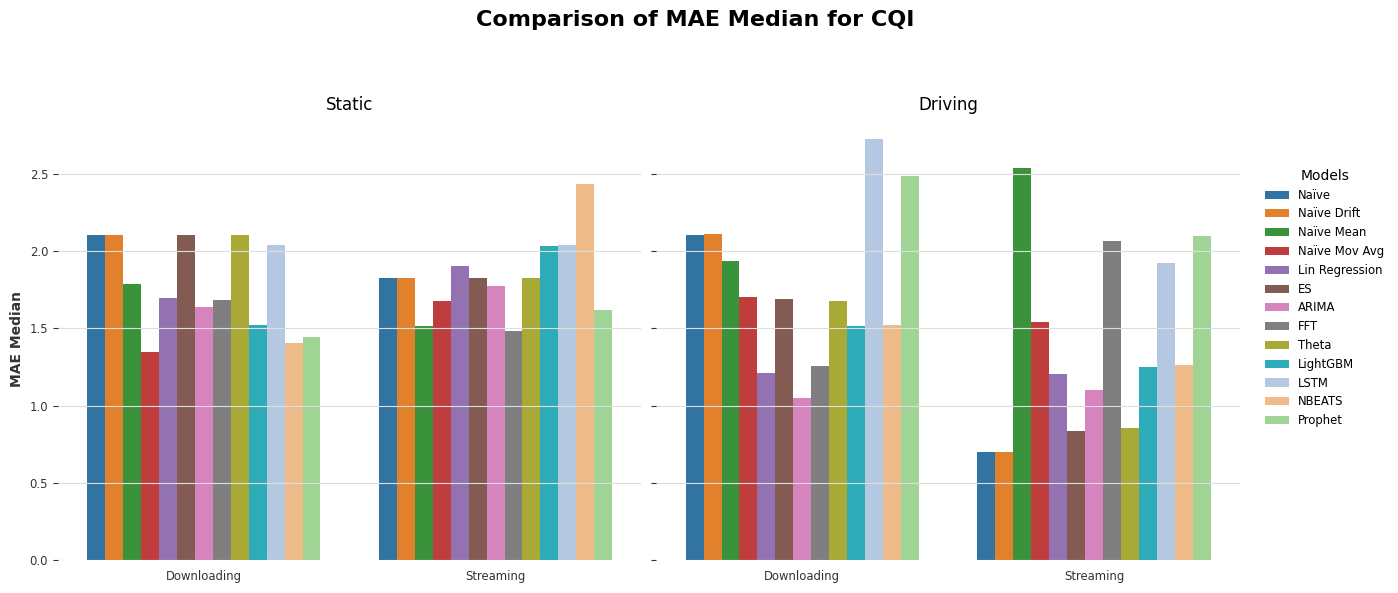

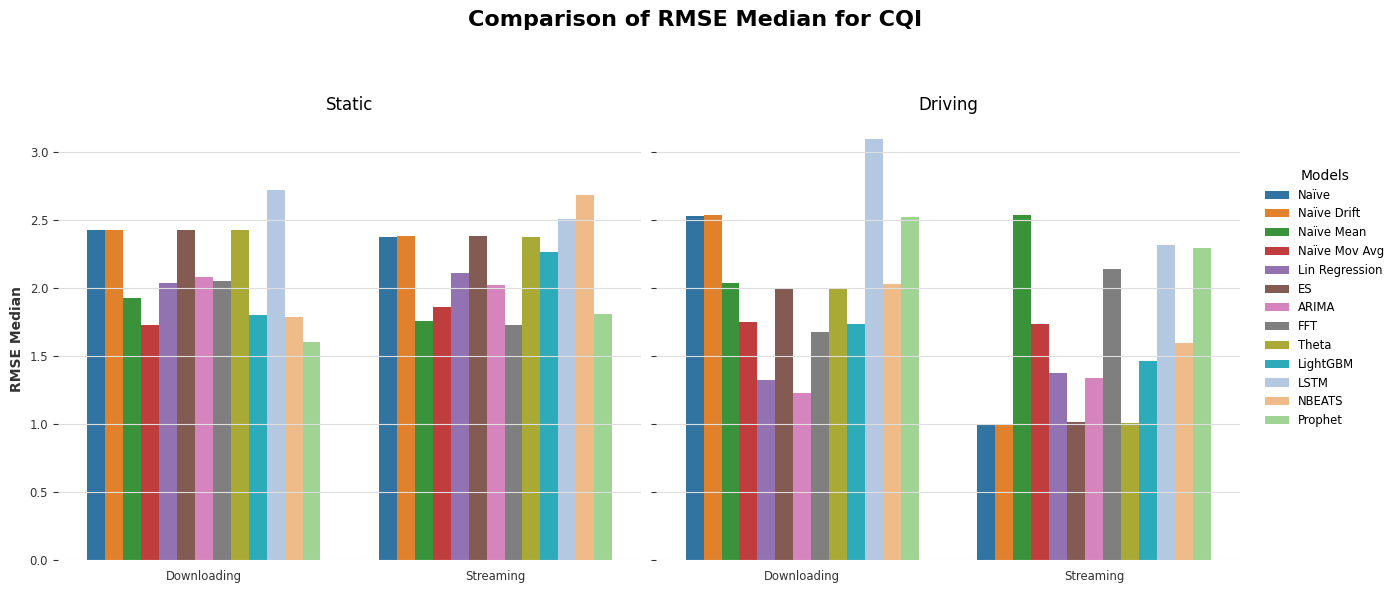

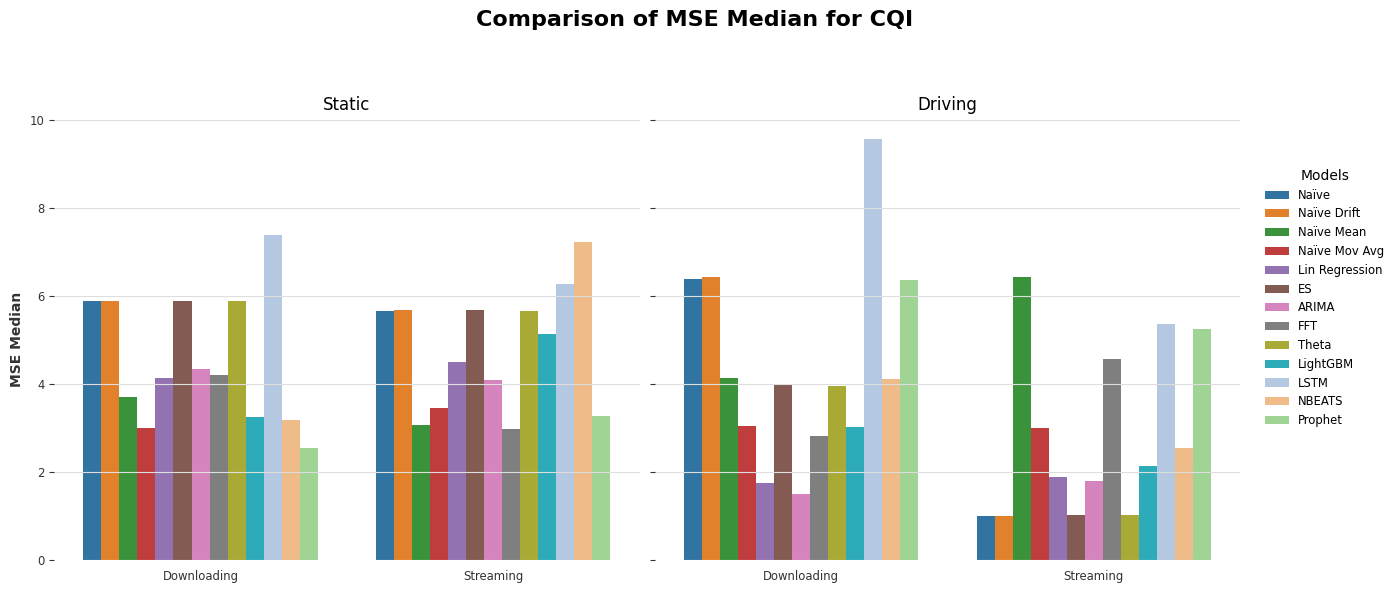

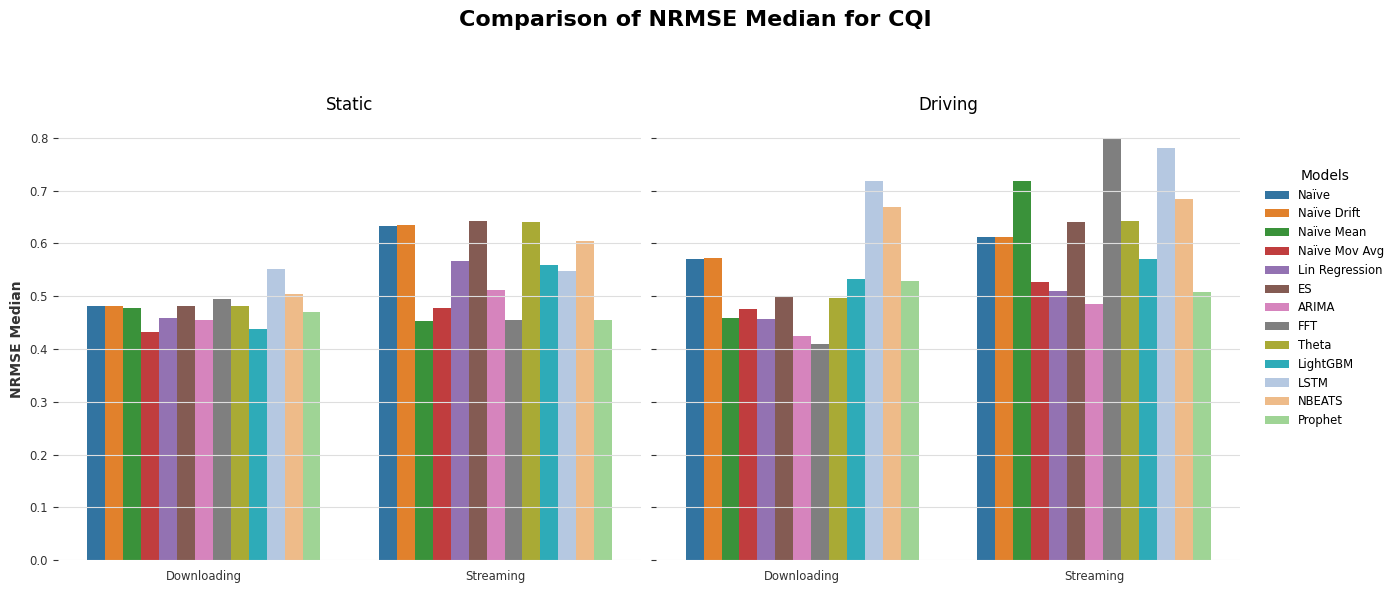

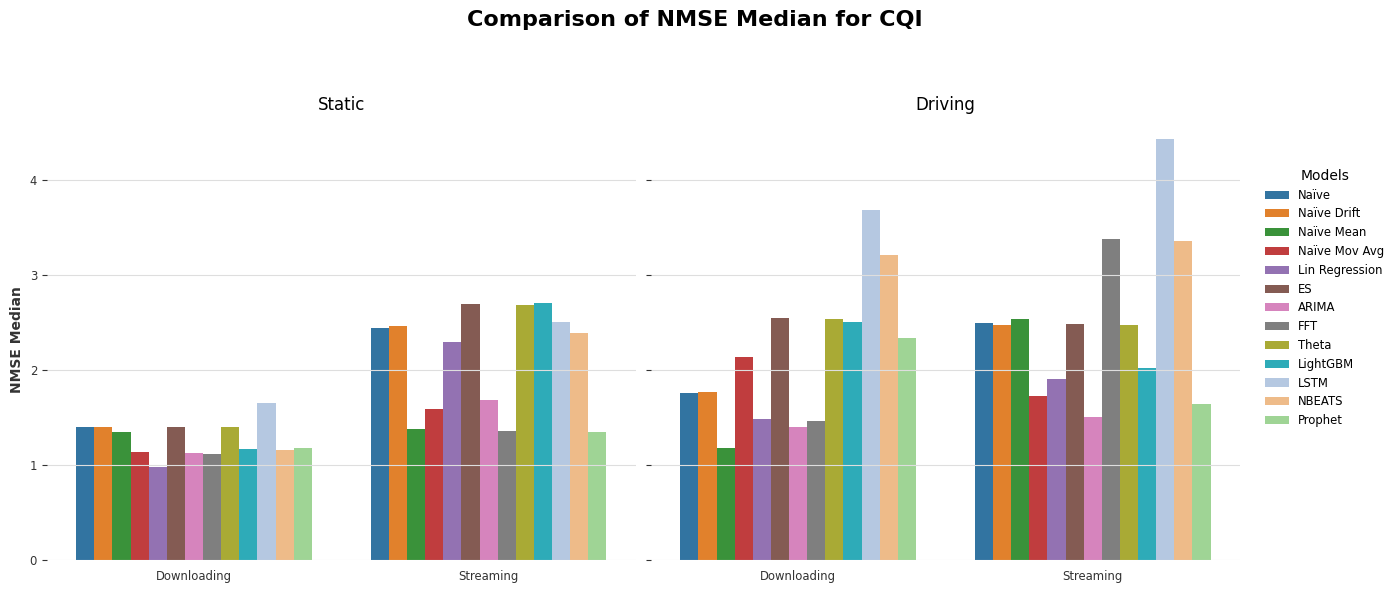

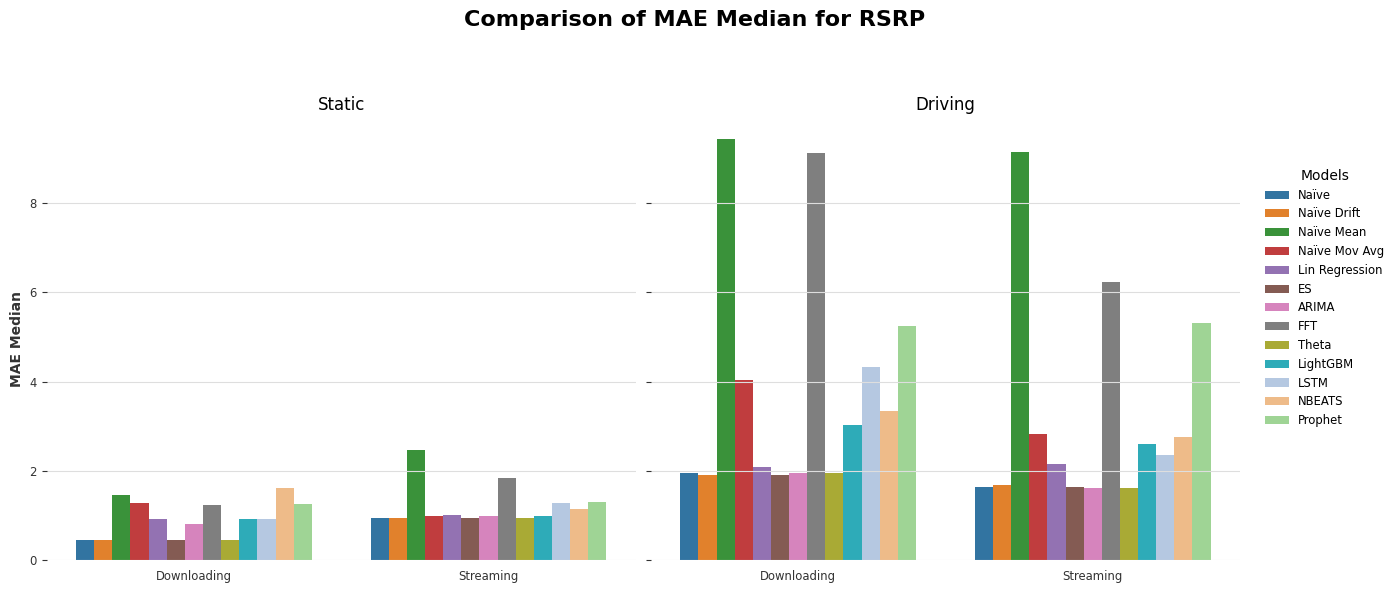

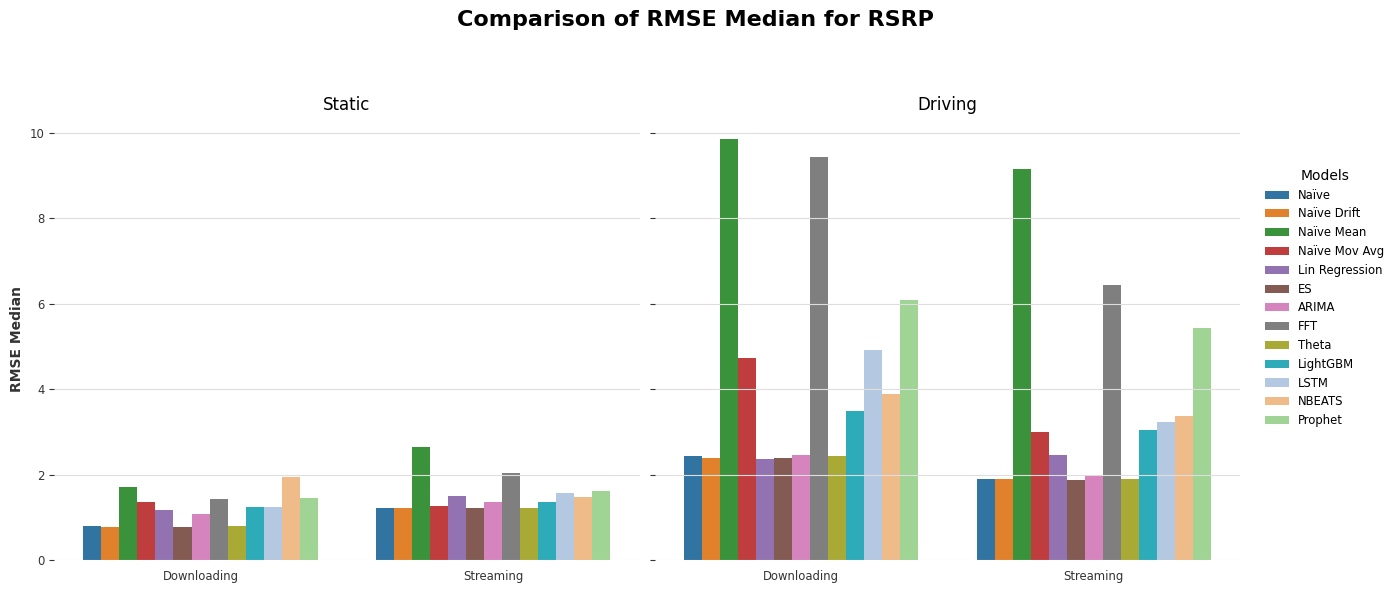

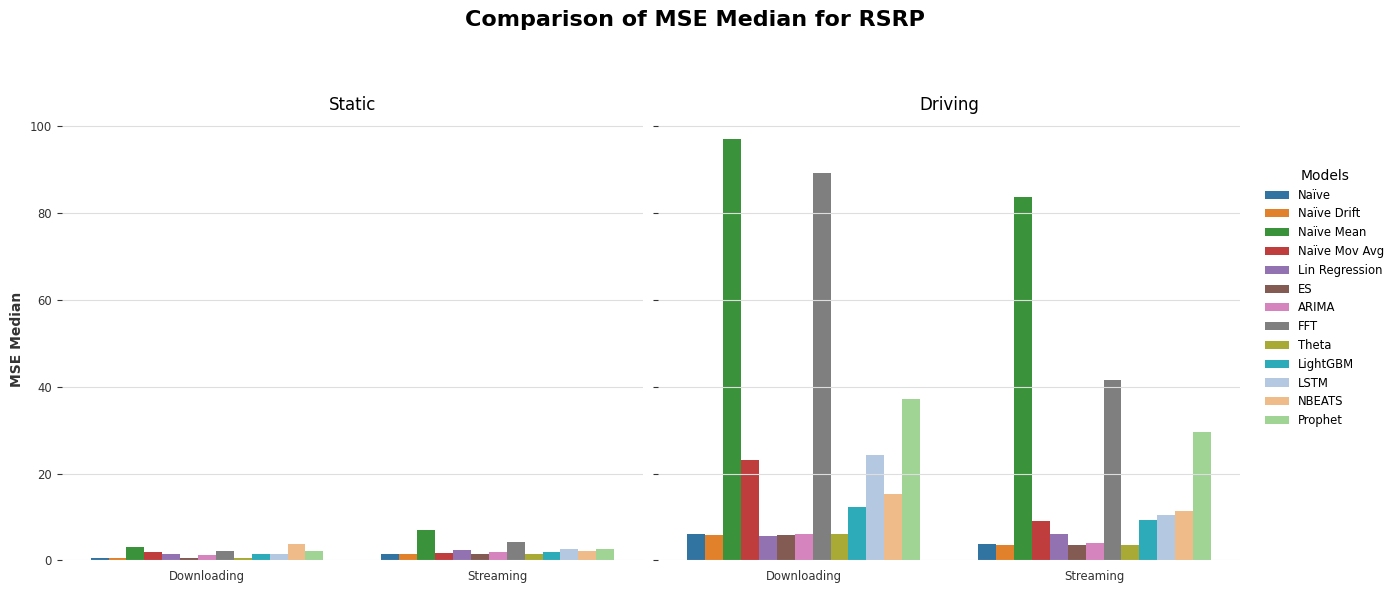

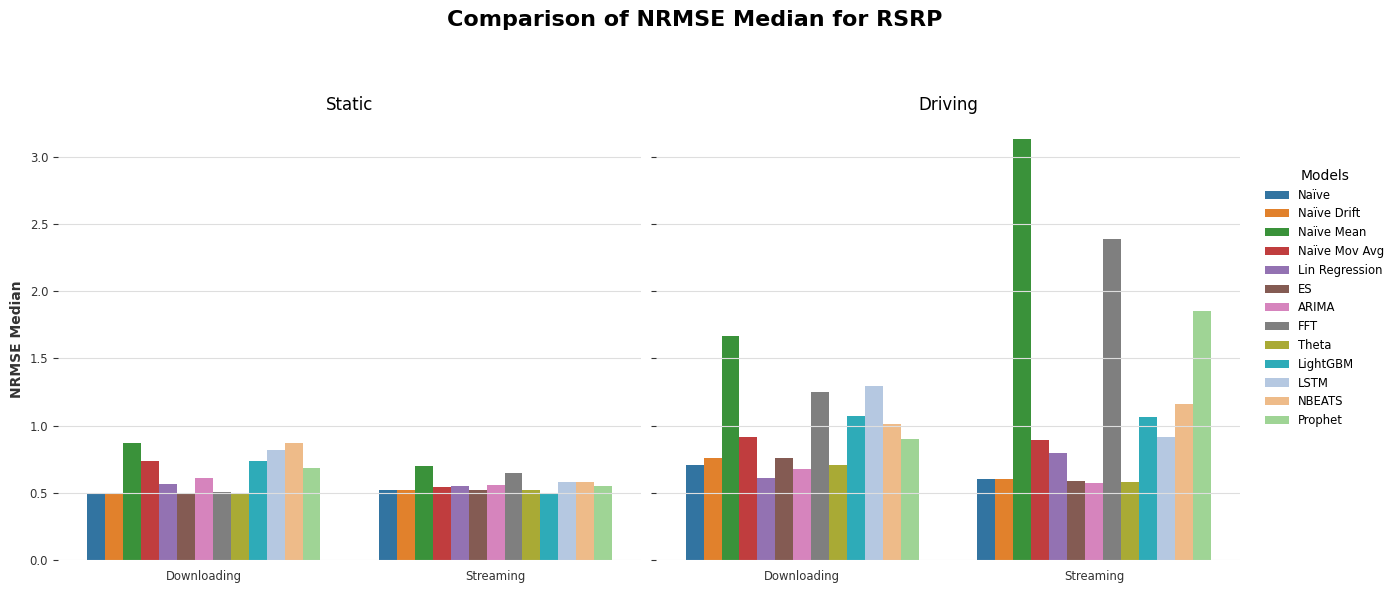

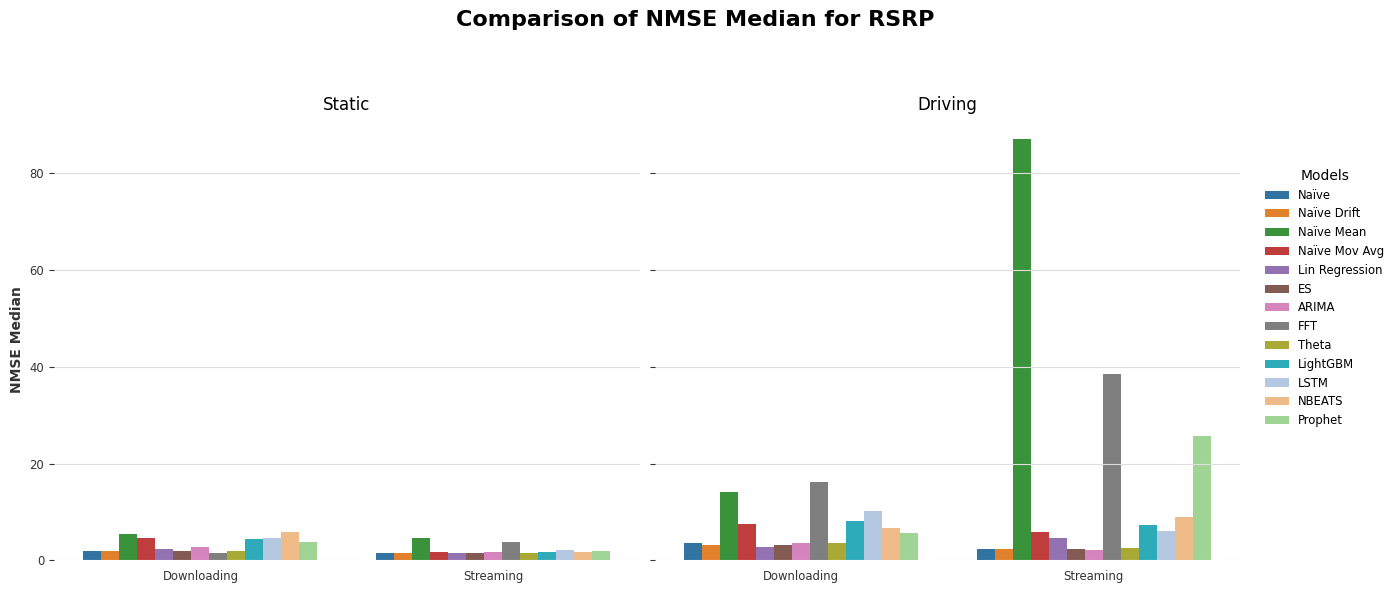

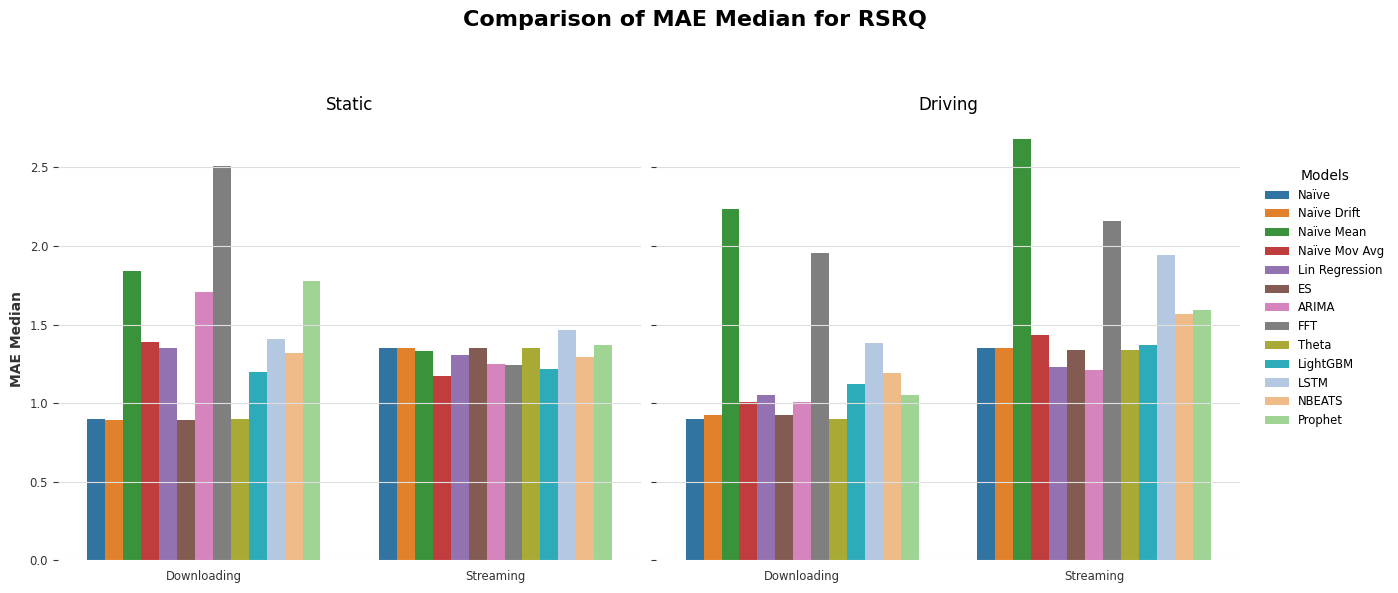

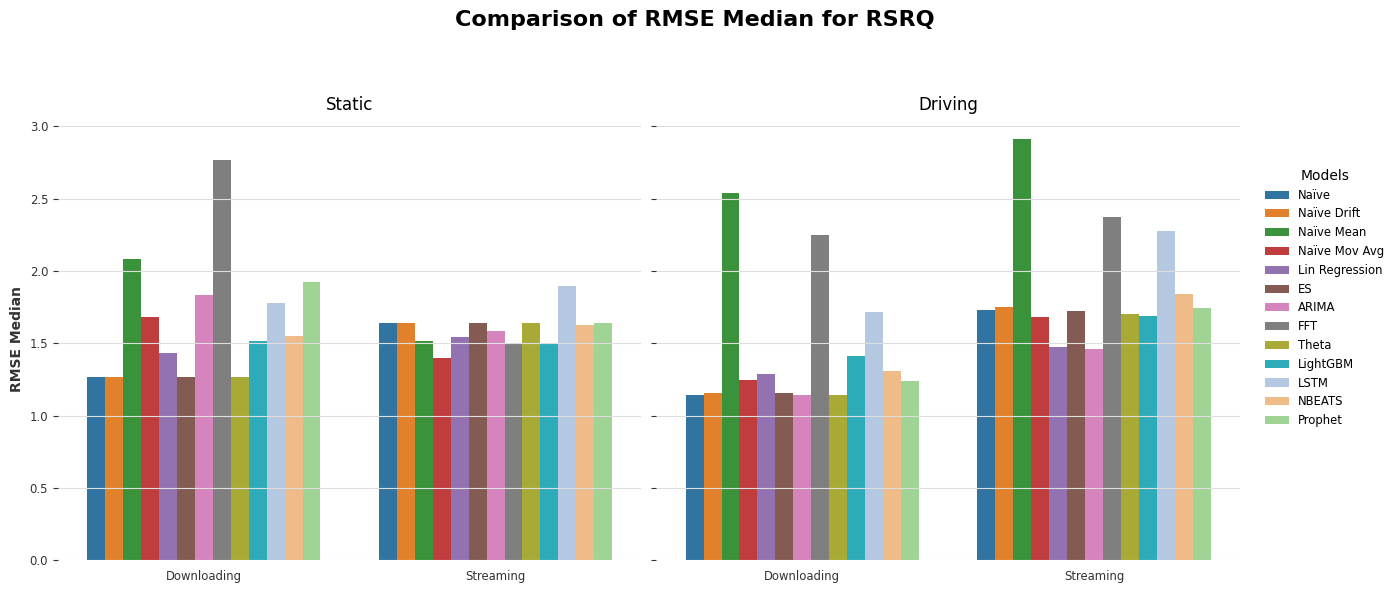

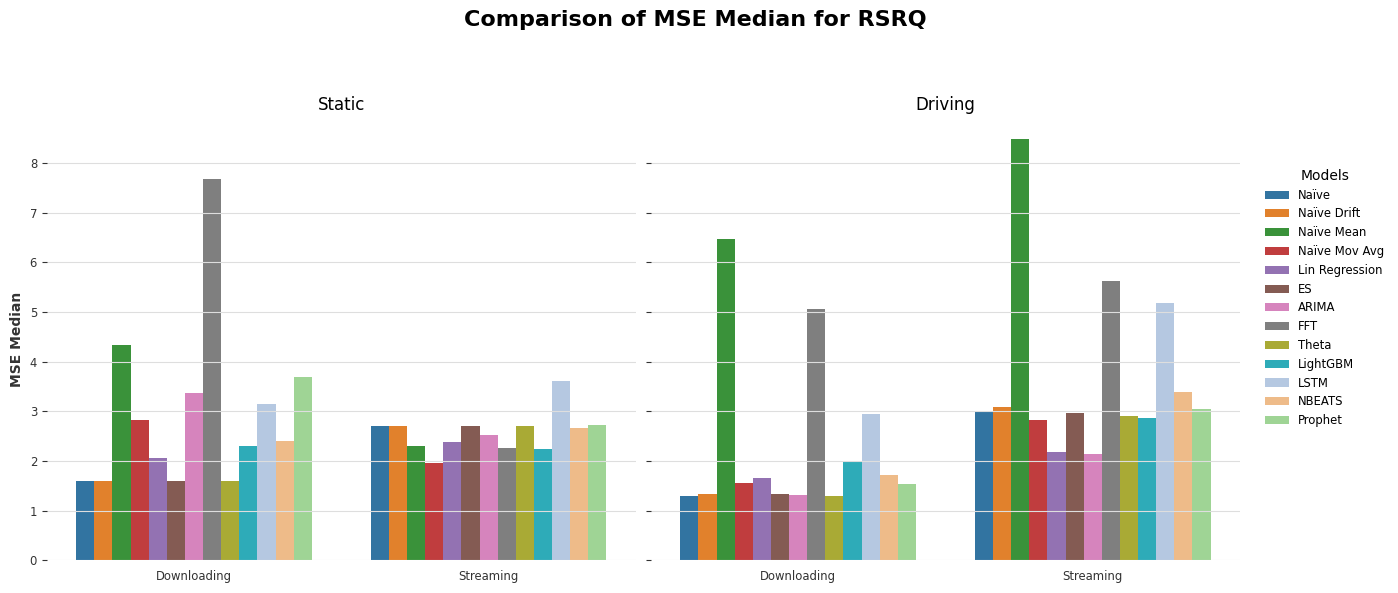

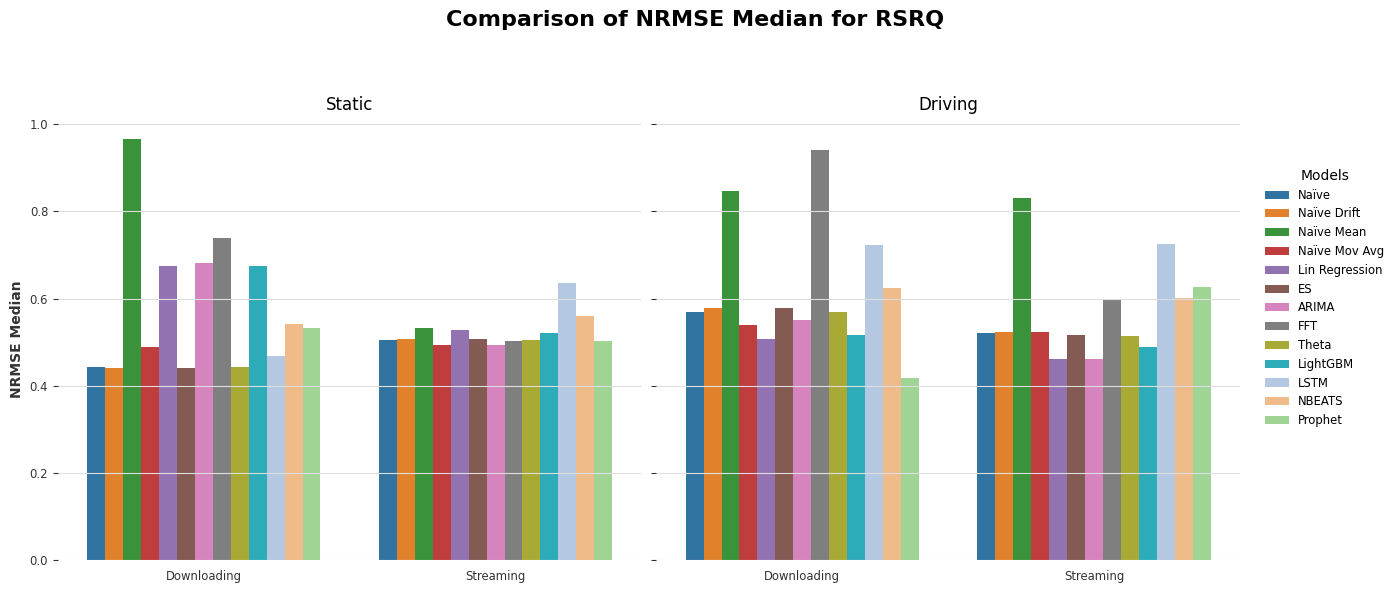

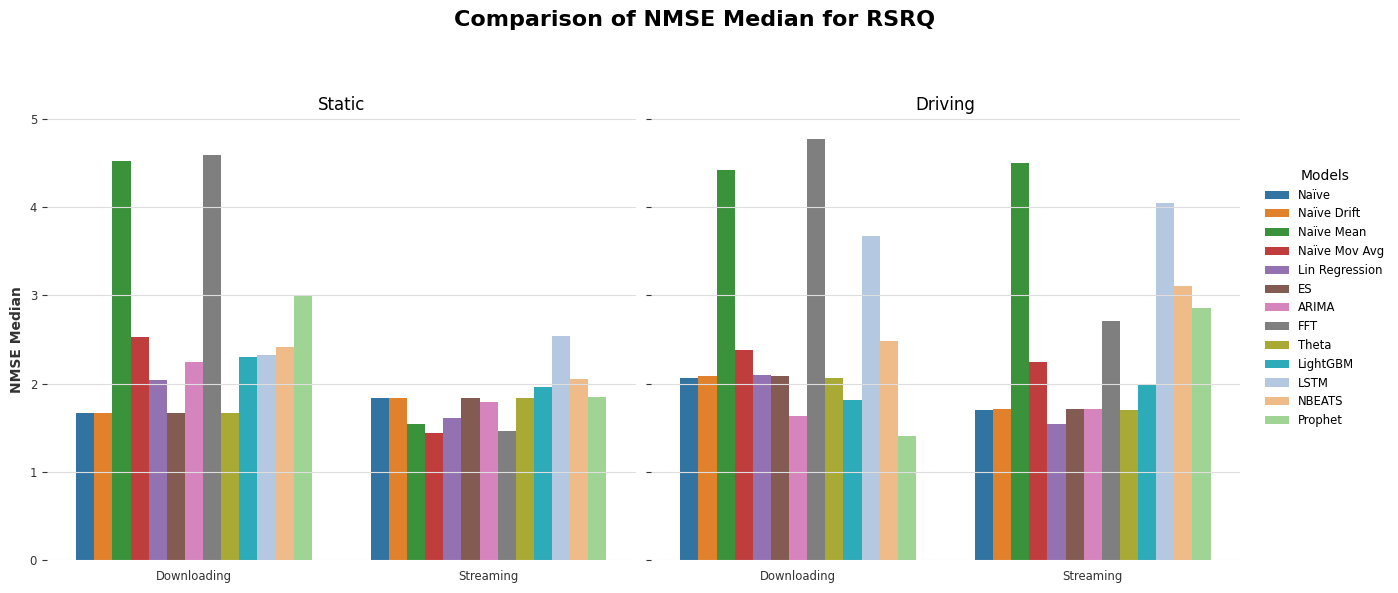

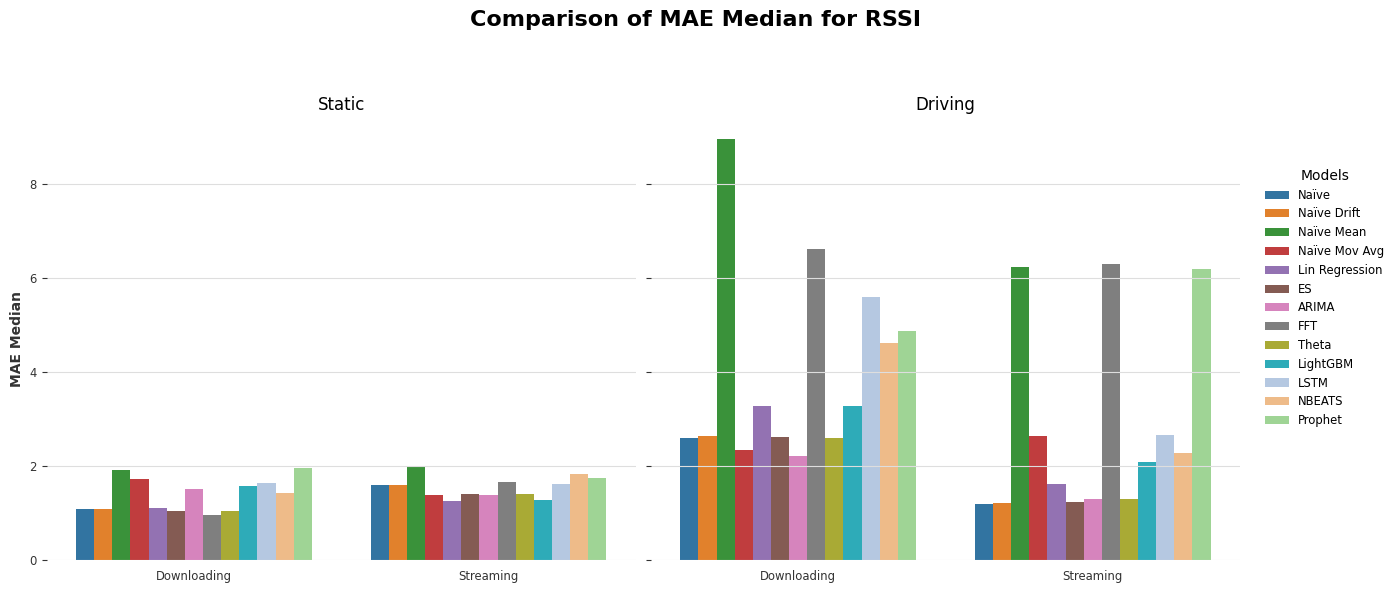

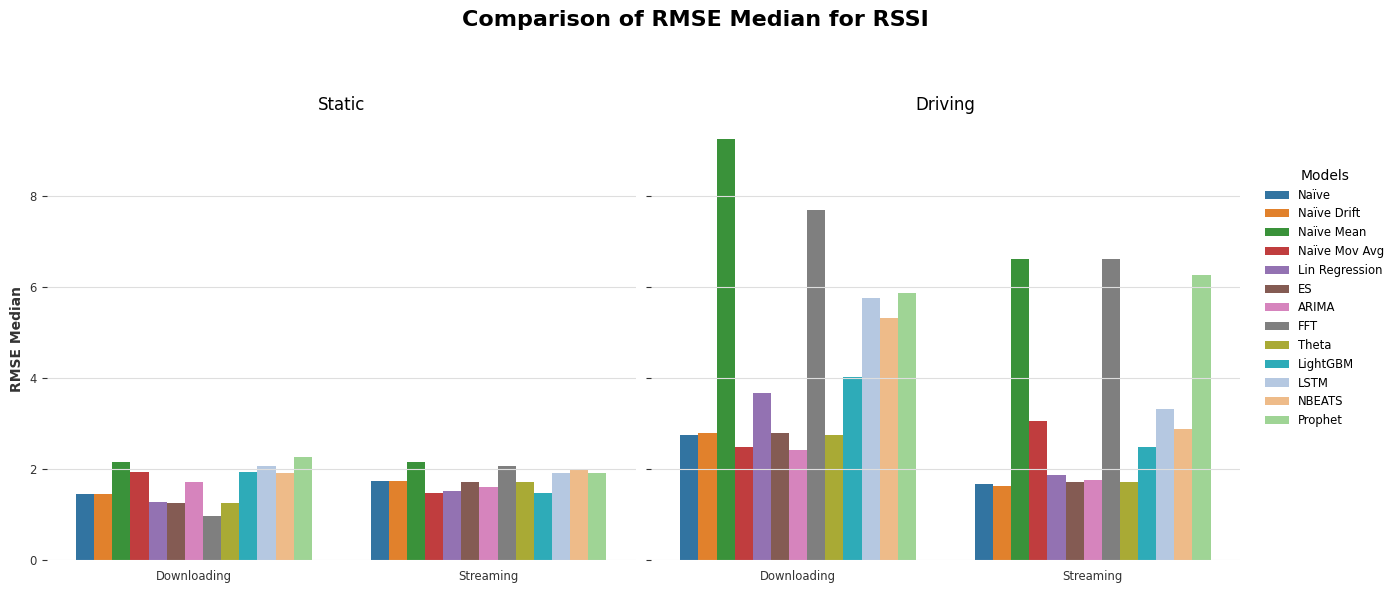

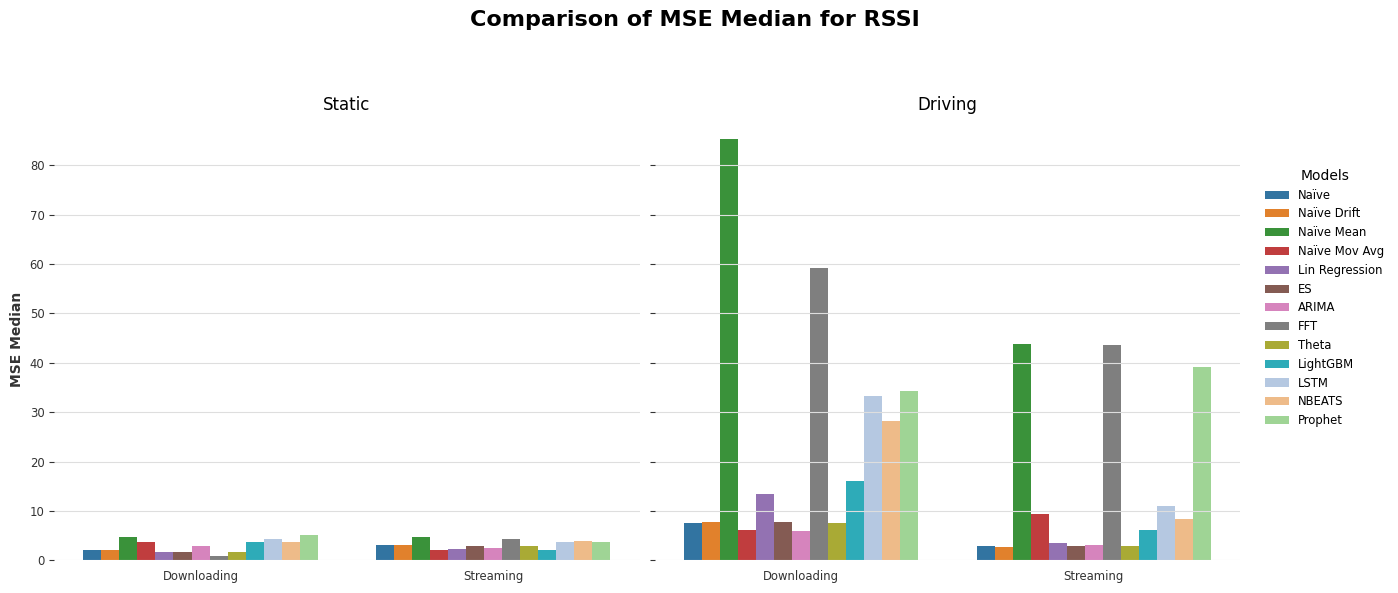

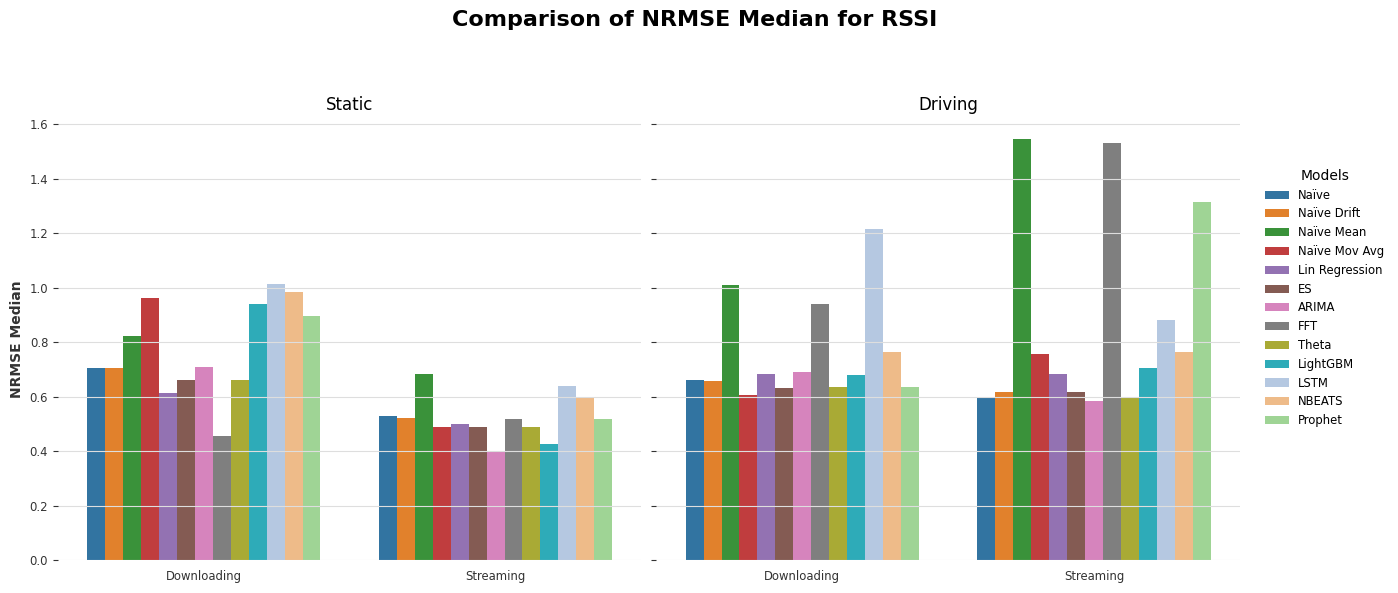

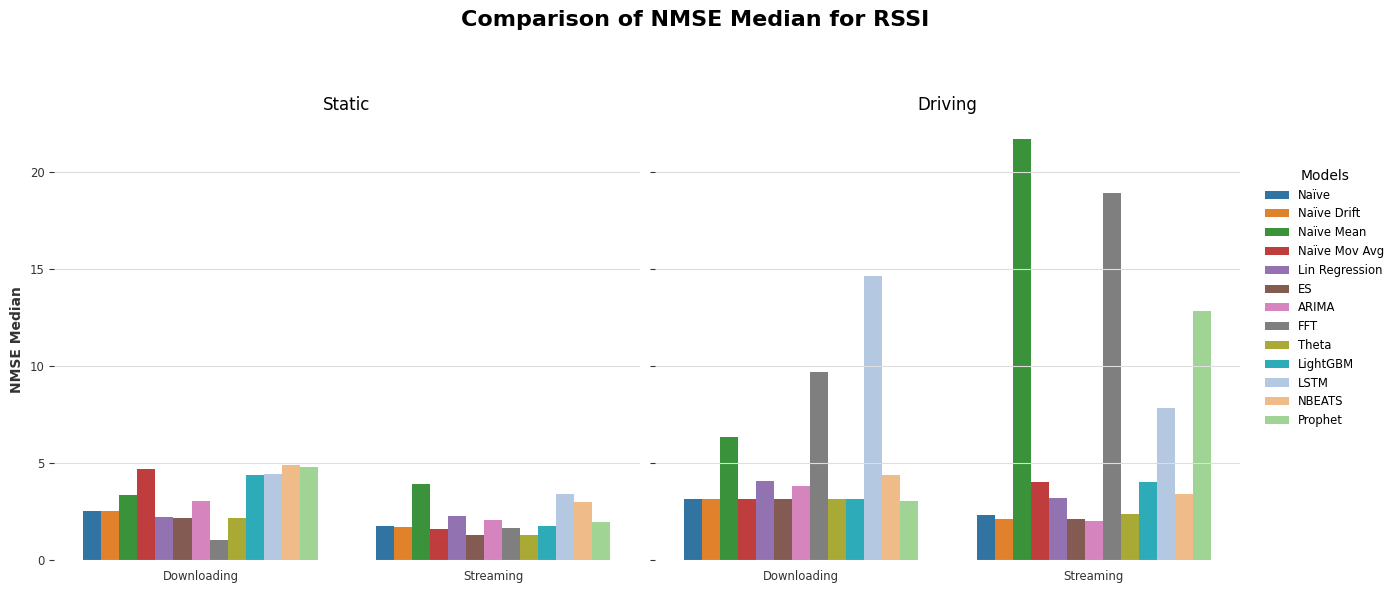

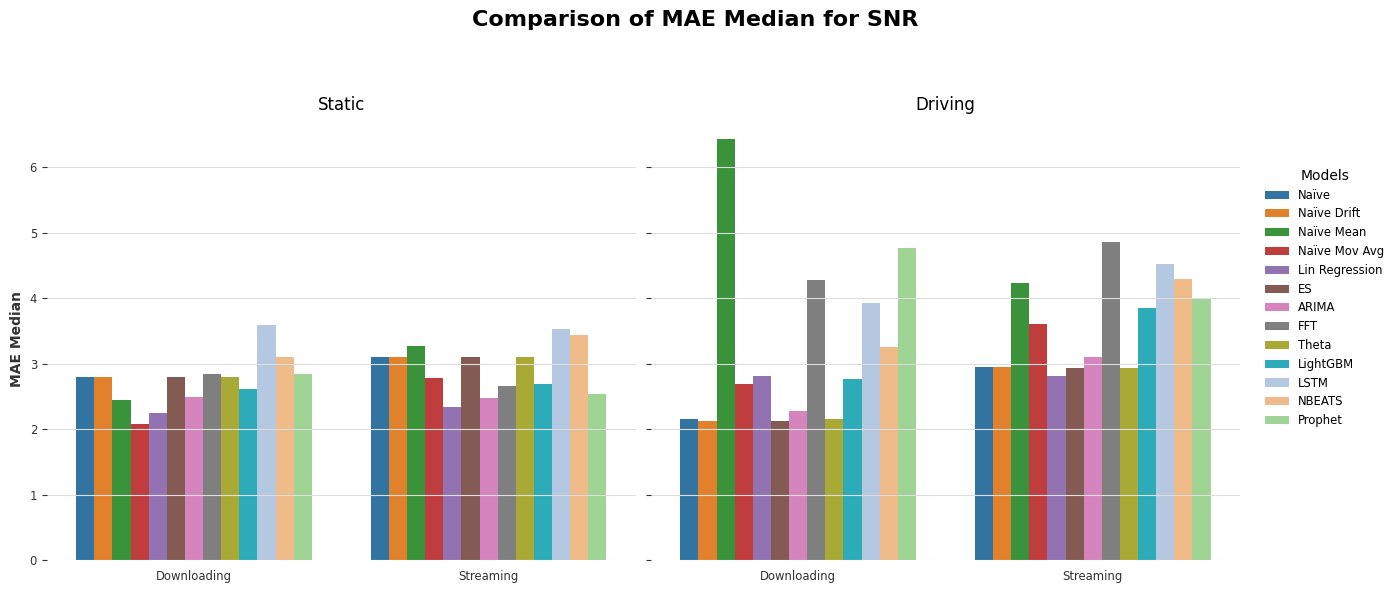

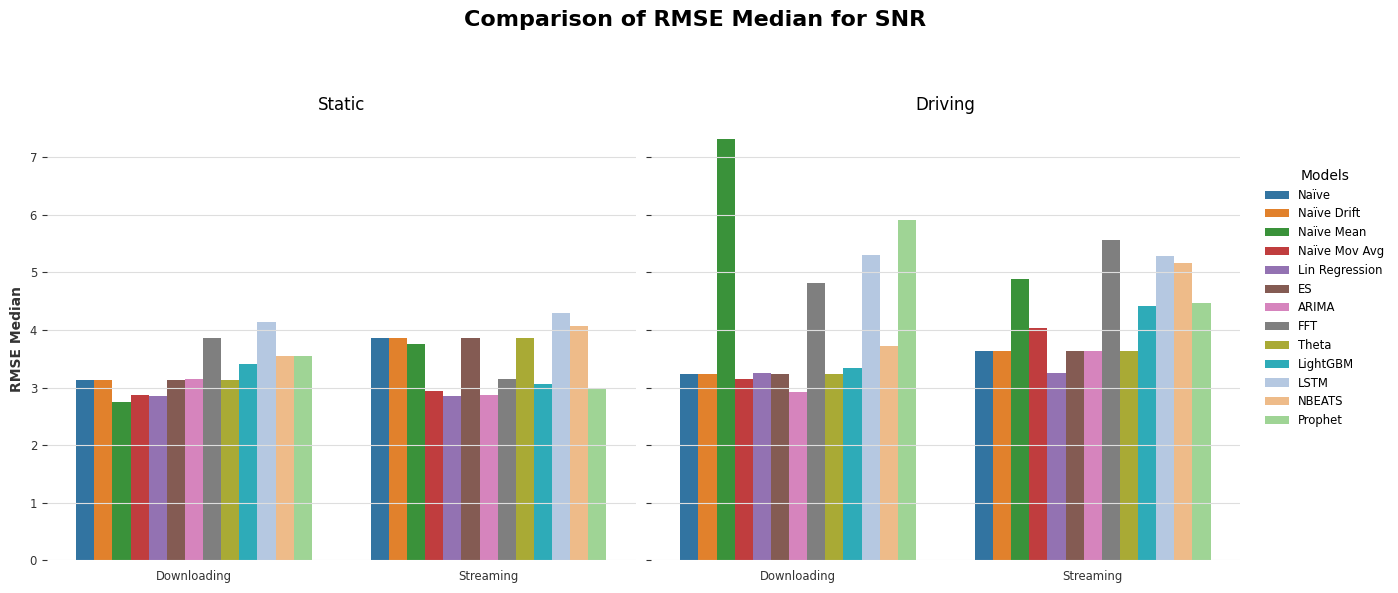

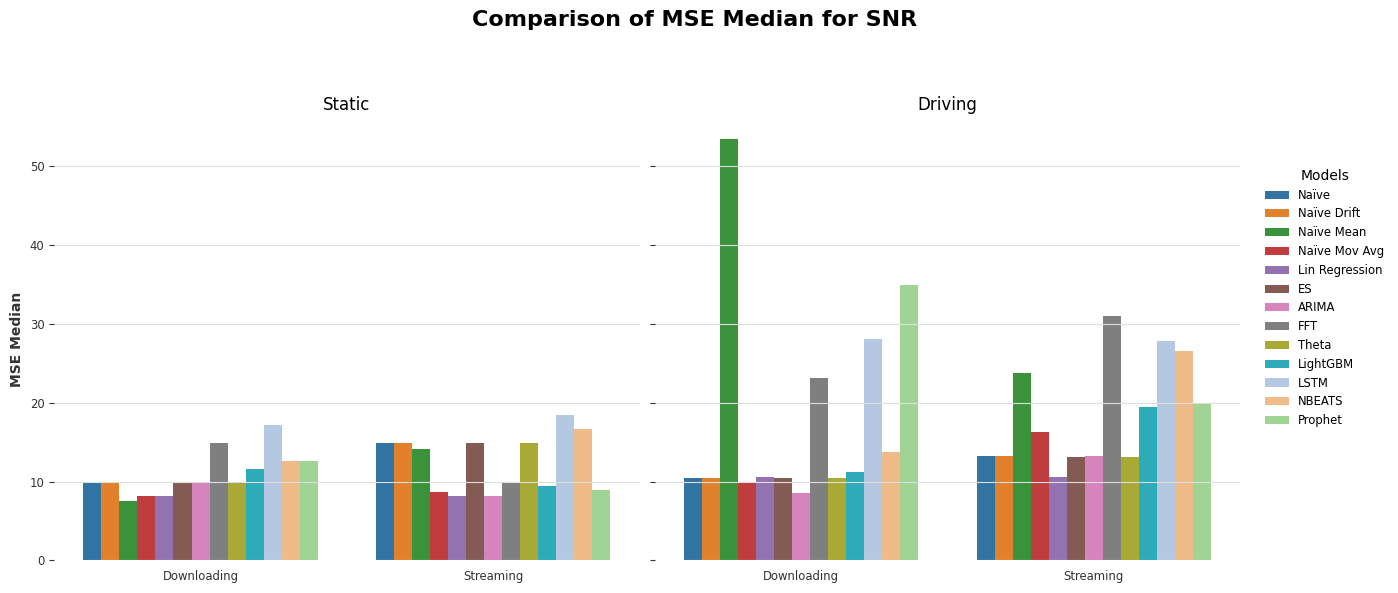

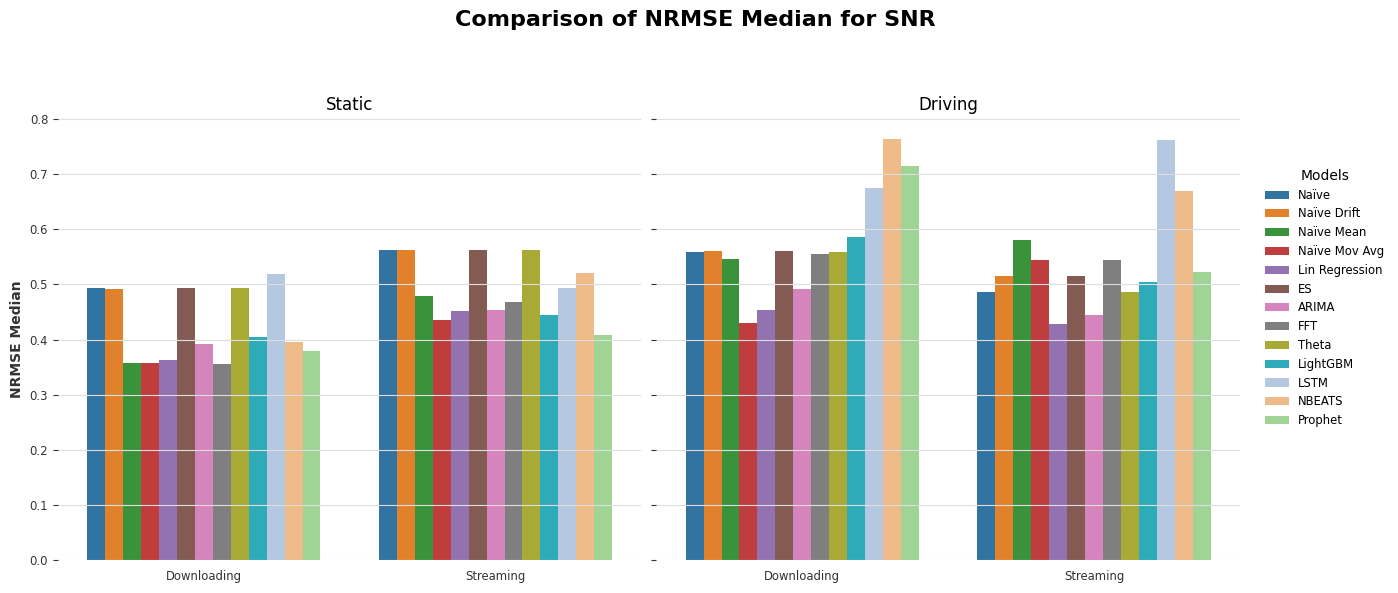

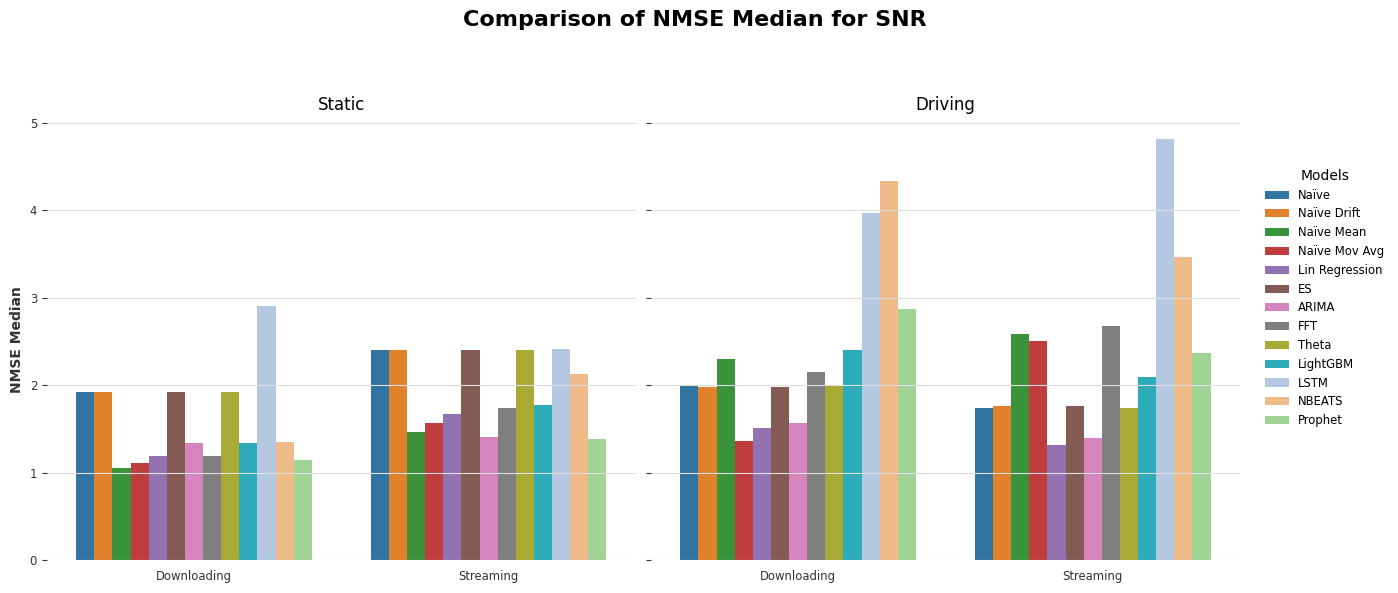

In [ ]:
plot_bar_for_medians_by_target(agg_data)

## Boxplot das métricas

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_boxplots_for_metrics_by_target(
    data: pd.DataFrame, show_outliers: bool = True
) -> None:
    """
    Generates boxplots for MAE, RMSE, MSE, NRMSE, and NMSE grouped by 'Model', 'target', and 'Activity',
    with separate plots for static and driving activities. Each metric gets its own figure.

    Parameters:
    data (pd.DataFrame): DataFrame containing the data with columns 'Model', 'target', 'Activity', 'MAE', 'RMSE', 'MSE', 'NRMSE', 'NMSE'.
    show_outliers (bool): If True, outliers will be displayed. If False, they will be hidden. Default is True.

    Returns:
    None: Displays the boxplot graphs.
    """
    # Define a custom color palette
    custom_colors = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#17becf",
        "#aec7e8",
        "#ffbb78",
        "#98df8a",
    ]

    # Desired label mapping
    label_mapping = {
        "Naive": "Naïve",
        "NaiveDrift": "Naïve Drift",
        "NaiveMean": "Naïve Mean",
        "NaiveMovingAverage": "Naïve Mov Avg",
        "LinearRegression": "Lin Regression",
        "ExponentialSmoothing": "ES",
        "ARIMA": "ARIMA",
        "FFT": "FFT",
        "Theta": "Theta",
        "LightGBM": "LightGBM",
        "LSTM": "LSTM",
        "NBEATS": "NBEATS",
        "Prophet": "Prophet",
    }

    # Define the desired order of models
    model_order = [
        "Naive",
        "NaiveDrift",
        "NaiveMean",
        "NaiveMovingAverage",  # Baseline benchmarks
        "LinearRegression",
        "ExponentialSmoothing",  # Standard benchmarks
        "ARIMA",
        "FFT",
        "Theta",  # Statistical methods
        "LightGBM",
        "LSTM",
        "NBEATS",
        "Prophet",  # Machine Learning models
    ]

    # Define the desired order of activities
    static_activities = ["static_down", "static_strm"]
    driving_activities = ["driving_down", "driving_strm"]

    # List of metrics
    metrics = ["MAE", "RMSE", "MSE", "NRMSE", "NMSE"]

    # Get unique targets
    targets = data["target"].unique()

    # Assign colors to models using the custom color palette
    model_palette = dict(zip(model_order, custom_colors[: len(model_order)]))

    # Loop through the targets (e.g., CQI, RSRP, RSRQ, RSSI, SNR)
    for target in targets:
        # Filter the data for the current target
        data_subset = data[data["target"] == target]

        for metric in metrics:
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))

            # Static activities
            static_data = data_subset[data_subset["Activity"].isin(static_activities)]
            sns.boxplot(
                data=static_data,
                x="Activity",
                y=metric,
                hue="Model",
                hue_order=[
                    m for m in model_order if m in static_data["Model"].unique()
                ],
                ax=axes[0],
                order=static_activities,
                showfliers=show_outliers,
                palette=model_palette,
            )
            axes[0].set_title("Static")
            axes[0].set_ylabel(metric)
            axes[0].set_xticks(range(2))
            axes[0].set_xticklabels(["Downloading", "Streaming"])
            axes[0].set_xlabel("")
            axes[0].legend().remove()

            # Driving activities
            driving_data = data_subset[data_subset["Activity"].isin(driving_activities)]
            sns.boxplot(
                data=driving_data,
                x="Activity",
                y=metric,
                hue="Model",
                hue_order=[
                    m for m in model_order if m in driving_data["Model"].unique()
                ],
                ax=axes[1],
                order=driving_activities,
                showfliers=show_outliers,
                palette=model_palette,
            )
            axes[1].set_title("Driving")
            axes[1].set_xticks(range(2))
            axes[1].set_xticklabels(["Downloading", "Streaming"])
            axes[1].set_xlabel("")
            axes[1].legend().remove()

            # Ajusta espaçamento entre os gráficos
            plt.subplots_adjust(wspace=0.3)

            # Ajuste da legenda global
            handles, labels = axes[1].get_legend_handles_labels()
            # Replace labels with the new mapped labels
            updated_labels = [label_mapping.get(label, label) for label in labels]

            fig.legend(
                handles,
                updated_labels,
                loc="center left",
                ncol=1,
                bbox_to_anchor=(0.9, 0.5),
                fontsize="small",
                title="Models",
            )

            plt.suptitle(
                f"Comparison of {metric} for {target}", fontsize=16, fontweight="bold"
            )
            plt.tight_layout(rect=[0, 0, 0.9, 0.92])
            plt.show()

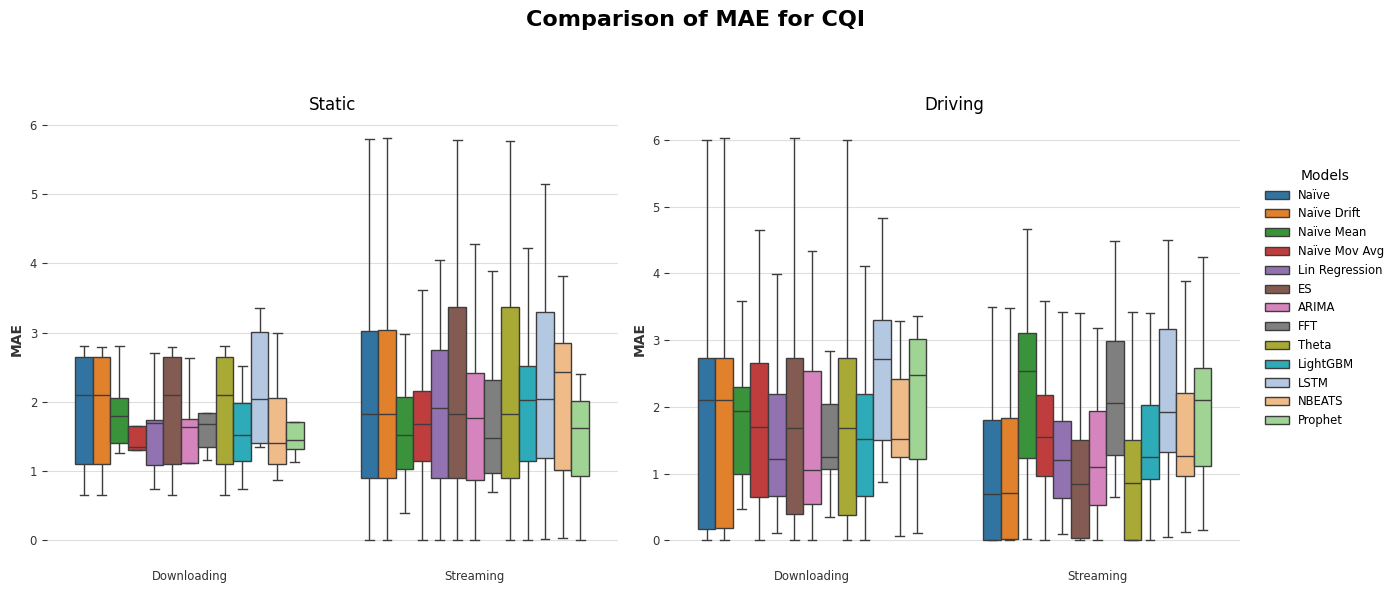

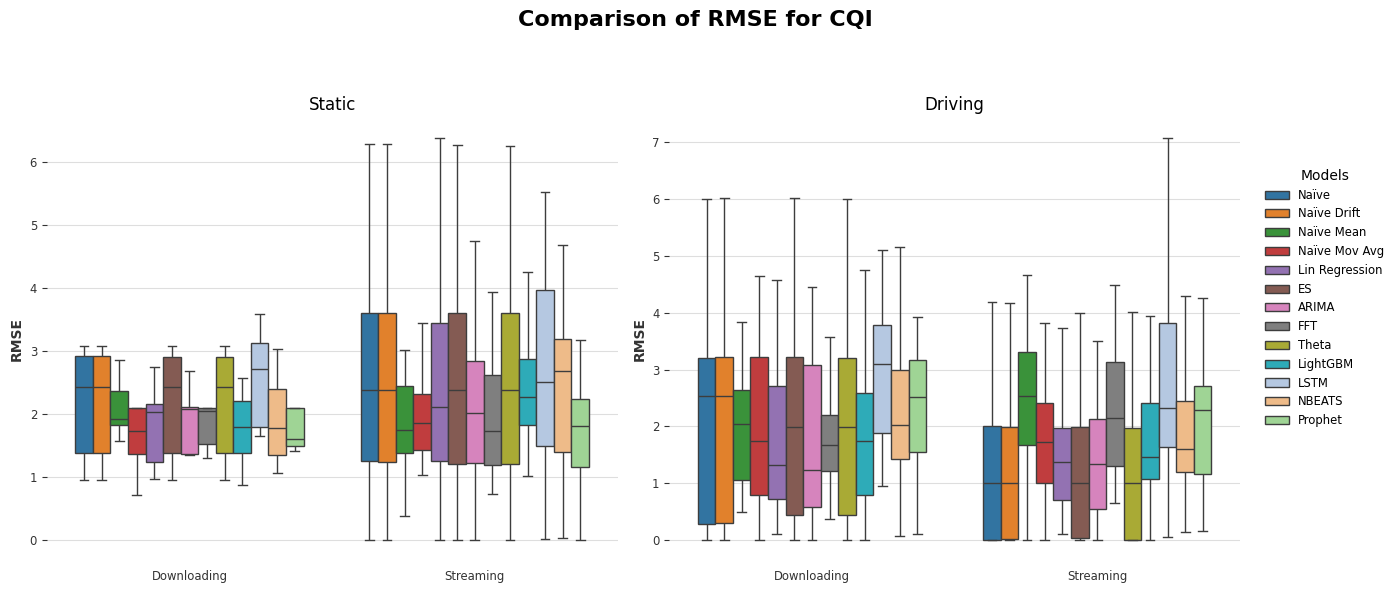

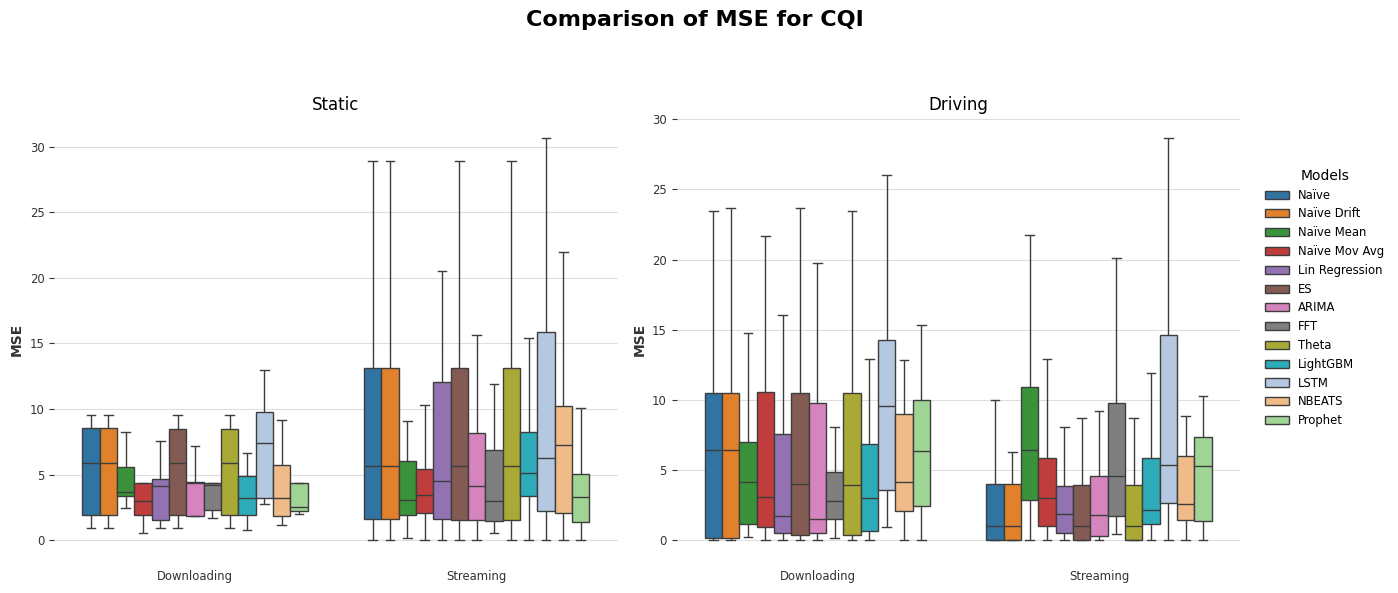

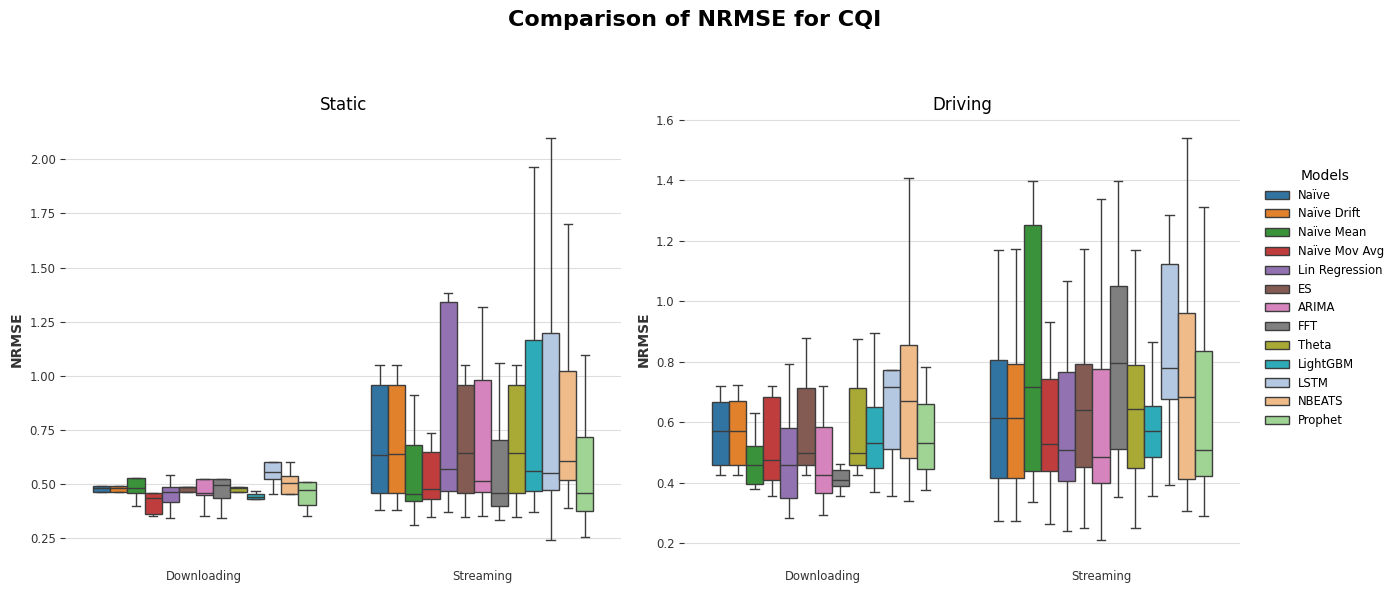

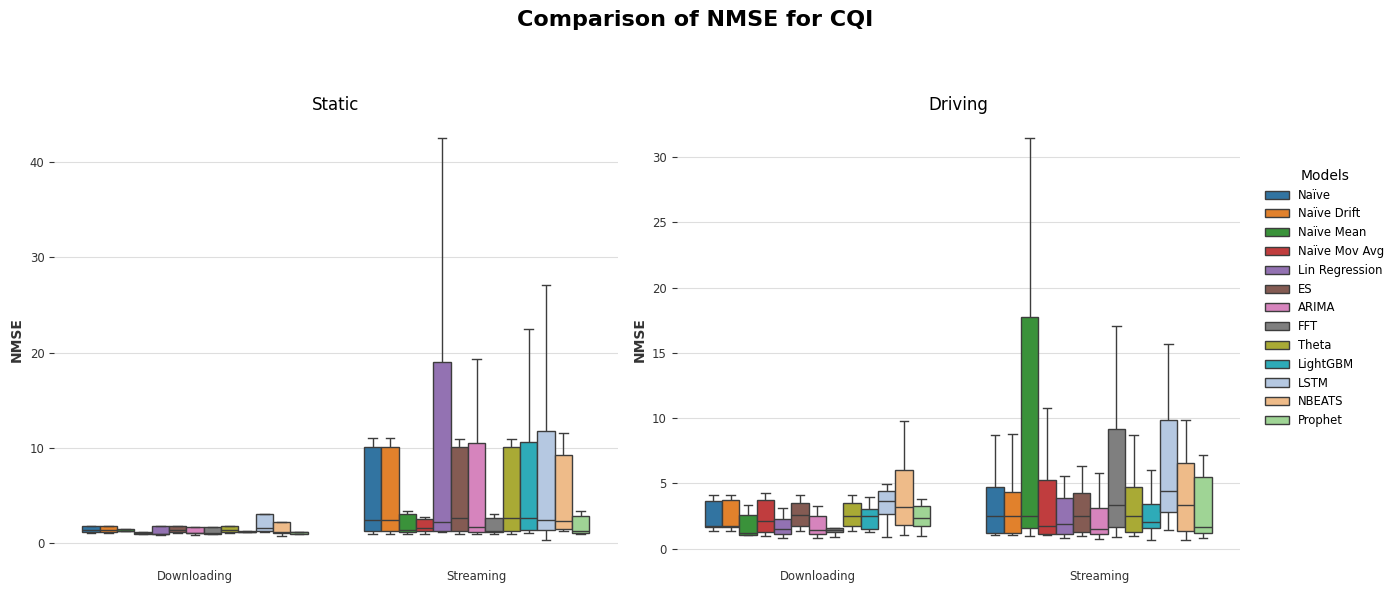

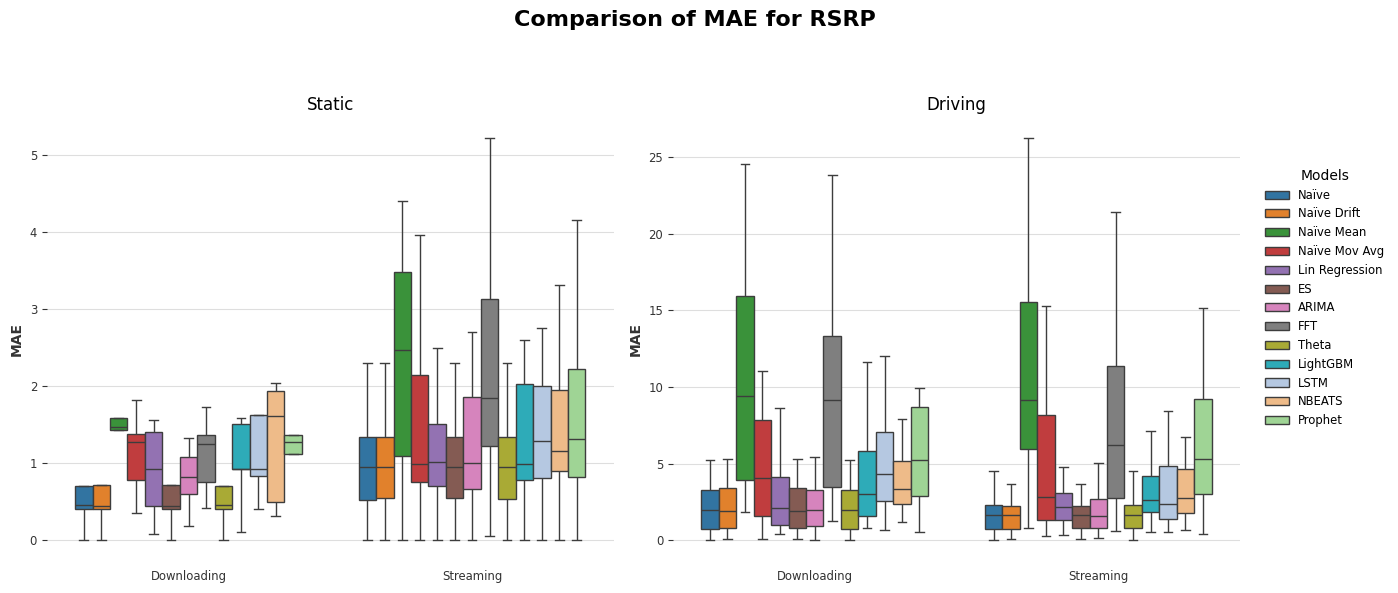

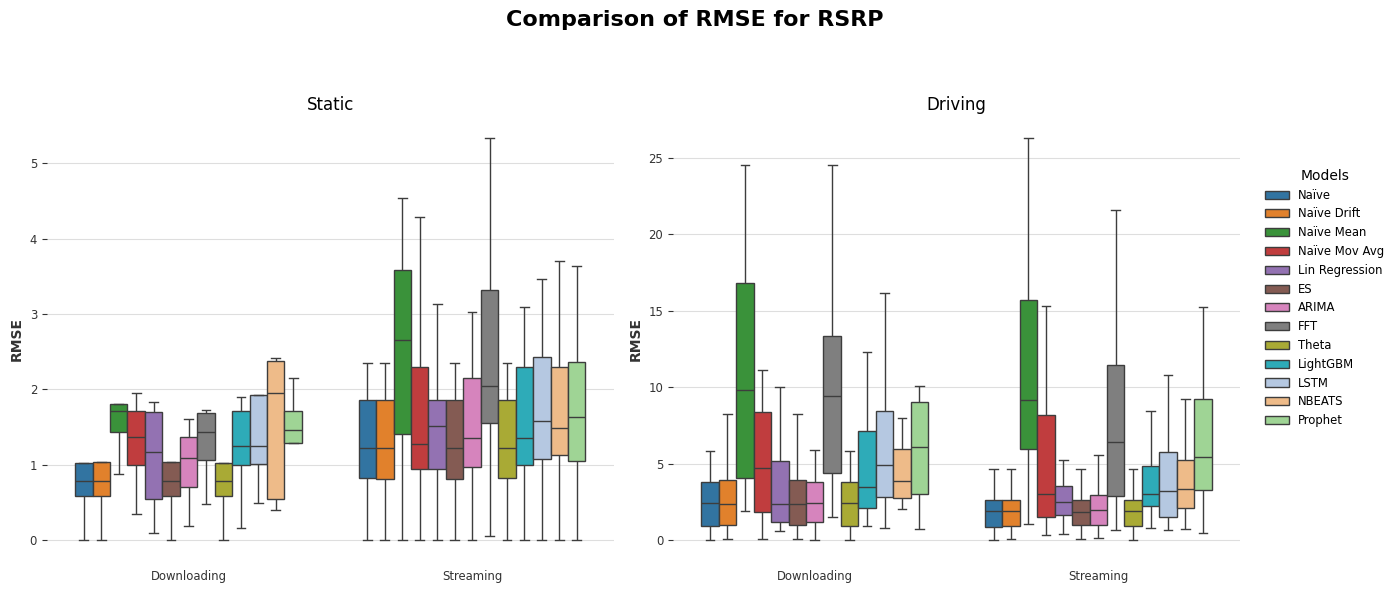

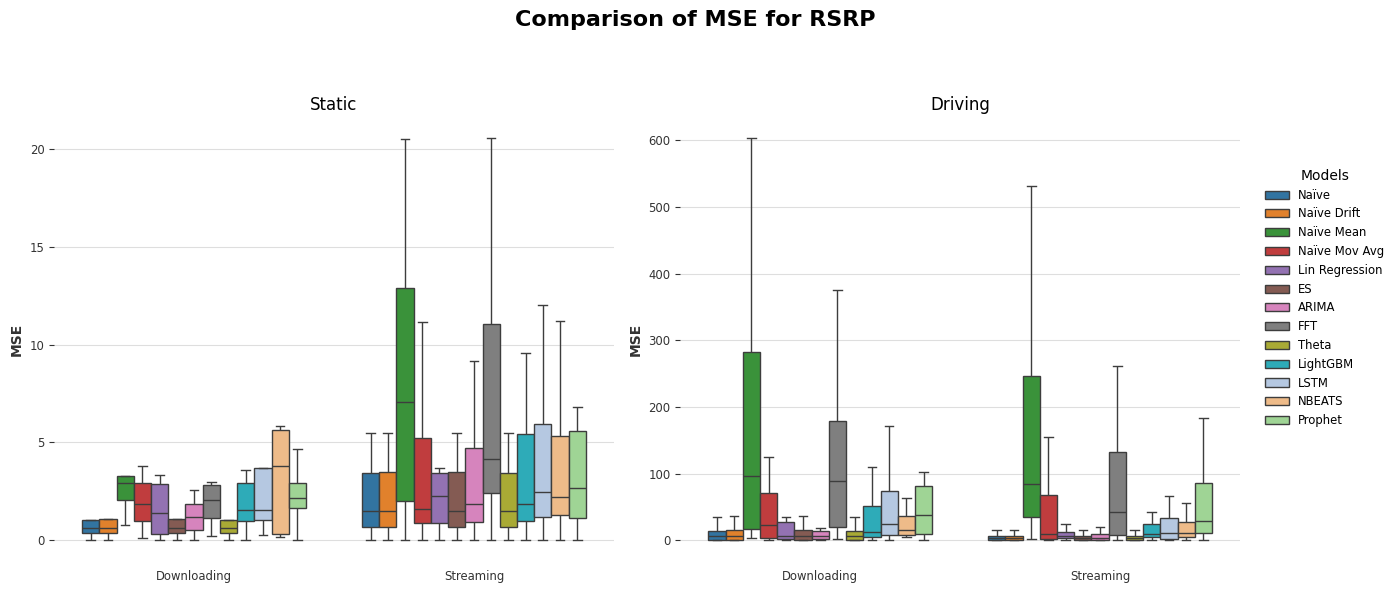

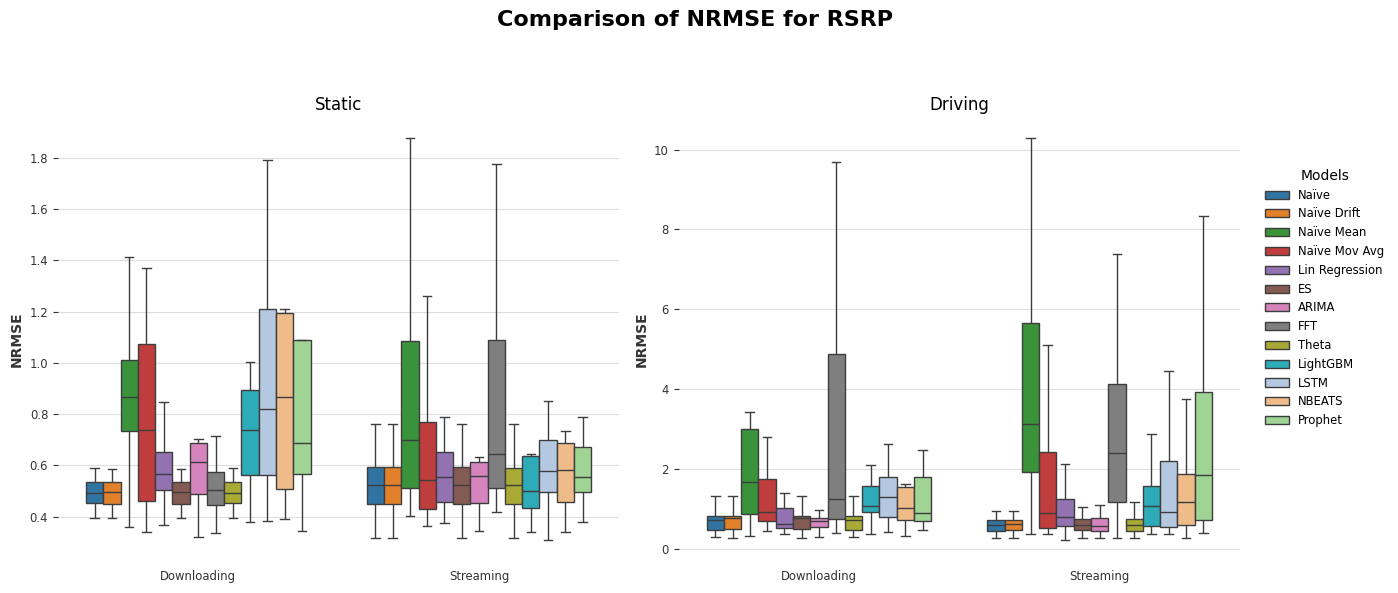

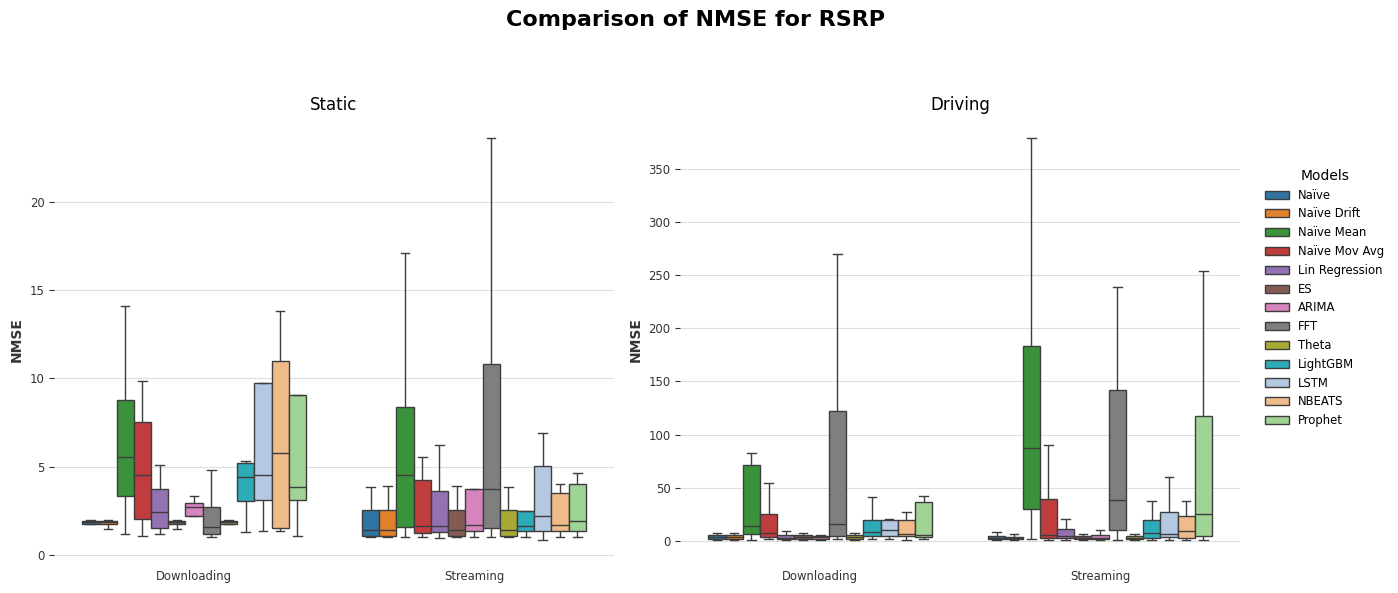

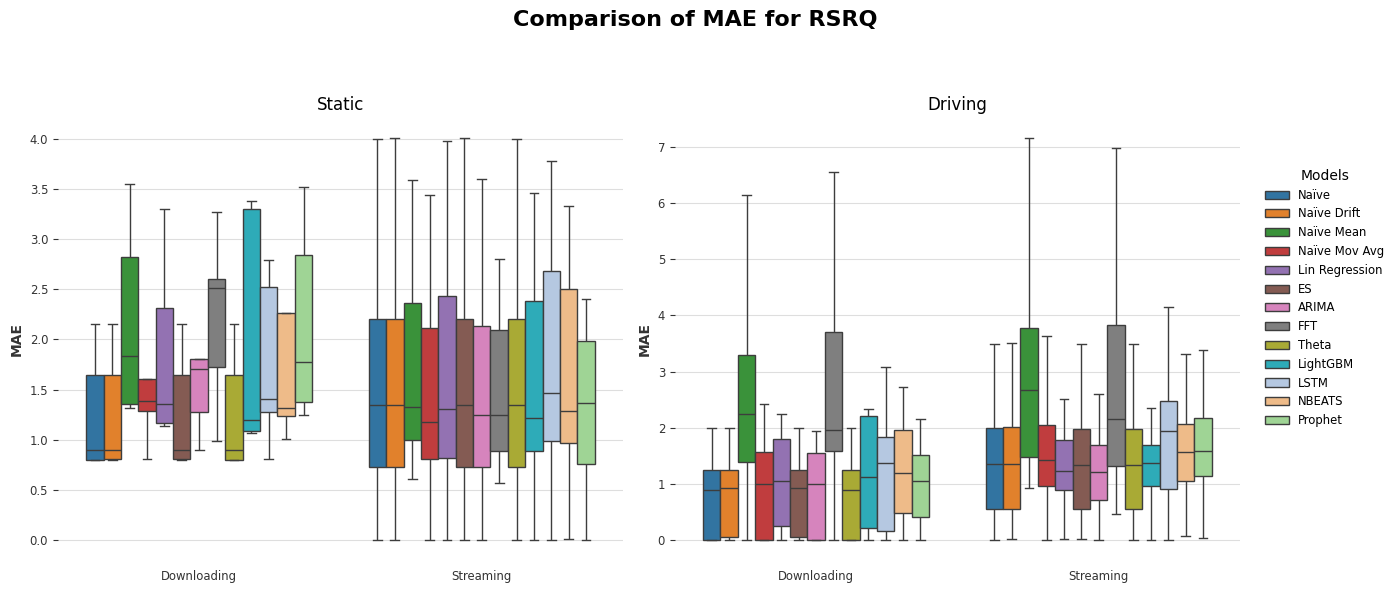

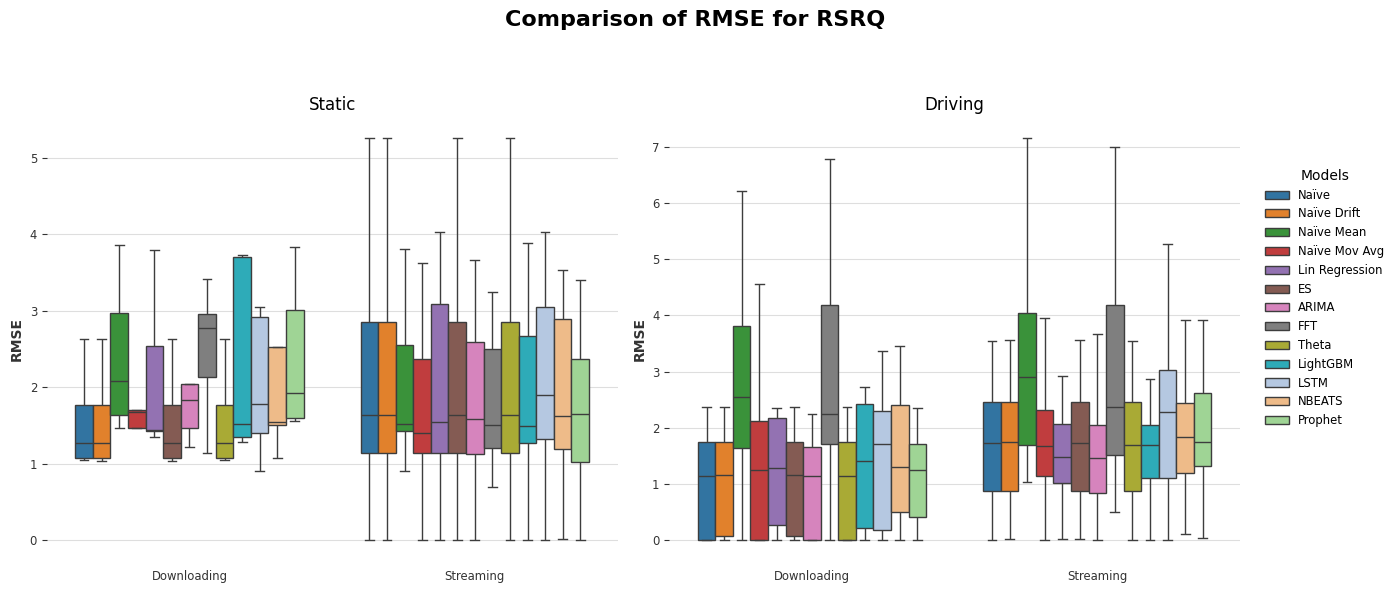

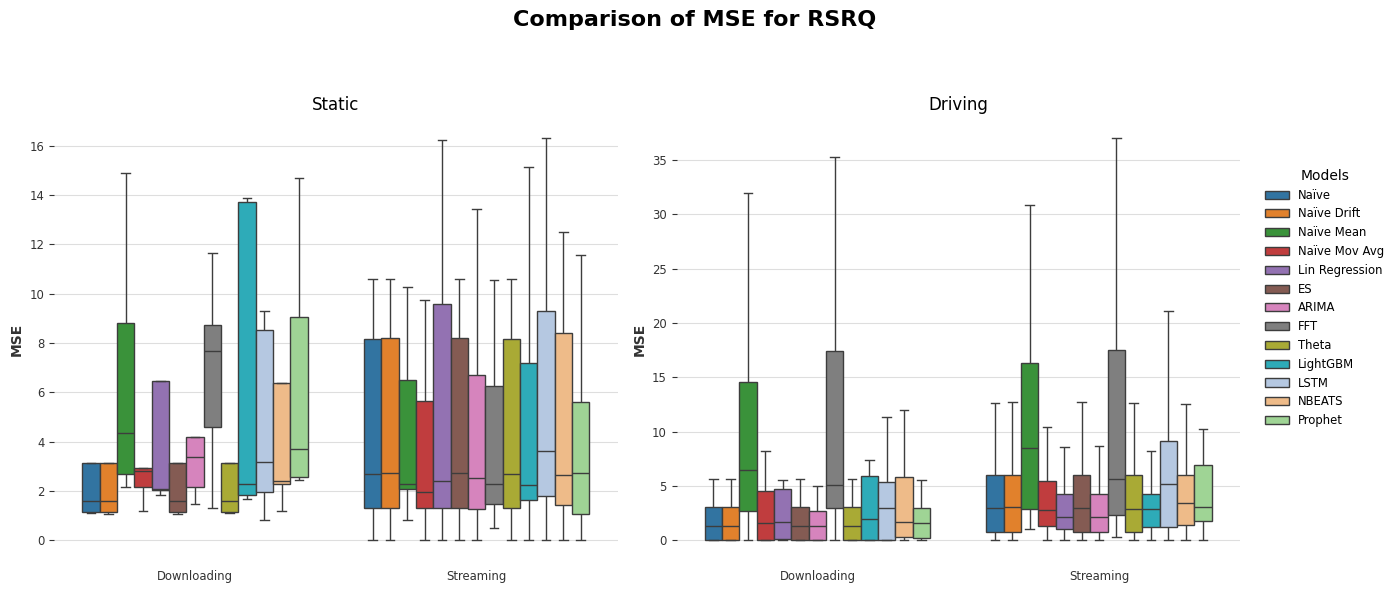

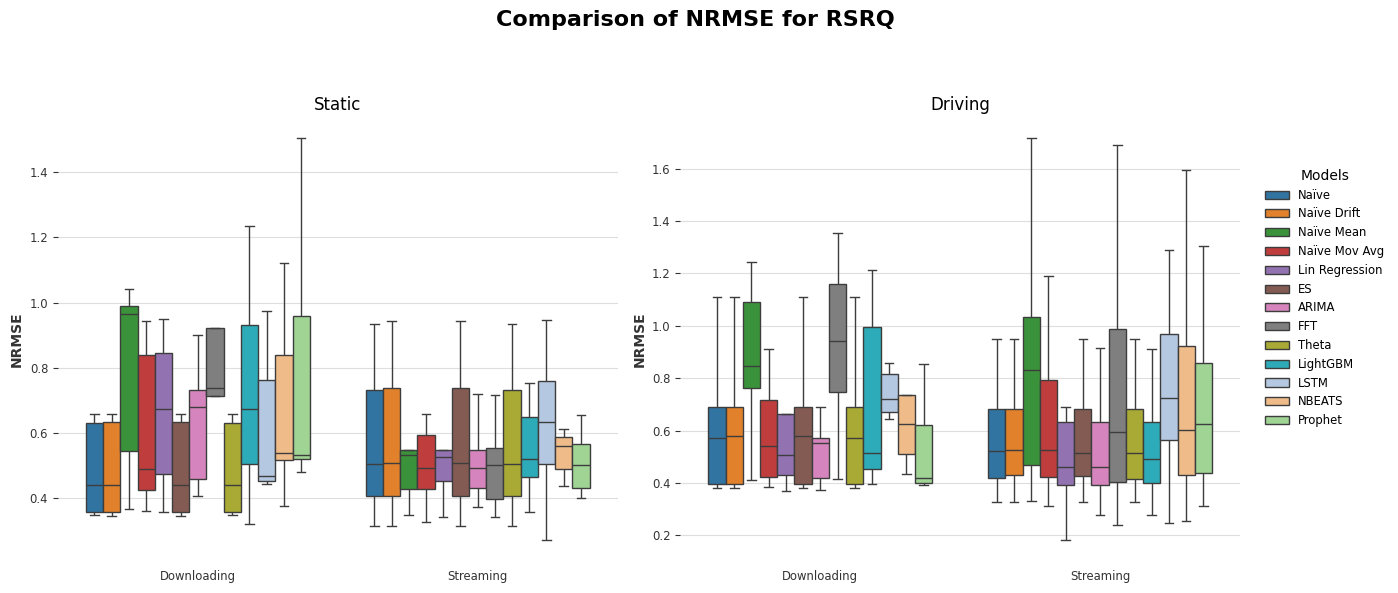

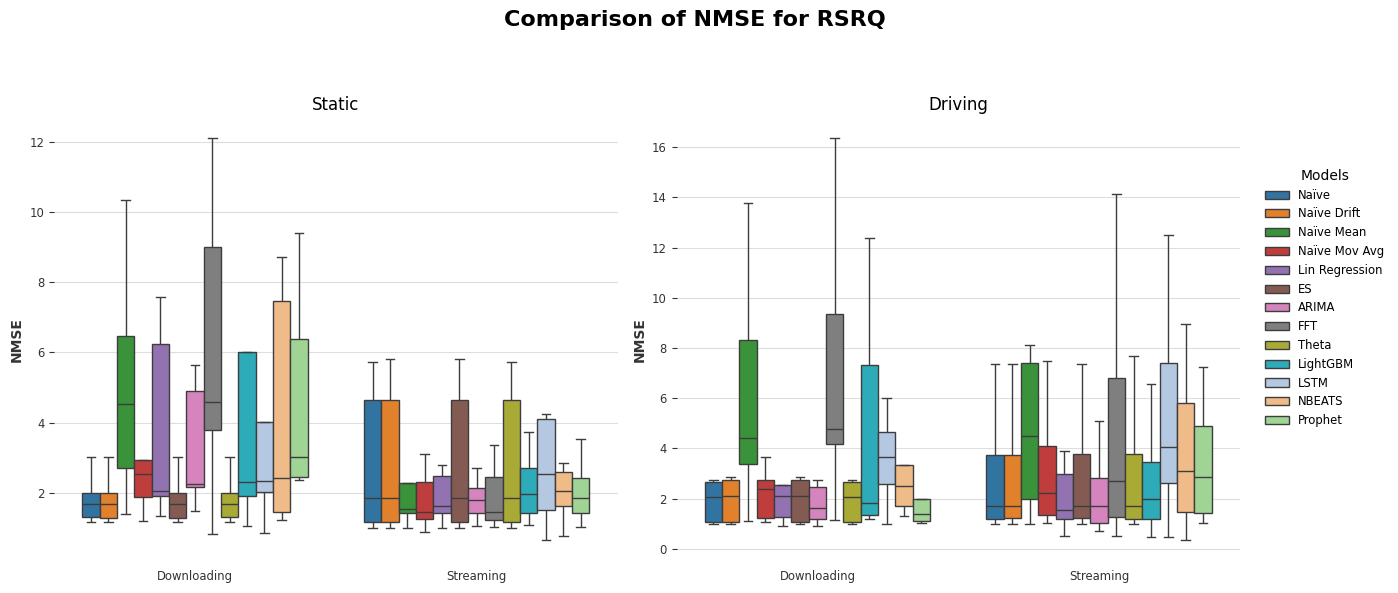

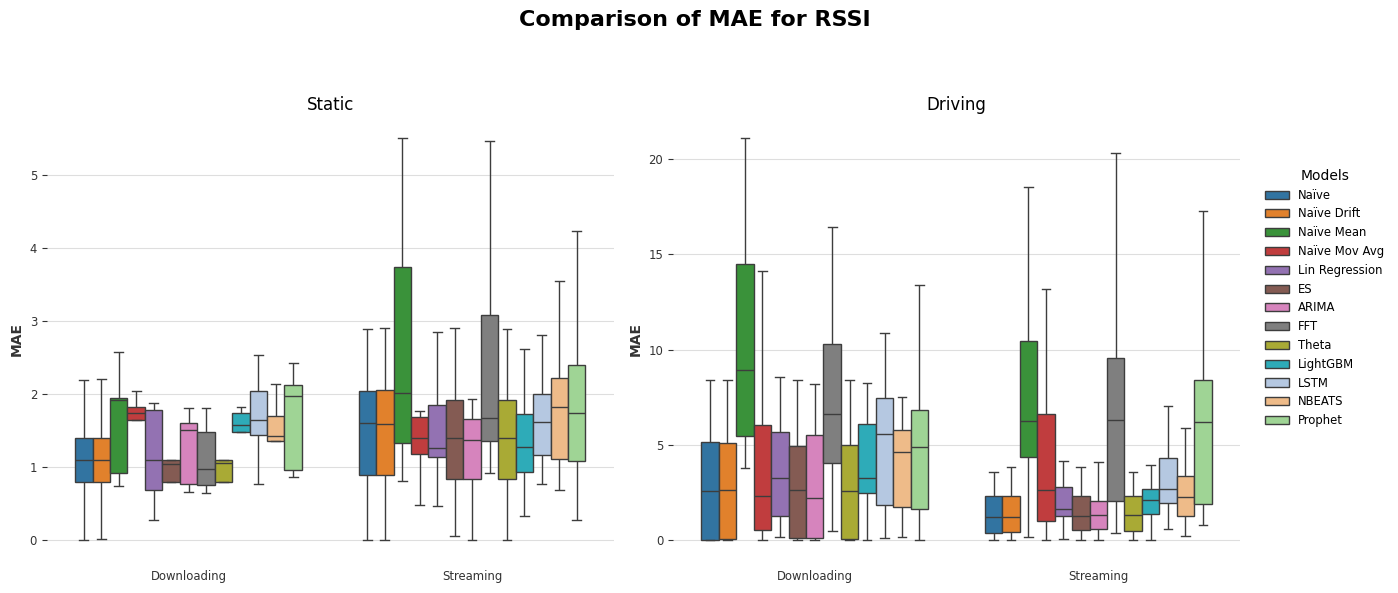

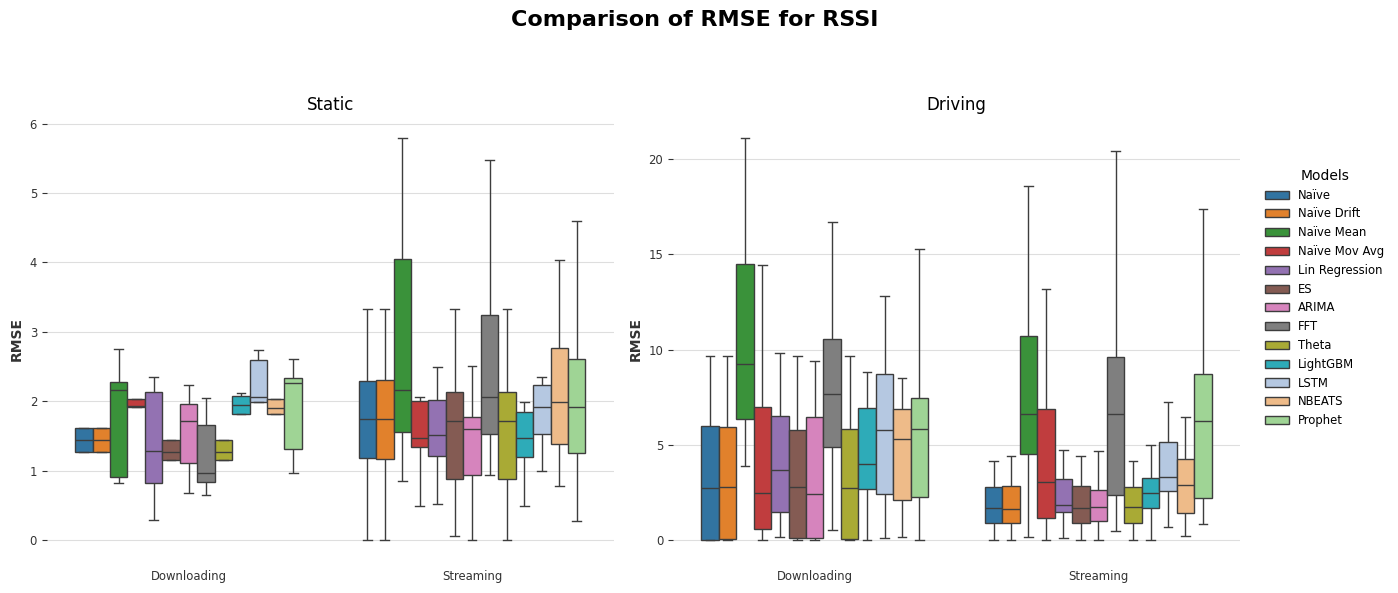

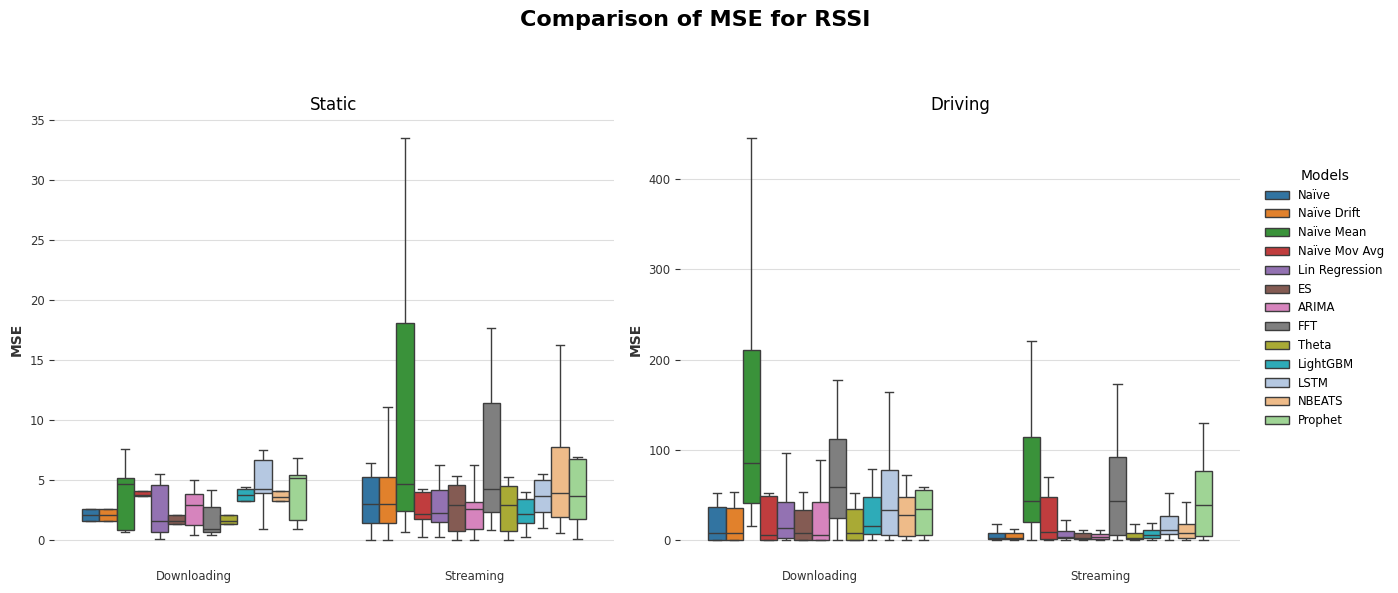

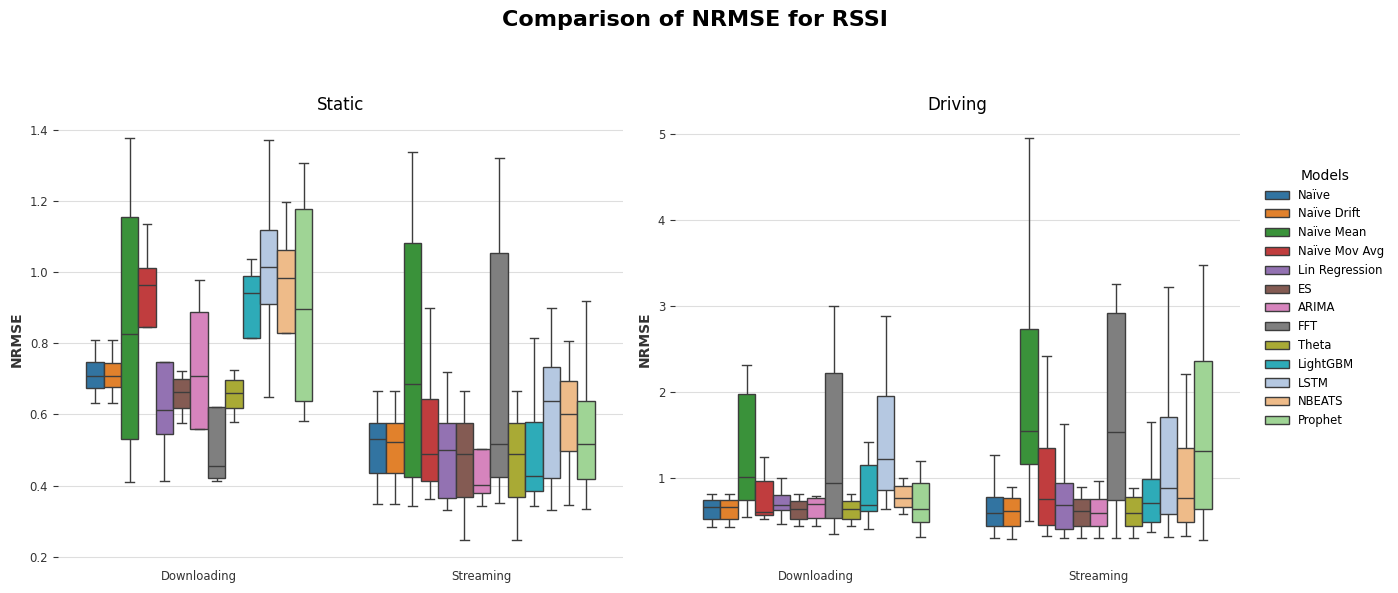

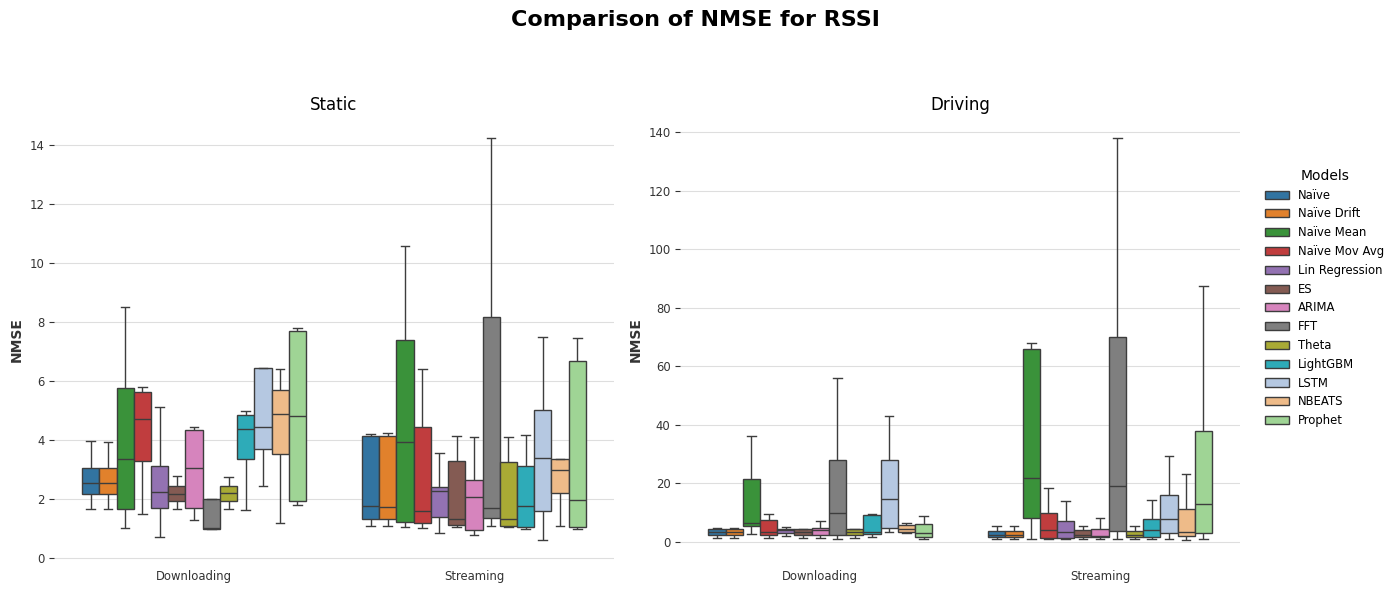

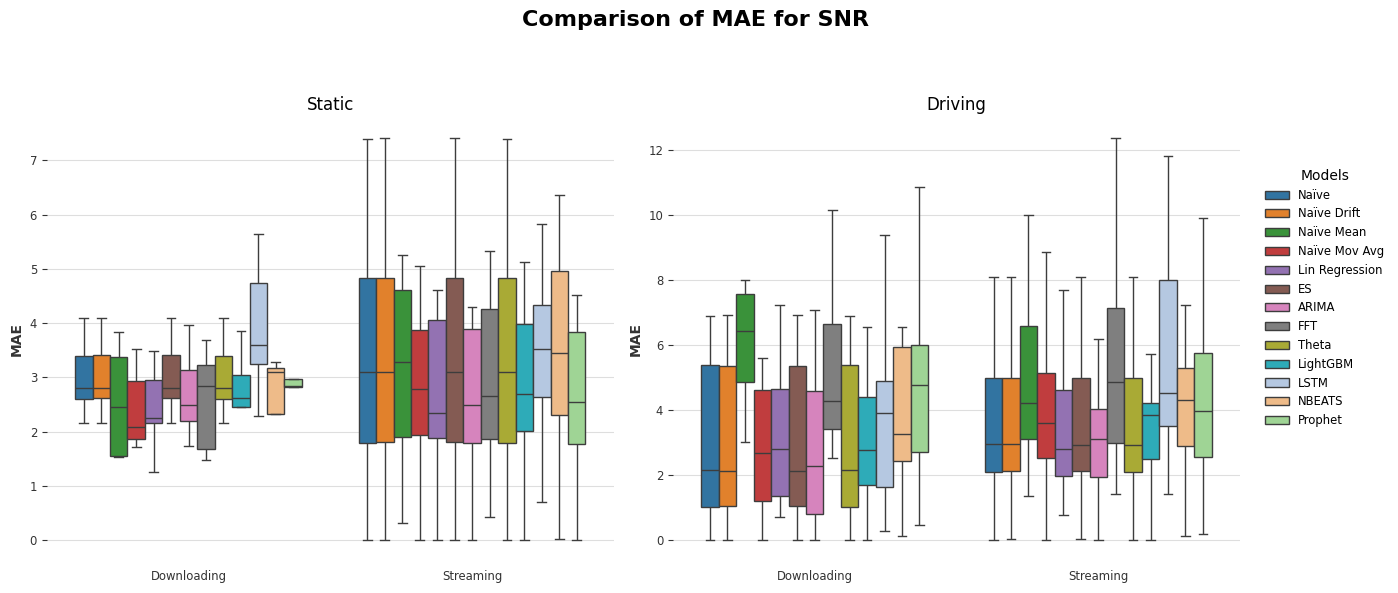

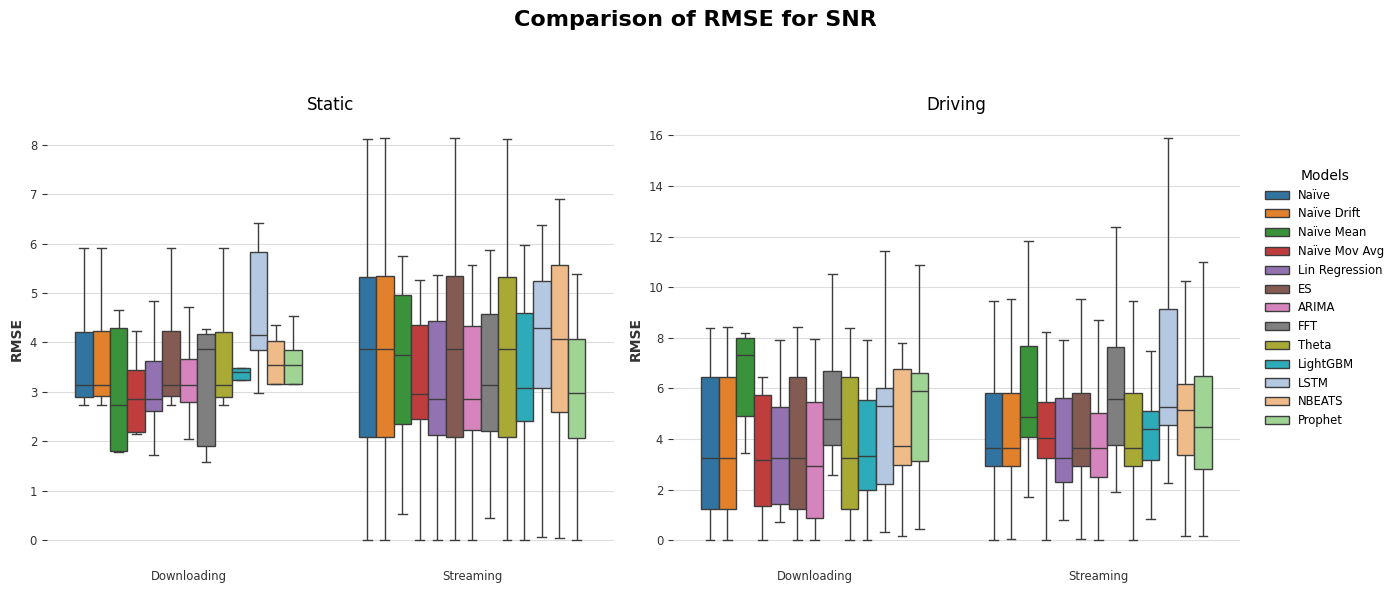

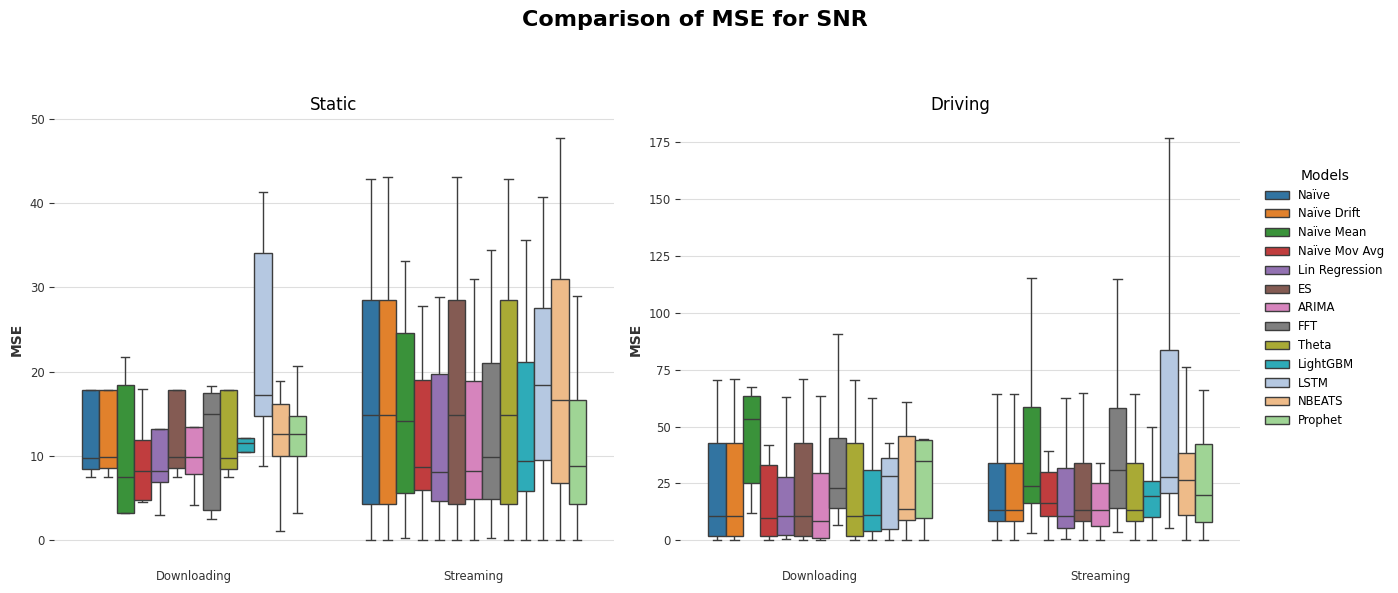

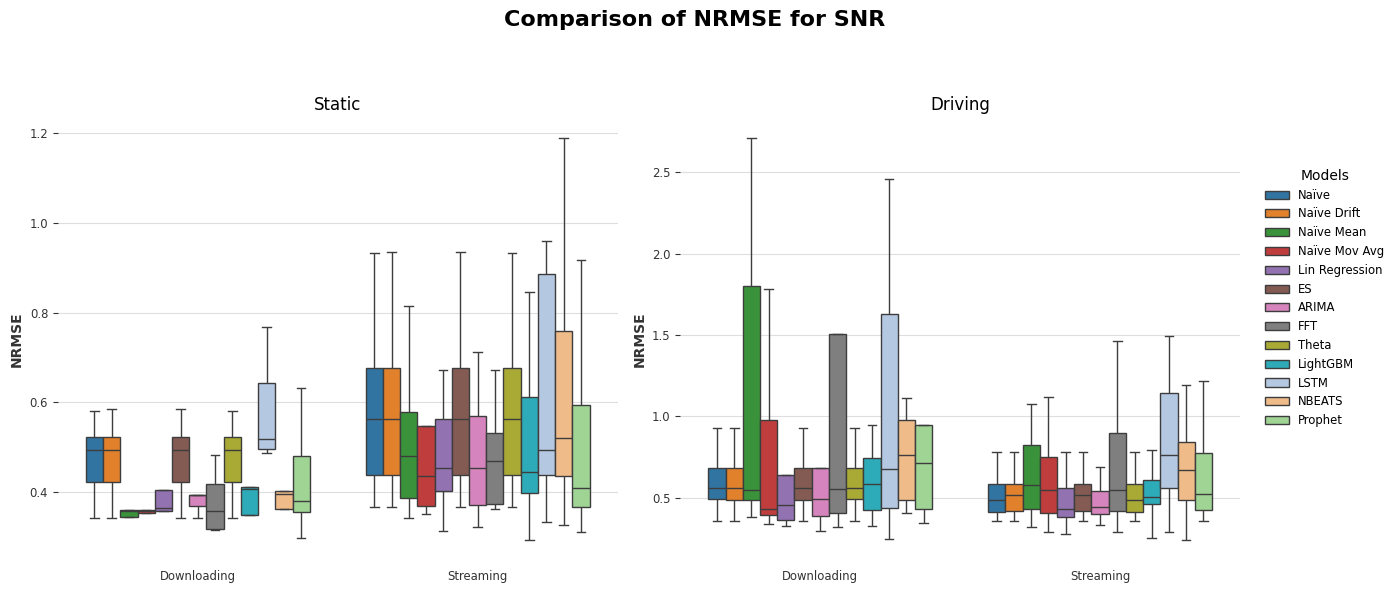

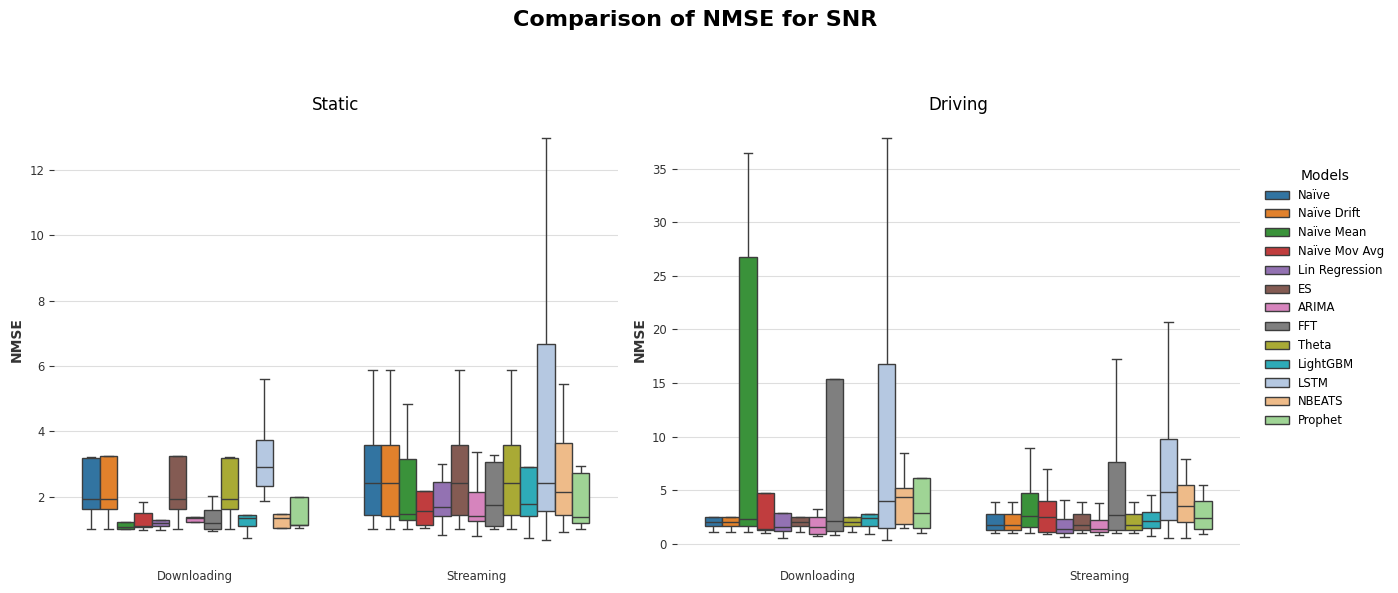

In [ ]:
plot_boxplots_for_metrics_by_target(df_metrics, show_outliers=False)

In [ ]:
plot_boxplots_for_metrics_by_target(df_metrics, show_outliers=False)

In [ ]:
plot_boxplots_for_metrics_by_target(df_metrics, show_outliers=False)

# Lendo os resultados das métricas geradas por um modelo

In [ ]:
def query_lowest_metric(df, metric):
    """
    Realiza uma query no DataFrame que retorna as linhas com o menor valor da métrica especificada para cada combinação de Model, target e Activity.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo as colunas 'Model', 'target', 'Activity' e as métricas.
    metric (str): Nome da métrica a ser avaliada ('MAE', 'RMSE' ou 'MSE').

    Retorna:
    pd.DataFrame: DataFrame contendo as linhas com o menor valor da métrica para cada grupo de Model, target e Activity.
    """

    # Verificar se a métrica especificada é válida
    if metric not in ["MAE", "RMSE", "MSE"]:
        raise ValueError(
            f"Métrica '{metric}' não é válida. Escolha entre 'MAE', 'RMSE' ou 'MSE'."
        )

    # Verificar se as colunas necessárias estão presentes no DataFrame
    required_columns = ["Model", "target", "Activity", metric]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Coluna {col} está ausente no DataFrame")

    # Obter os índices das linhas com o menor valor da métrica para cada combinação de Model, target e Activity
    idx = df.groupby(["Model", "target", "Activity"])[metric].idxmin()

    # Retornar as linhas correspondentes ao menor valor da métrica
    result = df.loc[idx]

    return result

In [ ]:
lowest_mae = query_lowest_metric(df_metrics, "MAE")
lowest_rmse = query_lowest_metric(df_metrics, "RMSE")
lowest_mse = query_lowest_metric(df_metrics, "MSE")

In [ ]:
lowest_mae

## Um gráfico de comparação entre o resultado actual vs forescat em uma das sliding windows

In [ ]:
def plot_actual_vs_preds(
    result_df: pd.DataFrame, model: str, target: str, activity: str
) -> None:
    """
    Plota as séries temporais reais versus as predições para uma combinação específica de Model, target e Activity.

    Args:
        result_df (pd.DataFrame): DataFrame contendo as colunas "Time_Index", "Actuals", "Preds", "Model", "target", "Activity".
        model (str): O modelo a ser filtrado.
        target (str): O alvo a ser filtrado.
        activity (str): A atividade a ser filtrada.
    """
    # Filtra o DataFrame com base nos parâmetros fornecidos
    filtered_df = result_df[
        (result_df["Model"] == model)
        & (result_df["target"] == target)
        & (result_df["Activity"] == activity)
    ]
    print(filtered_df[["MAE", "RMSE", "MSE"]])

    # Verifica se a filtragem resultou em algum dado
    if filtered_df.empty:
        raise ValueError("Nenhum dado encontrado para os parâmetros fornecidos.")

    # Obtém os dados da primeira linha do DataFrame filtrado
    time_index = pd.DatetimeIndex(filtered_df["Time_Index"].iloc[0])
    actuals = filtered_df["Actuals"].iloc[0]
    preds = filtered_df["Preds"].iloc[0]

    # Cria séries temporais para os dados reais e predições
    ts_actuals = TimeSeries.from_times_and_values(time_index, actuals)
    ts_preds = TimeSeries.from_times_and_values(time_index, preds)

    # Plota as séries temporais
    plt.figure(figsize=(14, 7))
    ts_actuals.plot(label="Reais", color="blue")
    ts_preds.plot(
        label="Predições", color="red", linestyle="--"
    )  # Linha tracejada para predições

    # Adiciona título, legendas e labels
    plt.title(
        f"Comparação entre Reais e Predições - Model: {model}, Target: {target}, Activity: {activity}"
    )
    plt.xlabel("Data/Hora")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Exemplo de uso
for model in lowest_mae["Model"].unique():
    plot_actual_vs_preds(
        lowest_rmse, model=model, target="RSRP", activity="static_down"
    )